## AFG - Series de Tiempo Mixtas - Análisis Predictivo e Inductivo

## Librerías

In [1]:
# =========================
# Standard library (Python)
# =========================
import os
import sys
import time
import warnings
from datetime import datetime, timedelta

# ================================
# Manipulación de datos y visualización
# ================================
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", lambda x: f"{x:.6f}")
np.set_printoptions(suppress=True)

import pyarrow.parquet as pq
from joblib import Parallel, delayed #Procesamiento en Paralelo
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import seaborn as sns 


# ================================
# Estadística / Series de tiempo
# ================================ 
from scipy import stats
from scipy.stats import variation, boxcox, yeojohnson, linregress, chi2
from scipy.special import inv_boxcox

from statsmodels.tsa.stattools import (
    adfuller,  # Test ADF (estacionariedad)
    kpss,      # Test KPSS
    acf,       # Autocorrelación
    pacf,      # Autocorrelación parcial
    grangercausalitytests
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox 

# ================================
# ML / Métricas / Validación
# ================================
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
) 
from tqdm.auto import tqdm

from itertools import product

# ================================
# Proyecto

from afg_puc import config
from afg_puc.common.utils import df_col_normalizer
from afg_puc.common.utils import PlotFeatureImportance

# ================================
# Configuración global
# ================================
warnings.filterwarnings("ignore")

c:\Users\crsar\OneDrive - Universidad Católica de Chile\model\Proyect - Magister\code\afg_puc\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-02 20:33:12.606 | INFO     | afg_puc.config:<module>:12 - PROJ_ROOT path is: C:\Users\crsar\OneDrive - Universidad Católica de Chile\model\Proyect - Magister\code\afg_puc


C:\Users\crsar\OneDrive - Universidad Católica de Chile\model\Proyect - Magister\code\afg_puc


## Funciones Auxiliares

In [2]:
def Fecha_formateada(FECHA):
    """ 
    Toma una fecha y la transforma a formato pd.to_datetime short,
    independiente si tiene /,-, orden u hora. 
    """ 
    fecha = FECHA.astype(str).str.strip().str.replace("/", "-").str[:10]
    if fecha.str[2:3].iloc[0] == "-":
        fecha_final = fecha.str[6:10] + "-" + fecha.str[3:5] + "-" + fecha.str[0:2]
    else:
        fecha_final = fecha
    return pd.to_datetime(fecha_final, errors="coerce") 

def grafica_outliers_tipo(FECHA, LISTA, DF, TIPO, devuelve=False):
    """
    TIPO: 'sin_agrupar' | 'agrupado_semanal' | 'agrupado_mensual'
    """
    try:
        df = DF.copy()
        df[FECHA] = Fecha_formateada(df[FECHA])

        # Preparar dataset según TIPO
        if TIPO == "sin_agrupar":
            tmp = df[[FECHA] + LISTA].sort_values(FECHA).reset_index(drop=True)
            fecha_label = FECHA
            y_label_tag = ""
        elif TIPO == "agrupado_semanal":
            tmp = (df.set_index(FECHA)[LISTA]
                     .resample('W-MON').mean().reset_index()
                     .rename(columns={FECHA: "FECHA_SEMANA"}))
            fecha_label = "FECHA_SEMANA"
            y_label_tag = "Promedio semanal de "
        elif TIPO == "agrupado_mensual":
            tmp = (df.set_index(FECHA)[LISTA]
                     .resample('MS').mean().reset_index()
                     .rename(columns={FECHA: "FECHA_MES"}))
            fecha_label = "FECHA_MES"
            y_label_tag = "Promedio mensual de "
        else:
            raise ValueError("Tipo no soportado")

        # Límites del eje X con padding
        fecha_min = tmp[fecha_label].min()
        fecha_max = tmp[fecha_label].max()
        rango = (fecha_max - fecha_min).total_seconds()
        padding = pd.Timedelta(seconds=rango * 0.02)
        
        out_frames = []
        for col in LISTA:
            s = tmp[col].astype(float)
            
            # Omitir si el promedio es 0 o todos son NaN
            if s.mean() == 0 or s.isna().all():
                continue

            q1, q3 = s.quantile([0.25, 0.75])
            iqr = q3 - q1
            low = q1 - 1.5 * iqr
            high = q3 + 1.5 * iqr
            is_out = (s < low) | (s > high)

            n_out = int(is_out.sum())
            pct = 100.0 * n_out / len(tmp) if len(tmp) else 0.0

            fig, ax = plt.subplots(figsize=(12, 4))
            ax.plot(tmp[fecha_label], s, lw=1.2, alpha=0.7, zorder=1)
            ax.scatter(tmp.loc[~is_out, fecha_label], s[~is_out], 
                      s=12, alpha=0.5, label='Normal', zorder=2)
            ax.scatter(tmp.loc[is_out, fecha_label], s[is_out], 
                      s=18, alpha=0.8, label=f'Outliers ({n_out}, {pct:.1f}%)', 
                      color='red', zorder=3)
            
            ax.set_xlim(fecha_min - padding, fecha_max + padding)
            ax.set_title(f"{col} – Outliers (IQR) [{TIPO}]")
            ax.set_xlabel(fecha_label)
            ax.set_ylabel(f"{y_label_tag}{col}".strip())
            ax.legend(loc='best')
            ax.grid(True, alpha=0.3)
            fig.tight_layout()
            plt.show()

            if devuelve:
                out_frames.append(pd.DataFrame({
                    fecha_label: tmp[fecha_label].values,
                    "variable": col,
                    "value": s.values,
                    "is_outlier": is_out.values
                }))

        if devuelve and out_frames:
            return pd.concat(out_frames, ignore_index=True)
        return None

    except Exception as e:
        raise ValueError(f"Input no válido: {str(e)}") 

# Carga de datos

In [3]:
df_consol = pd.read_parquet(config.PROCESSED_DATA_DIR / "df_consol.parquet", engine="pyarrow")
df_consol.index = pd.to_datetime(df_consol.index)
df_consol = df_consol.sort_index()

#SOLO realizar EDA con data de entrenamiento, sin considerar particion de validacion (-63 test -35 de validación )
df_train= df_consol.iloc[:-98]

dow = df_train.index.weekday
df_train["cercania_lunes"] = (0 - dow) % 7
df_train["lejanania_lunes_pas"] = (dow - 0) % 7

TARGET_COLS = ["oro", "plata", "cobre", "petroleo_brent", "gas_natural"]

print("TRAIN diario (excluye últimos 63 dias):", len(df_train), "|", df_train.index.min(), "->", df_train.index.max())
print("HOLDOUT 63 dias:", len(df_consol.loc[df_consol.index > df_train.index.max()]), "|", df_consol.loc[df_consol.index > df_train.index.max()].index.min(), "->", df_consol.loc[df_consol.index > df_train.index.max()].index.max())

TRAIN diario (excluye últimos 63 dias): 4665 | 2007-07-30 00:00:00 -> 2025-06-13 00:00:00
HOLDOUT 63 dias: 98 | 2025-06-16 00:00:00 -> 2025-10-29 00:00:00


In [4]:
df_train=df_consol.iloc[:-98]

In [5]:
df_consol.index = pd.to_datetime(df_consol.index, errors='coerce')  
idx = df_consol.index
df_consol['fecha'] = idx

#### Preparar datos --> Fecha
##### Lista de Campos para analizar distribución

## Análisis de Valores Atípicos

## FulltravelDuration --> dueños del negocio imputar a la media 
## Empytotaldistance --> media/mediana 
## condiciones climaticas/camino u otras. 
 

In [6]:
campos_numericos=list(df_consol.columns[:5])

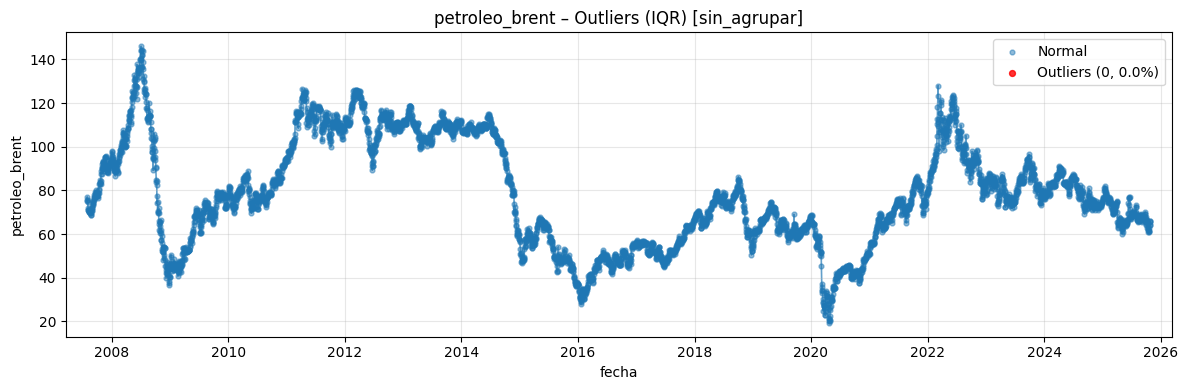

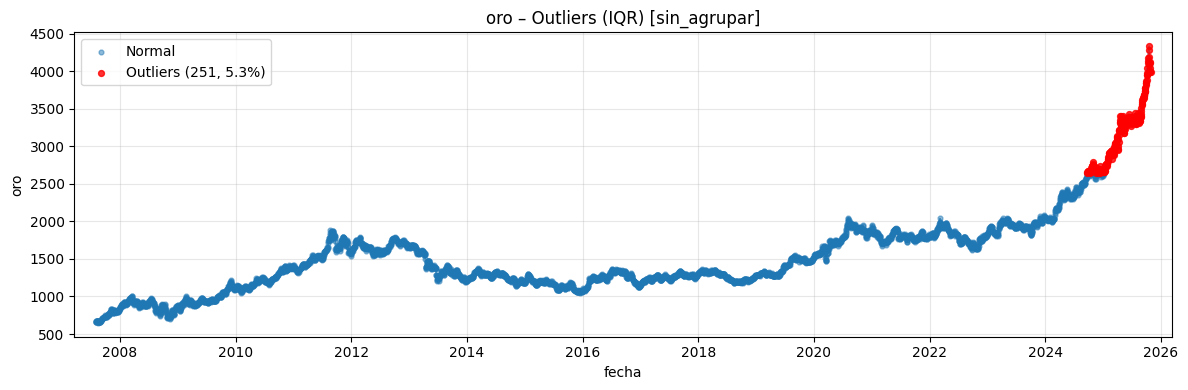

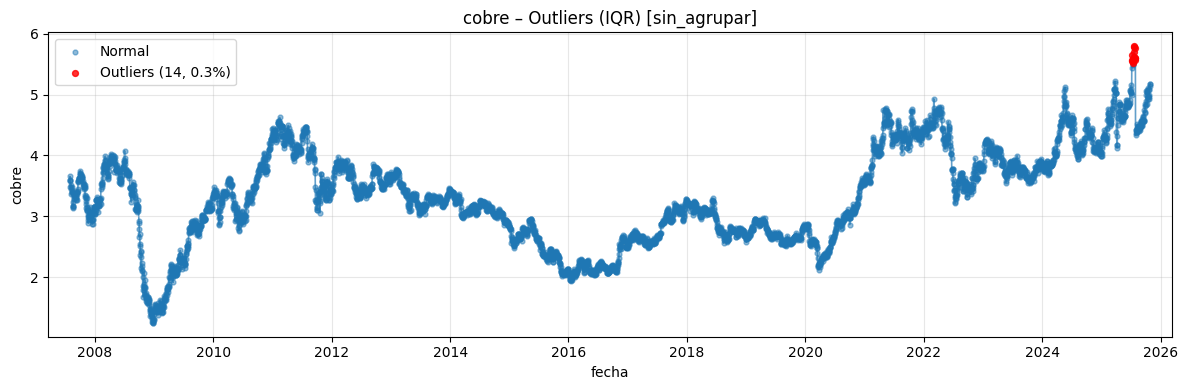

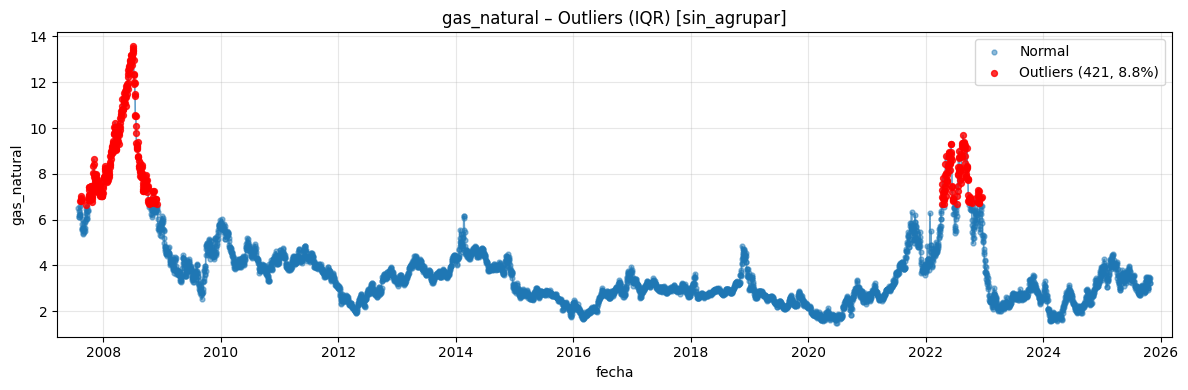

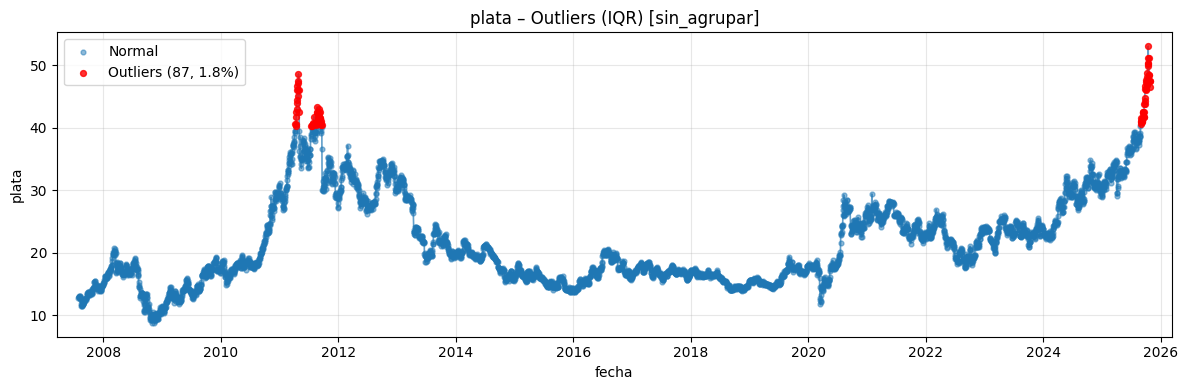

In [7]:
grafica_outliers_tipo("fecha", campos_numericos, df_consol,"sin_agrupar")

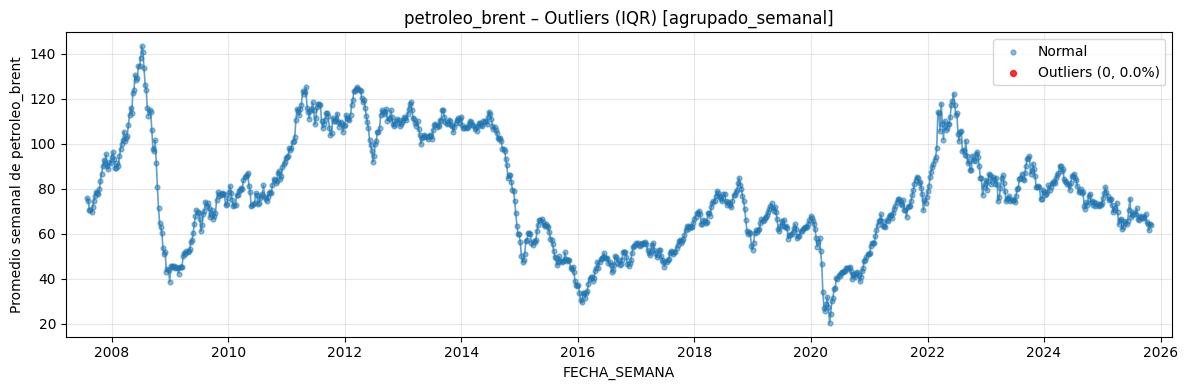

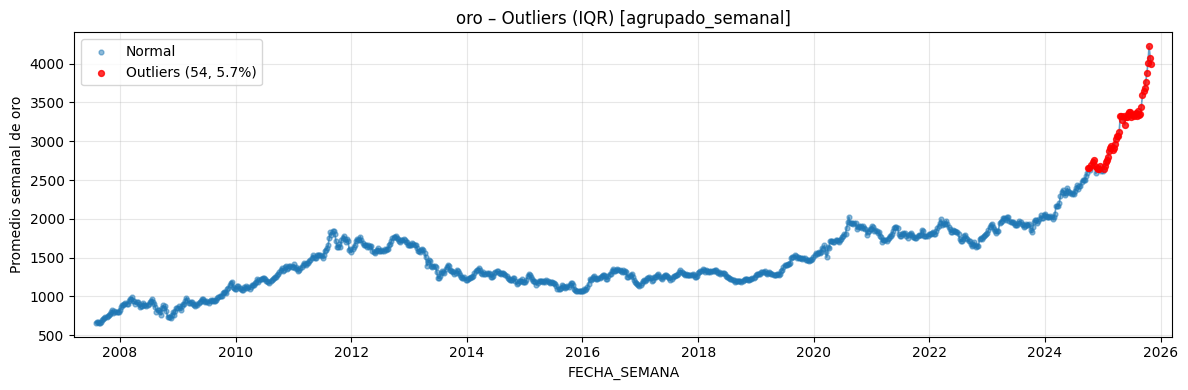

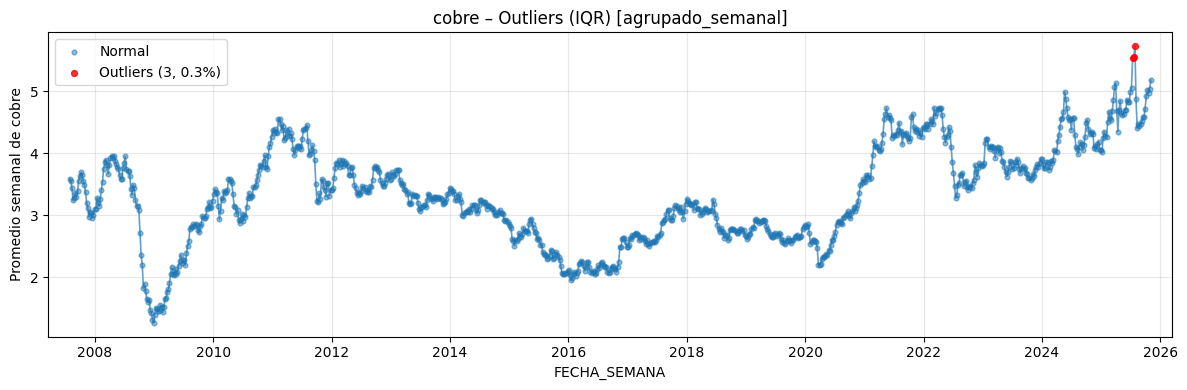

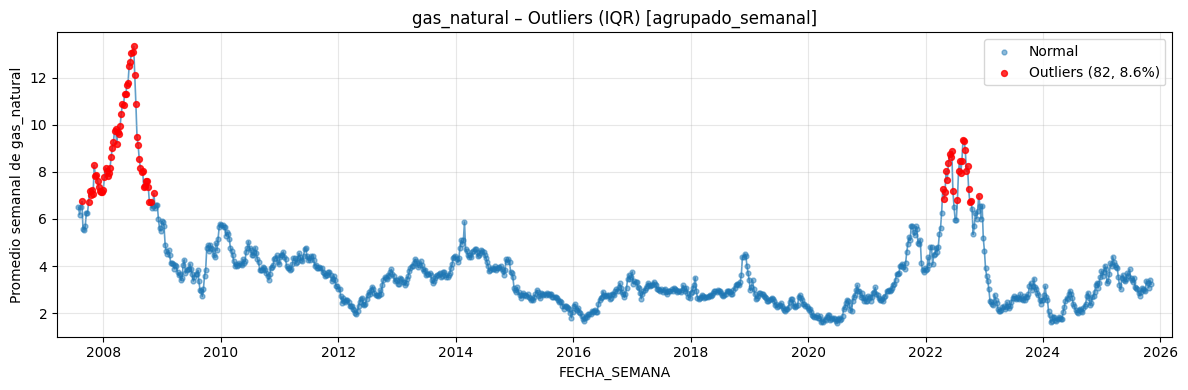

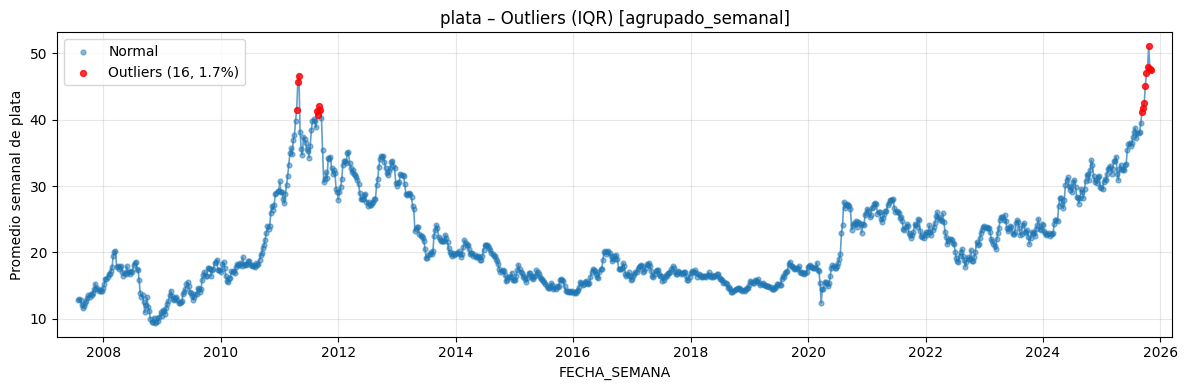

In [8]:
grafica_outliers_tipo("fecha", campos_numericos, df_consol,"agrupado_semanal")

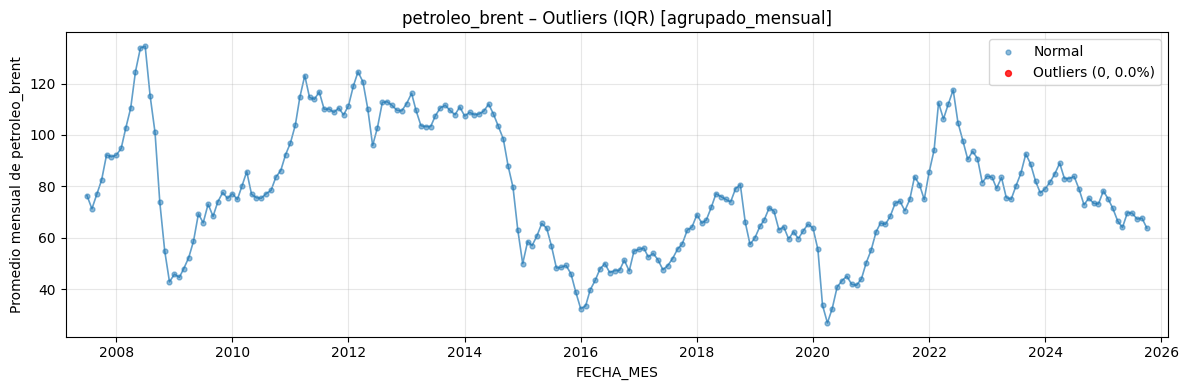

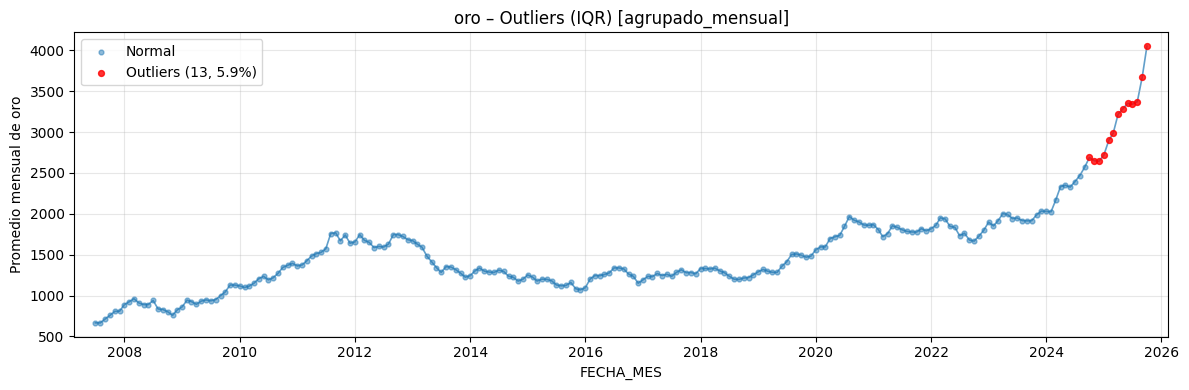

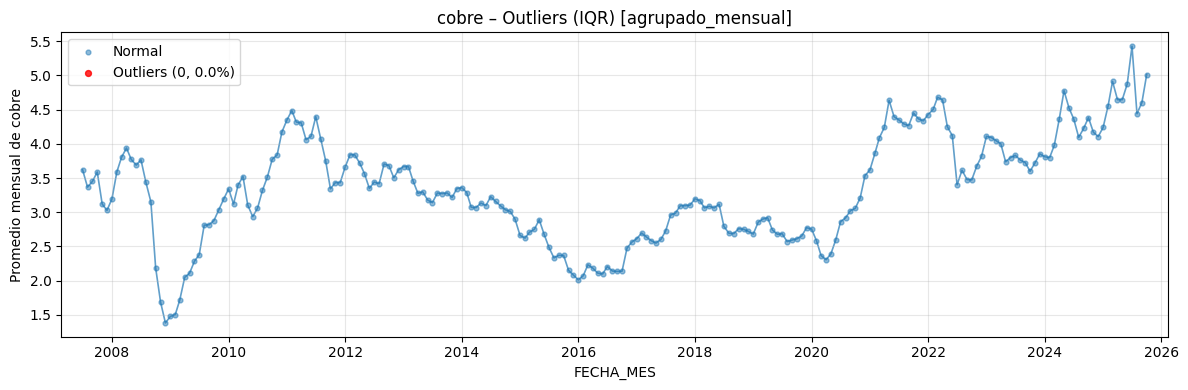

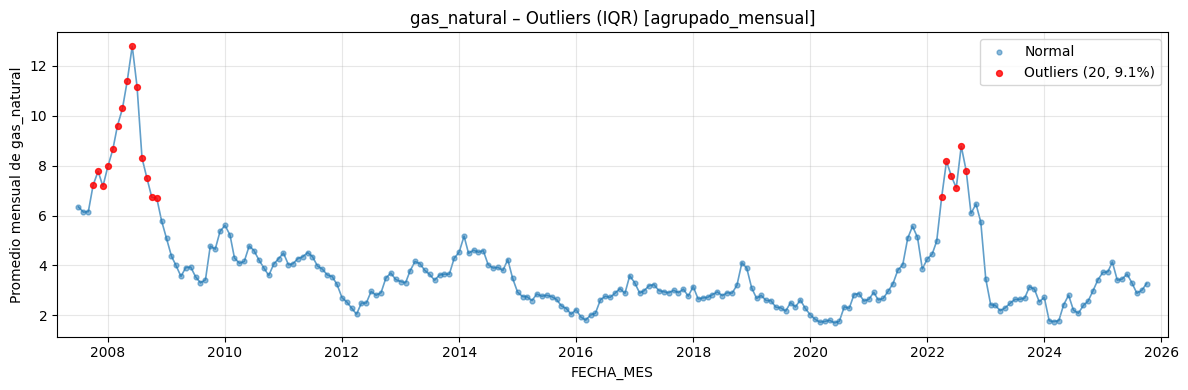

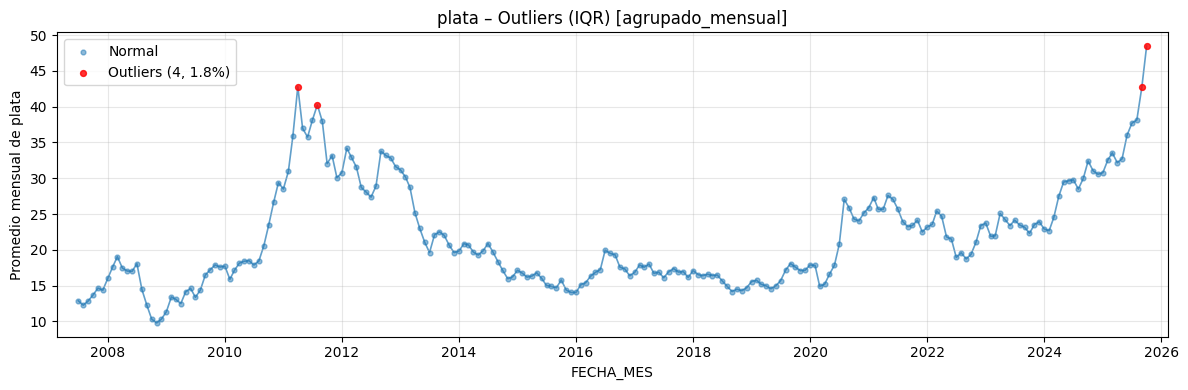

In [9]:
grafica_outliers_tipo("fecha", campos_numericos, df_consol,"agrupado_mensual")

# Modelo Mensual - Oro

In [10]:
df_train = df_col_normalizer(df_train)  
df_train.index.freq = 'B'

## Análisis de Distribución

In [11]:
# === TEST DE SHAPIRO-WILK ===
print("=" * 70)
print("TEST DE SHAPIRO-WILK (Normalidad)")
print("=" * 70)
shapiro_stat, shapiro_p = stats.shapiro(df_train['oro'].dropna())
print(f"Shapiro Statistic: {shapiro_stat:.4f}")
print(f"p-value: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("H0: No se rechaza - distribución normal")
    
else:
    print("H0: Se rechaza hipotesis nula - datos no presentan distribución normal")

TEST DE SHAPIRO-WILK (Normalidad)
Shapiro Statistic: 0.9200
p-value: 0.0000
H0: Se rechaza hipotesis nula - datos no presentan distribución normal


al no representar una distribución normal, se debe transformar para ser procesados por una serie de tiempo clásica de la familia arima

# * Análisis Segun Lambda 

Log transformation:
Cuando: Datos positivos con varianza creciente (heteroscedasticidad) --> pero más controlada
Requisito: Todos los valores > 0

Box-Cox:
Cuando: Datos positivos, necesitas estabilizar varianza y mejorar normalidad
Requisito: Todos los valores > 0
Ventaja: Encuentra automáticamente el mejor lambda 
Acá funciona mejor que el log cuando la varianza es más descontrolada y tiene un comportamiento más aleatireo

Yeo-Johnson:
Cuando: Datos con valores negativos o ceros--> se necesitas estabilizar varianza
versión de Box-Cox para negativos

## Test de yj

In [12]:
transformacion, lambda_opt = boxcox(df_train['oro'])
print(f"Lambda óptimo: {lambda_opt:.4f}") 

Lambda óptimo: -0.1675


* BOXCOX No sirve producto de Lambda negativo --> Se opta por YEO-JOHNSON

* Mejora la varianza y mejora la normalidad de la serie  

In [13]:
transformacion, lambda_opt = yeojohnson(df_train['oro'])
print(f"Lambda óptimo: {lambda_opt:.4f}") 

Lambda óptimo: -0.1684


### Se procede a transformar a YJ

In [14]:
df_oro=df_train.copy()
df_oro['oro_yj'] = yeojohnson(df_oro['oro'], lmbda=lambda_opt)

## Análisis de Descomposición Aditiva o Multiplicativa

El modelo multiplicativo es más adecuado (CV menor).


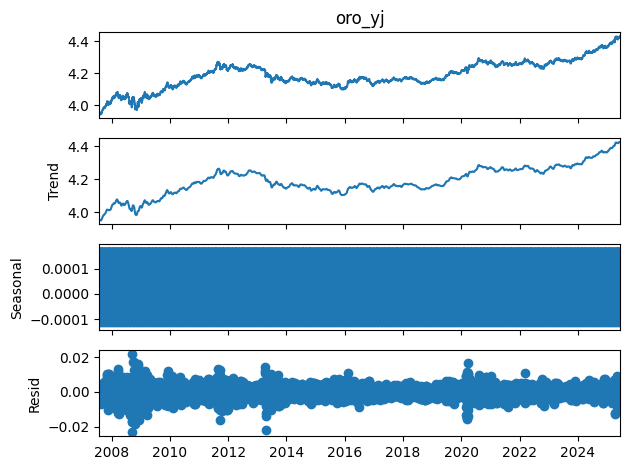

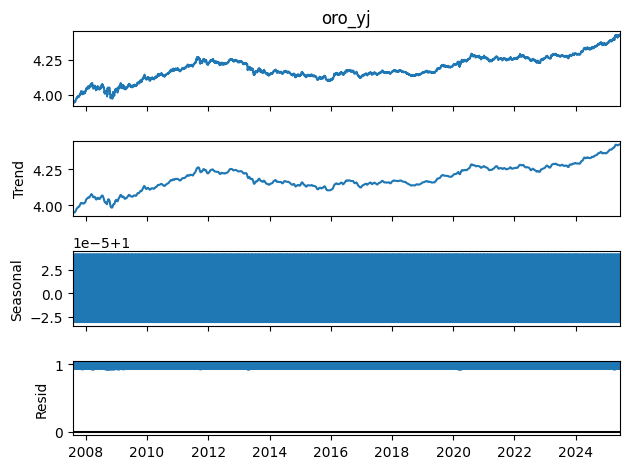

In [15]:
decompose_add = seasonal_decompose(df_oro['oro_yj'] , model='additive', period=12)
decompose_mult = seasonal_decompose(df_oro['oro_yj'] , model='multiplicative', period=12)

decompose_add.plot()
decompose_mult.plot()


seasonal_add = decompose_add.seasonal
seasonal_mult = decompose_mult.seasonal

cv_add = variation(seasonal_add.dropna())
cv_mult = variation(seasonal_mult.dropna()) 
if cv_add < cv_mult:
    print("El modelo aditivo es más adecuado (CV menor).")
elif cv_add > cv_mult:
    print("El modelo multiplicativo es más adecuado (CV menor).")
else:
    print("Ambos modelos tienen el mismo CV.")

* Según nuestro test existe la posibilidad de que un modelo SARIMA se pueda adaptar bien a nuestros datos, pero claramente muestra tendencia, así que amerita test de DF

### ADF Y KPSS

In [16]:
series_to_test = df_oro['oro_yj'] .dropna()

#ADF
adf_stat, adf_pval, adf_lags, adf_nobs, adf_crit, _ = adfuller(series_to_test)
print(f"ADF Statistic : {adf_stat:.4f}")
print(f"ADF p-value   : {adf_pval:.4g}")
print("»", "Estacionaria" if adf_pval < 0.05 else "NO estacionaria", "según ADF")

#KPSS
kpss_stat, kpss_pval, kpss_lags, kpss_crit = kpss(series_to_test, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat:.4f}")
print(f"KPSS p-value  : {kpss_pval:.4g}")
print("»", "Estacionaria" if kpss_pval > 0.05 else "NO estacionaria", "según KPSS")

tests_df = pd.DataFrame([
    {
        "serie": "oro_yj",
        "test": "ADF",
        "stat": adf_stat,
        "p_value": adf_pval,
        "lags_usados": adf_lags,
        "n_observaciones": adf_nobs,
        "crit_1%": adf_crit.get("1%"),
        "crit_5%": adf_crit.get("5%"),
        "crit_10%": adf_crit.get("10%"),
        "estacionaria": adf_pval < 0.05  # criterio ADF
    },
    {
        "serie": "oro_yj",
        "test": "KPSS (c)",
        "stat": kpss_stat,
        "p_value": kpss_pval,
        "lags_usados": kpss_lags,
        "n_observaciones": series_to_test.shape[0],
        "crit_1%": float(kpss_crit.get("1%")),
        "crit_5%": float(kpss_crit.get("5%")),
        "crit_10%": float(kpss_crit.get("10%")),
        "estacionaria": kpss_pval > 0.05  # criterio KPSS
    }
])

ts_tests_mensual = tests_df

print(ts_tests_mensual)

ADF Statistic : -1.2675
ADF p-value   : 0.6439
» NO estacionaria según ADF
KPSS Statistic: 6.6805
KPSS p-value  : 0.01
» NO estacionaria según KPSS
    serie      test      stat  p_value  lags_usados  n_observaciones  \
0  oro_yj       ADF -1.267529 0.643894           13             4651   
1  oro_yj  KPSS (c)  6.680498 0.010000           41             4665   

    crit_1%   crit_5%  crit_10%  estacionaria  
0 -3.431757 -2.862162 -2.567101         False  
1  0.739000  0.463000  0.347000         False  


* Producto de que los modelos de la familia arima estan hechos para manejar datos estacionarios, se opta por diferenciar

In [17]:
df_oro['oro_yj_dif'] = df_oro['oro_yj'].diff()
df_cierre_mensual_dif_oro = df_oro.dropna(subset="oro_yj_dif")

In [18]:
#ADF
adf_stat_dif, adf_pval_dif, adf_lags_dif, adf_nobs_dif, adf_crit_dif, _ = adfuller(df_cierre_mensual_dif_oro["oro_yj_dif"])
print(f"ADF Statistic : {adf_stat_dif:.4f}")
print(f"ADF p-value   : {adf_pval_dif:.4g}")
print("»", "Estacionaria" if adf_pval_dif < 0.05 else "NO estacionaria", "según ADF")

#KPSS
kpss_stat_dif, kpss_pval_dif, kpss_lags_dif, kpss_crit_dif = kpss(df_cierre_mensual_dif_oro["oro_yj_dif"], regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat_dif:.4f}")
print(f"KPSS p-value  : {kpss_pval_dif:.4g}")
print("»", "Estacionaria" if kpss_pval_dif > 0.05 else "NO estacionaria", "según KPSS")

tests_df_dif = pd.DataFrame([
    {
        "serie": "oro_yj_dif",
        "test": "ADF",
        "stat": adf_stat_dif,
        "p_value": adf_pval_dif,
        "lags_usados": adf_lags_dif,
        "n_observaciones": adf_nobs_dif,
        "crit_1%": adf_crit_dif.get("1%"),
        "crit_5%": adf_crit_dif.get("5%"),
        "crit_10%": adf_crit_dif.get("10%"),
        "estacionaria": adf_pval_dif < 0.05  # criterio ADF
    },
    {
        "serie": "oro_yj_dif",
        "test": "KPSS (c)",
        "stat": kpss_stat_dif,
        "p_value": kpss_pval_dif,
        "lags_usados": kpss_lags_dif,
        "n_observaciones": df_cierre_mensual_dif_oro["oro_yj_dif"].shape[0],
        "crit_1%": float(kpss_crit_dif.get("1%")),
        "crit_5%": float(kpss_crit_dif.get("5%")),
        "crit_10%": float(kpss_crit_dif.get("10%")),
        "estacionaria": kpss_pval_dif > 0.05  # criterio KPSS
    }
])

ts_tests_mensual_dif = tests_df_dif

print(ts_tests_mensual_dif)

ADF Statistic : -19.3586
ADF p-value   : 0
» Estacionaria según ADF
KPSS Statistic: 0.1691
KPSS p-value  : 0.1
» Estacionaria según KPSS
        serie      test       stat  p_value  lags_usados  n_observaciones  \
0  oro_yj_dif       ADF -19.358644 0.000000           12             4651   
1  oro_yj_dif  KPSS (c)   0.169080 0.100000           11             4664   

    crit_1%   crit_5%  crit_10%  estacionaria  
0 -3.431757 -2.862162 -2.567101          True  
1  0.739000  0.463000  0.347000          True  


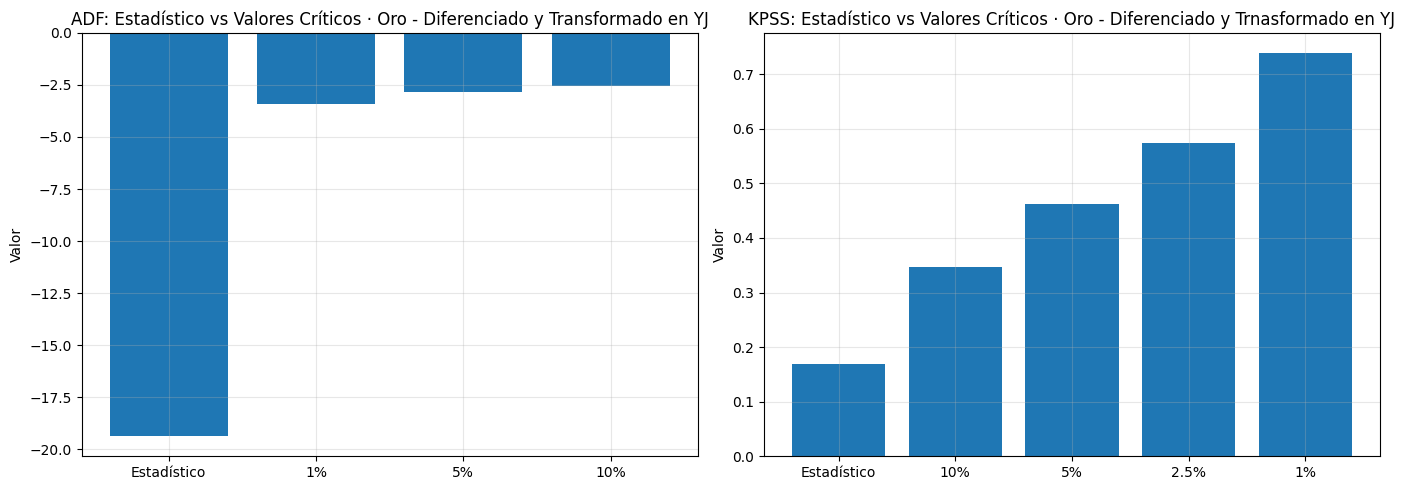

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ADF
axes[0].bar(['Estadístico'] + list(adf_crit_dif.keys()),
            [adf_stat_dif] + list(adf_crit_dif.values()))
axes[0].set_title("ADF: Estadístico vs Valores Críticos · Oro - Diferenciado y Transformado en YJ")
axes[0].set_ylabel("Valor"); axes[0].grid(alpha=.3)

# KPSS
axes[1].bar(['Estadístico'] + list(kpss_crit_dif.keys()),
            [kpss_stat_dif] + [float(k) for k in kpss_crit_dif.values()])
axes[1].set_title("KPSS: Estadístico vs Valores Críticos · Oro - Diferenciado y Trnasformado en YJ")
axes[1].set_ylabel("Valor"); axes[1].grid(alpha=.3)

plt.tight_layout(); plt.show()

* La Serie es Estacionaria

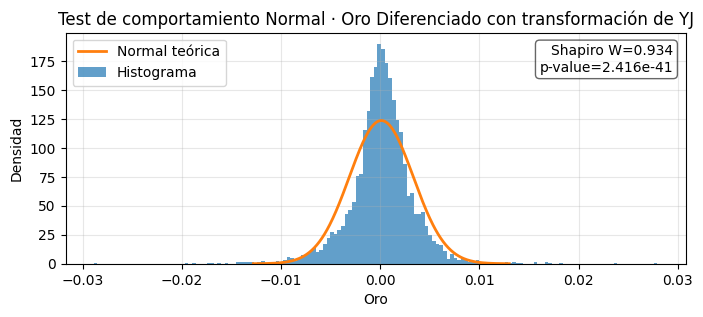

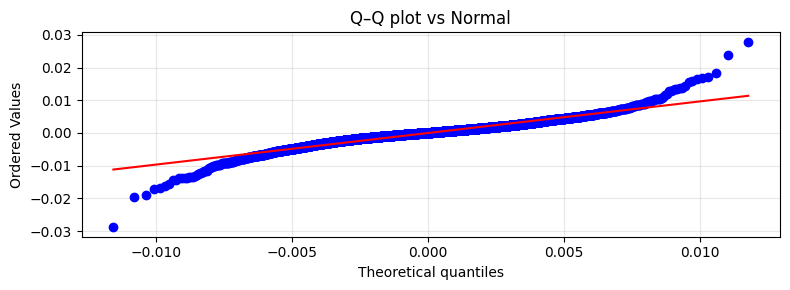

In [20]:
y = df_cierre_mensual_dif_oro["oro_yj_dif"]
sh_stat, sh_p = stats.shapiro(y)

mu, sigma = np.mean(y), np.std(y, ddof=1)
xs = np.linspace(mu - 4*sigma, mu + 4*sigma, 400)

#hist + curva teorica
plt.figure(figsize=(8,3))
plt.hist(y, bins='auto', density=True, alpha=0.7)
plt.plot(xs, stats.norm.pdf(xs, mu, sigma), linewidth=2)
plt.title("Test de comportamiento Normal · Oro Diferenciado con transformación de YJ")
plt.xlabel("Oro")
plt.ylabel("Densidad")
plt.grid(alpha=.3)
plt.legend(["Normal teórica", "Histograma"], loc="best")
plt.annotate(f"Shapiro W={sh_stat:.3f}\np-value={sh_p:.4g}",
             xy=(0.98, 0.95), xycoords="axes fraction",
             ha="right", va="top",
             bbox=dict(boxstyle="round", fc="white", alpha=0.6))

# --- Q–Q plot ---
plt.figure(figsize=(8,3))
# Usamos la normal con media y sigma estimados
stats.probplot(y, dist="norm", sparams=(mu, sigma), plot=plt)
plt.title("Q–Q plot vs Normal")
plt.grid(alpha=.3)

plt.tight_layout()
plt.show()

## ACF Y PACF AL PASAR TEST

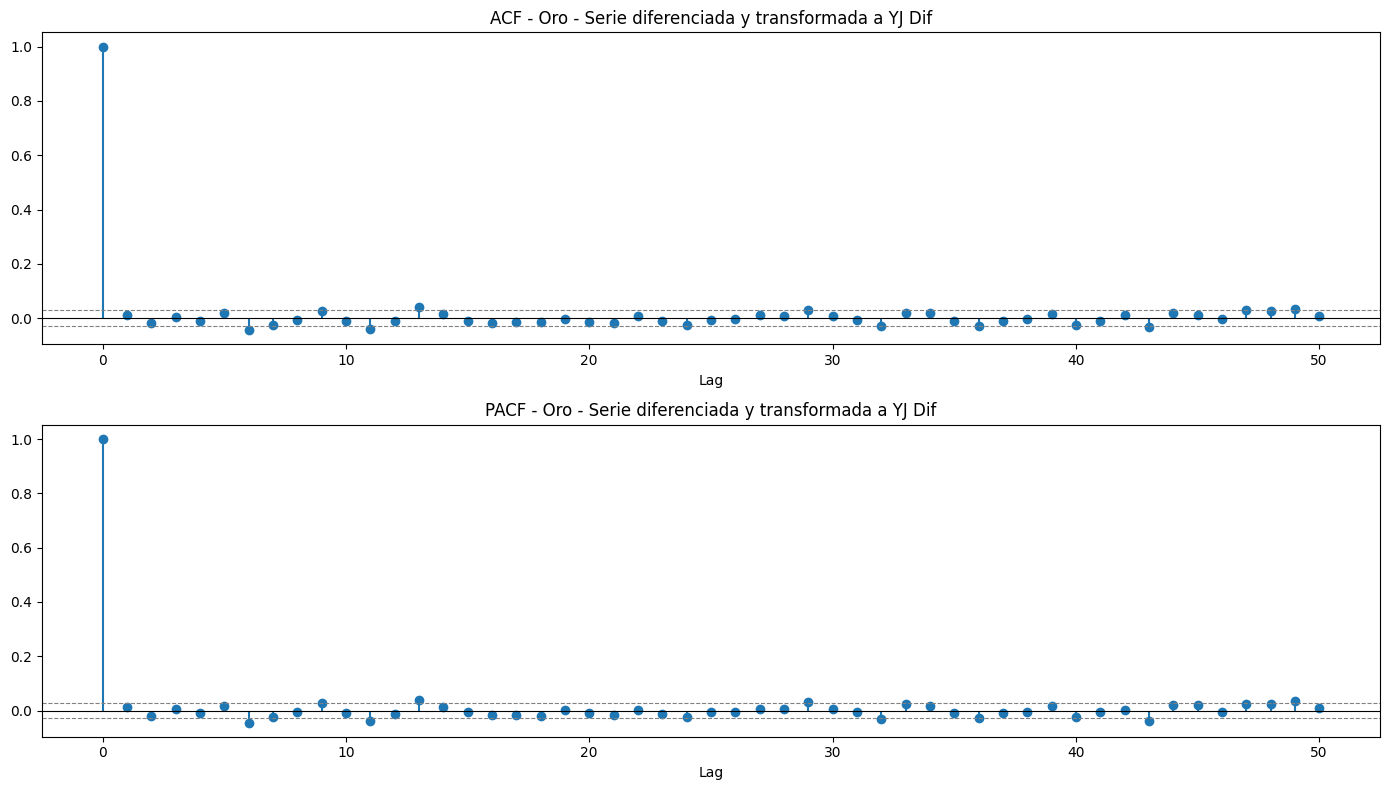

In [21]:
n = len(df_cierre_mensual_dif_oro)
nlags_acf  = min(50, n-1)
nlags_pacf = min(50, n-1)

pacf_monthly = pacf(df_cierre_mensual_dif_oro["oro_yj_dif"], nlags=nlags_pacf, method='ywmle')
acf_monthly = acf(df_cierre_mensual_dif_oro["oro_yj_dif"], nlags=nlags_acf)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
conf = 1.96 / np.sqrt(n)

axes[0].stem(range(len(acf_monthly)), acf_monthly, basefmt=' ')
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].axhline(conf, linestyle='--', color='gray', linewidth=0.8)
axes[0].axhline(-conf, linestyle='--', color='gray', linewidth=0.8)
axes[0].set_title('ACF - Oro - Serie diferenciada y transformada a YJ Dif')
axes[0].set_xlabel('Lag')

axes[1].stem(range(len(pacf_monthly)), pacf_monthly, basefmt=' ')
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].axhline(conf, linestyle='--', color='gray', linewidth=0.8)
axes[1].axhline(-conf, linestyle='--', color='gray', linewidth=0.8)
axes[1].set_title('PACF - Oro - Serie diferenciada y transformada a YJ Dif')
axes[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

## Podría indicar que existe un componente estacional cada 10 periodos

* p=AR=0
* d=1 --> 1 diferenciacion  
* No hay componentes que nos hayan pensar que para lag 0 se promedien x lag pasados --> probar entre 0 y 1
* No se aprecia con exactitud los componentes autoregresivos que tienen los lag de forma estacional, así que se opta por buscar en base a lista [1,0]
* Q Podría ser 5, se aprecia y shock proveniente de los residuos en 5 o 6
* No se puede distinguir claramente una estacionalidad, pero se optara por probar s=[5,7]

### Eliminar la colinealidad a través de Granger

In [22]:
target = "oro_yj_dif"
num_cols = df_cierre_mensual_dif_oro.select_dtypes(include=[np.number]).columns.drop(target, errors="ignore")

#Calcular Granger F para todas
granger_scores = []
for col in num_cols:
    data = df_cierre_mensual_dif_oro[[target, col]].dropna()
    if len(data) < 10:
        continue
    try:
        results = grangercausalitytests(data, maxlag=3, verbose=False)
        #Máximo F-stat entre todos los lags
        max_f = max([results[lag][0]['ssr_ftest'][0] for lag in results.keys()])
        granger_scores.append({'variable': col, 'Granger_F': max_f})
    except:
        continue

granger_df = pd.DataFrame(granger_scores).sort_values('Granger_F', ascending=False)

#Eliminar multicolinealidad (corr > 0.85)
vars_list = granger_df['variable'].tolist()
corr_matrix = df_cierre_mensual_dif_oro[vars_list].corr()

variables_a_eliminar = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
            f1 = granger_df[granger_df['variable'] == var1]['Granger_F'].values[0]
            f2 = granger_df[granger_df['variable'] == var2]['Granger_F'].values[0]
            
            #Eliminar la de MENOR Granger F (peor causalidad)
            variables_a_eliminar.add(var2 if f1 > f2 else var1)

top = granger_df[~granger_df['variable'].isin(variables_a_eliminar)] 
lista_variables_oro=top['variable'].tolist()+ list([target])+['oro_yj']
lista_variables_oro_test=top['variable'].tolist()+['oro_yj']       

#### Limpieza de DF

In [23]:
df_oro_final=df_cierre_mensual_dif_oro[lista_variables_oro]

## Matrix de Corr() - Oro

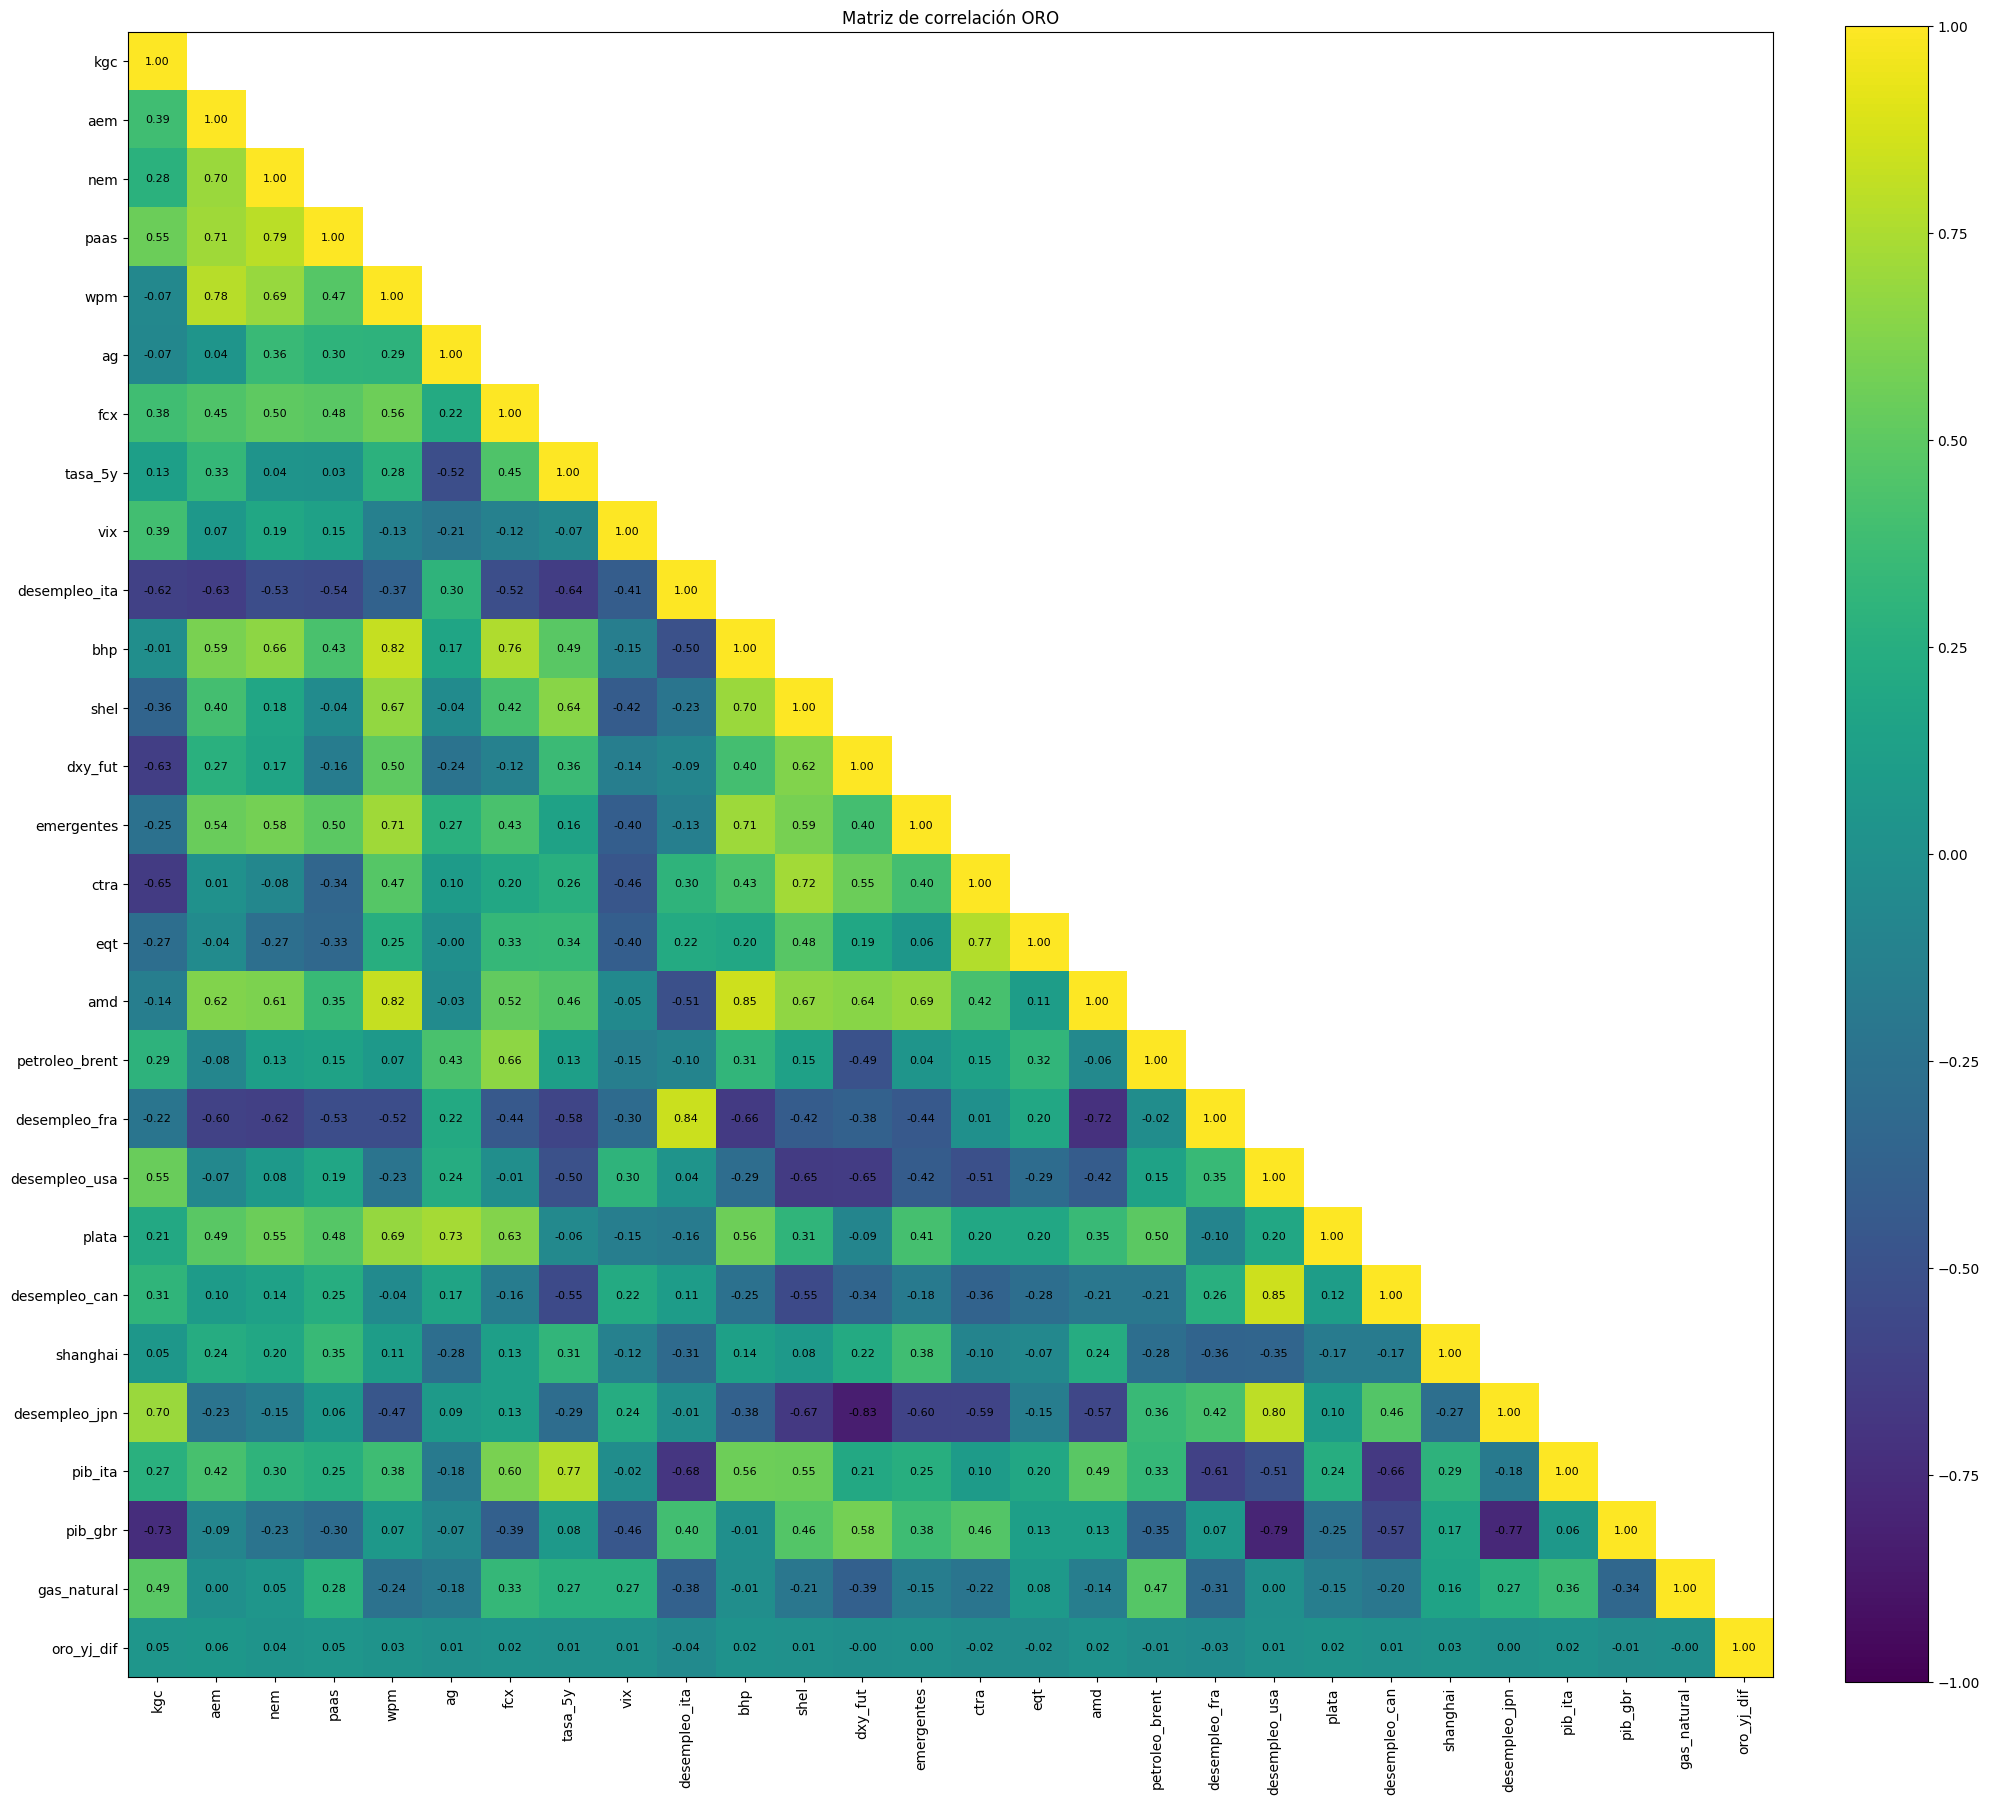

In [24]:
num_cols = (
    df_oro_final.drop(columns=["oro_yj"])
    .select_dtypes(include="number")
    .drop(columns=["fecha"], errors="ignore")
)

corr = num_cols.corr()

M = corr.values.copy()
mask = np.triu(np.ones_like(M, dtype=bool), k=1)
M_masked = M.copy()
M_masked[mask] = np.nan

plt.figure(figsize=(20, 20))
im = plt.imshow(M_masked, vmin=-1, vmax=1)  # sin cmap explícito
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        if not mask[i, j] and not np.isnan(M_masked[i, j]):
            plt.text(j, i, f"{M[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.title("Matriz de correlación ORO")
plt.tight_layout()
plt.show()

### Analisis de Causalidad de Granger 

In [25]:
exclude_cols = ["oro","oro_yj"]
features = df_oro_final.drop(columns=exclude_cols, errors="ignore").select_dtypes(include=['float64', 'int64']).columns

max_lag = 7
results = []

for col in features:
    try:
        data = df_oro_final[[col, "oro_yj_dif"]].dropna()
        
        if len(data) > max_lag + 1:
            test = grangercausalitytests(data[["oro_yj_dif", col]], max_lag, verbose=False)
            row = {'Feature': col}
            for lag in range(1, max_lag + 1):
                p_val = test[lag][0]['ssr_ftest'][1]
                row[f'P_Value_Lag{lag}'] = p_val
                row[f'Significant_Lag{lag}'] = p_val < 0.05
            
            results.append(row)
    except:
        continue
granger_df = pd.DataFrame(results)
granger_df['Min_P_Value'] = granger_df[['P_Value_Lag1', 'P_Value_Lag2', 'P_Value_Lag3']].min(axis=1)
granger_df = granger_df.sort_values('Min_P_Value').reset_index(drop=True)

granger_df.head(40)

Feature  P_Value_Lag1  Significant_Lag1  P_Value_Lag2  \
0              kgc      0.161725             False      0.000000   
1              aem      0.283484             False      0.000000   
2              nem      0.897101             False      0.000000   
3             paas      0.886021             False      0.000000   
4              wpm      0.894591             False      0.000000   
5               ag      0.064385             False      0.000000   
6              fcx      0.750459             False      0.000015   
7          tasa_5y      0.109858             False      0.000017   
8              vix      0.308351             False      0.000174   
9              bhp      0.761163             False      0.000213   
10      emergentes      0.686982             False      0.002050   
11            shel      0.661920             False      0.000832   
12         dxy_fut      0.404301             False      0.001042   
13   desempleo_ita      0.003404              True      0.010943   
14            ctra      0.107621             False      0.004815   
15             eqt      0.161667             False      0.008531   
16  petroleo_brent      0.049811              True      0.021294   
17             amd      0.326673             False      0.020089   
18   desempleo_usa      0.524754             False      0.030997   
19   desempleo_fra      0.051416             False      0.048578   
20   desempleo_can      0.406985             False      0.057153   
21        shanghai      0.097997             False      0.071044   
22           plata      0.083762             False      0.167589   
23   desempleo_jpn      0.792233             False      0.559239   
24         pib_ita      0.148887             False      0.316301   
25         pib_gbr      0.326936             False      0.255081   
26     gas_natural      0.579691             False      0.859890   

    Significant_Lag2  P_Value_Lag3  Significant_Lag3  P_Value_Lag4  \
0               True      0.000000              True      0.000000   
1               True      0.000000              True      0.000000   
2               True      0.000000              True      0.000000   
3               True      0.000000              True      0.000000   
4               True      0.000000              True      0.000000   
5               True      0.000000              True      0.000001   
6               True      0.000053              True      0.000124   
7               True      0.000038              True      0.000006   
8               True      0.000313              True      0.000004   
9               True      0.000692              True      0.001140   
10              True      0.000489              True      0.000152   
11              True      0.002767              True      0.002691   
12              True      0.002934              True      0.006628   
13              True      0.022830              True      0.006048   
14              True      0.010638              True      0.013647   
15              True      0.022143              True      0.020946   
16              True      0.010250              True      0.022713   
17              True      0.039824              True      0.070983   
18              True      0.072755             False      0.022657   
19              True      0.059798             False      0.094179   
20             False      0.117784             False      0.078456   
21             False      0.082627             False      0.138867   
22             False      0.255344             False      0.191471   
23             False      0.089908             False      0.009151   
24             False      0.517125             False      0.107145   
25             False      0.436733             False      0.150421   
26             False      0.764277             False      0.752466   

    Significant_Lag4  P_Value_Lag5  Significant_Lag5  P_Value_Lag6  \
0               True      0.000000              True      0.000000   
1    

## Se dejan solamente las variables estadisticamente Significativas hasta lag7

In [26]:
sig_cols = [c for c in granger_df.columns if c.lower().startswith('significant_lag')]
granger_df["granger_test"] = granger_df[sig_cols].any(axis=1).astype(int) 

granger_df=list(granger_df[granger_df["granger_test"]==1]["Feature"])+["oro_yj"]
df_oro_final=df_oro_final[granger_df]

   Test de Granger - Estos valores pasados en X me ayudan a predecir estos valores futuros en Y

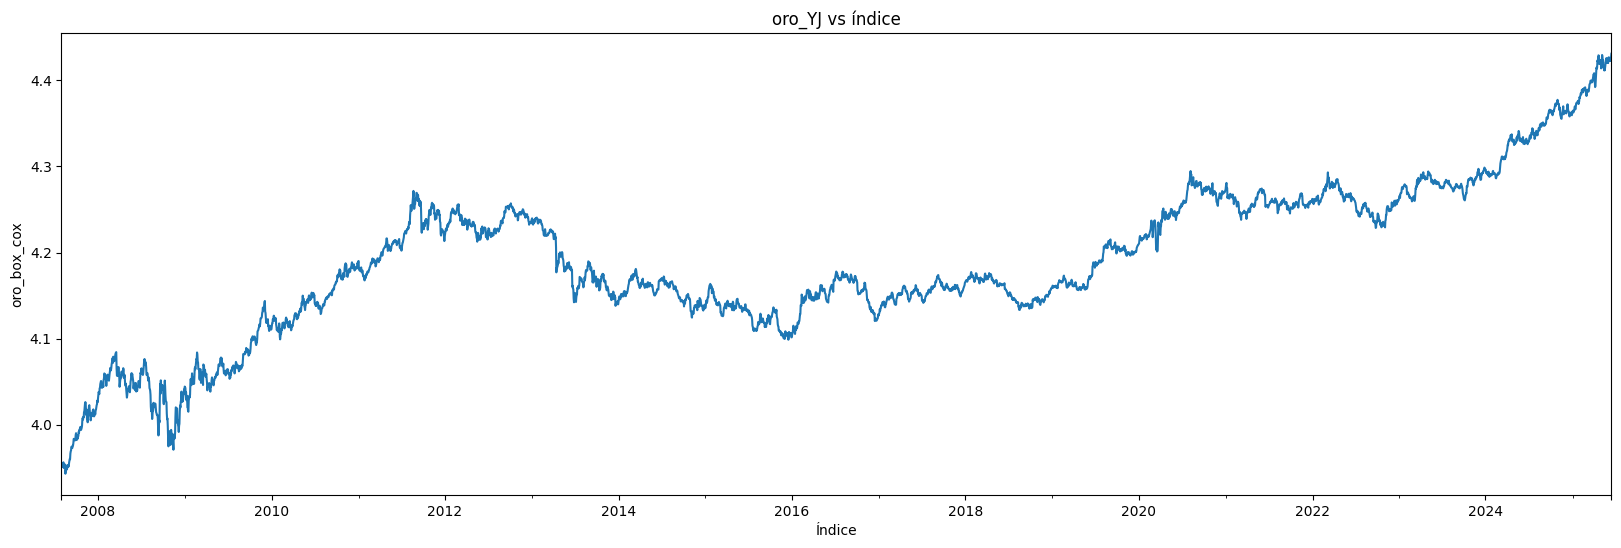

In [27]:
df_oro_final['oro_yj'].plot(figsize=(20,6))
plt.xlabel('Índice')
plt.ylabel('oro_box_cox')
plt.title('oro_YJ vs índice')
plt.show()

In [28]:
df_oro_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4664 entries, 2007-07-31 to 2025-06-13
Freq: B
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   kgc             4664 non-null   float64
 1   aem             4664 non-null   float64
 2   nem             4664 non-null   float64
 3   paas            4664 non-null   float64
 4   wpm             4664 non-null   float64
 5   ag              4664 non-null   float64
 6   fcx             4664 non-null   float64
 7   tasa_5y         4664 non-null   float64
 8   vix             4664 non-null   float64
 9   bhp             4664 non-null   float64
 10  emergentes      4664 non-null   float64
 11  shel            4664 non-null   float64
 12  dxy_fut         4664 non-null   float64
 13  desempleo_ita   4664 non-null   float64
 14  ctra            4664 non-null   float64
 15  eqt             4664 non-null   float64
 16  petroleo_brent  4664 non-null   float64
 17  amd    

## Análisis de Plata

### Test de Normalidad -Shapiro Wilk

In [29]:
# === TEST DE SHAPIRO-WILK ===
print("=" * 70)
print("TEST DE SHAPIRO-WILK (Normalidad)")
print("=" * 70)
shapiro_stat, shapiro_p = stats.shapiro(df_train['plata'].dropna())
print(f"Shapiro Statistic: {shapiro_stat:.4f}")
print(f"p-value: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("H0: No se rechaza - distribución normal")
    
else:
    print("H0: Se rechaza hipotesis nula - datos no presentan distribución normal")

TEST DE SHAPIRO-WILK (Normalidad)
Shapiro Statistic: 0.9310
p-value: 0.0000
H0: Se rechaza hipotesis nula - datos no presentan distribución normal


#### Producto de que no se comporta de forma normal, se recomiendo transformar, probamos con BoxCox primero

In [30]:
transformacion, lambda_opt = boxcox(df_train['plata'])
print(f"Lambda óptimo: {lambda_opt:.4f}") 

Lambda óptimo: -0.3737


BoxCox no maneja negativos, así que provamos con lambda de YEO-JOHNSON

In [31]:
transformacion, lambda_opt_plata = yeojohnson(df_train['plata'])
print(f"Lambda óptimo: {lambda_opt_plata:.4f}")   

Lambda óptimo: -0.4414


In [32]:
df_plata=df_train.copy()

In [33]:
df_plata['plata_yj'] = yeojohnson(df_plata['plata'], lmbda=lambda_opt_plata)

## Análisis de Descomposición

El modelo multiplicativo es más adecuado (CV menor).


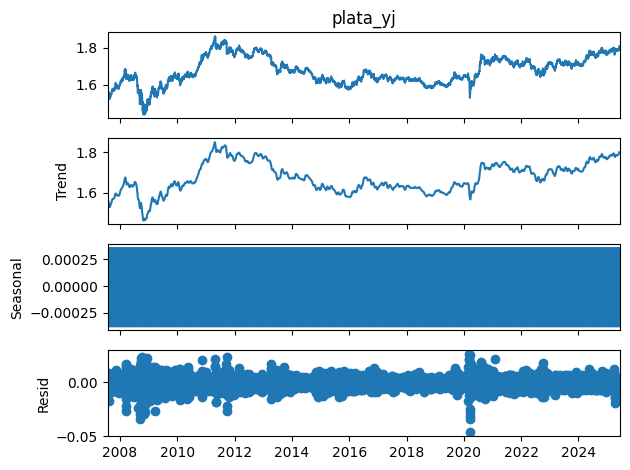

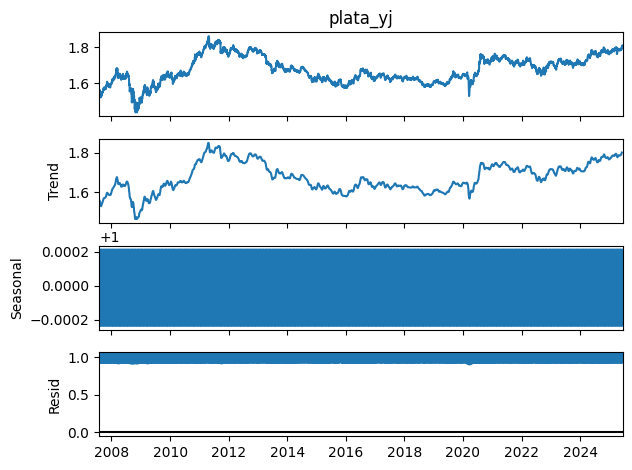

In [34]:
decompose_add = seasonal_decompose(df_plata['plata_yj'] , model='additive', period=12)
decompose_mult = seasonal_decompose(df_plata['plata_yj'] , model='multiplicative', period=12)

decompose_add.plot()
decompose_mult.plot()


seasonal_add = decompose_add.seasonal
seasonal_mult = decompose_mult.seasonal

cv_add = variation(seasonal_add.dropna())
cv_mult = variation(seasonal_mult.dropna()) 
if cv_add < cv_mult:
    print("El modelo aditivo es más adecuado (CV menor).")
elif cv_add > cv_mult:
    print("El modelo multiplicativo es más adecuado (CV menor).")
else:
    print("Ambos modelos tienen el mismo CV.")

Análisis Multiplicativo, nos da una inferencia que podríamos deber ocupar modelos estacionales (sarimax, sarima)

In [35]:
series_to_test = df_plata['plata_yj'].dropna()

#ADF
adf_stat, adf_pval, adf_lags, adf_nobs, adf_crit, _ = adfuller(series_to_test)
print(f"ADF Statistic : {adf_stat:.4f}")
print(f"ADF p-value   : {adf_pval:.4g}")
print("»", "Estacionaria" if adf_pval < 0.05 else "NO estacionaria", "según ADF")

#KPSS
kpss_stat, kpss_pval, kpss_lags, kpss_crit = kpss(series_to_test, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat:.4f}")
print(f"KPSS p-value  : {kpss_pval:.4g}")
print("»", "Estacionaria" if kpss_pval > 0.05 else "NO estacionaria", "según KPSS")

tests_df = pd.DataFrame([
    {
        "serie": "Plata_JY",
        "test": "ADF",
        "stat": adf_stat,
        "p_value": adf_pval,
        "lags_usados": adf_lags,
        "n_observaciones": adf_nobs,
        "crit_1%": adf_crit.get("1%"),
        "crit_5%": adf_crit.get("5%"),
        "crit_10%": adf_crit.get("10%"),
        "estacionaria": adf_pval < 0.05  # criterio ADF
    },
    {
        "serie": "Plata_JY",
        "test": "KPSS (c)",
        "stat": kpss_stat,
        "p_value": kpss_pval,
        "lags_usados": kpss_lags,
        "n_observaciones": series_to_test.shape[0],
        "crit_1%": float(kpss_crit.get("1%")),
        "crit_5%": float(kpss_crit.get("5%")),
        "crit_10%": float(kpss_crit.get("10%")),
        "estacionaria": kpss_pval > 0.05  # criterio KPSS
    }
])

ts_tests_mensual = tests_df

print(ts_tests_mensual)

ADF Statistic : -2.2596
ADF p-value   : 0.1853
» NO estacionaria según ADF
KPSS Statistic: 1.4161
KPSS p-value  : 0.01
» NO estacionaria según KPSS
      serie      test      stat  p_value  lags_usados  n_observaciones  \
0  Plata_JY       ADF -2.259614 0.185324            0             4664   
1  Plata_JY  KPSS (c)  1.416121 0.010000           41             4665   

    crit_1%   crit_5%  crit_10%  estacionaria  
0 -3.431753 -2.862160 -2.567100         False  
1  0.739000  0.463000  0.347000         False  


Producto de que no es estacionaria en ADF, se procede a diferenciar

In [36]:
df_plata['plata_yj_dif']=df_plata['plata_yj'].diff()

In [37]:
series_to_test_dif = df_plata['plata_yj_dif'].dropna()

#ADF
adf_stat_dif, adf_pval_dif, adf_lags_dif, adf_nobs_dif, adf_crit_dif, _ = adfuller(series_to_test_dif)
print(f"ADF Statistic : {adf_stat_dif:.4f}")
print(f"ADF p-value   : {adf_pval_dif:.4g}")
print("»", "Estacionaria" if adf_pval_dif < 0.05 else "NO estacionaria", "según ADF")

#KPSS
kpss_stat_dif, kpss_pval_dif, kpss_lags_dif, kpss_crit_dif = kpss(series_to_test_dif,regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat_dif:.4f}")
print(f"KPSS p-value  : {kpss_pval_dif:.4g}")
print("»", "Estacionaria" if kpss_pval_dif > 0.05 else "NO estacionaria", "según KPSS")

tests_df_dif = pd.DataFrame([
    {
        "serie": "Plata_JY_dif",
        "test": "ADF",
        "stat": adf_stat_dif,
        "p_value": adf_pval_dif,
        "lags_usados": adf_lags_dif,
        "n_observaciones": adf_nobs_dif,
        "crit_1%": adf_crit_dif.get("1%"),
        "crit_5%": adf_crit_dif.get("5%"),
        "crit_10%": adf_crit_dif.get("10%"),
        "estacionaria": adf_pval_dif < 0.05  # criterio ADF
    },
    {
        "serie": "Plata_JY_dif",
        "test": "KPSS (c)",
        "stat": kpss_stat_dif,
        "p_value": kpss_pval_dif,
        "lags_usados": kpss_lags_dif,
        "n_observaciones": series_to_test_dif.shape[0],
        "crit_1%": float(kpss_crit_dif.get("1%")),
        "crit_5%": float(kpss_crit_dif.get("5%")),
        "crit_10%": float(kpss_crit_dif.get("10%")),
        "estacionaria": kpss_pval_dif > 0.05  # criterio KPSS
    }
])

ts_tests_mensual_dif = tests_df_dif

print(ts_tests_mensual_dif)

ADF Statistic : -68.4636
ADF p-value   : 0
» Estacionaria según ADF
KPSS Statistic: 0.0681
KPSS p-value  : 0.1
» Estacionaria según KPSS
          serie      test       stat  p_value  lags_usados  n_observaciones  \
0  Plata_JY_dif       ADF -68.463590 0.000000            0             4663   
1  Plata_JY_dif  KPSS (c)   0.068097 0.100000           13             4664   

    crit_1%   crit_5%  crit_10%  estacionaria  
0 -3.431753 -2.862160 -2.567100          True  
1  0.739000  0.463000  0.347000          True  


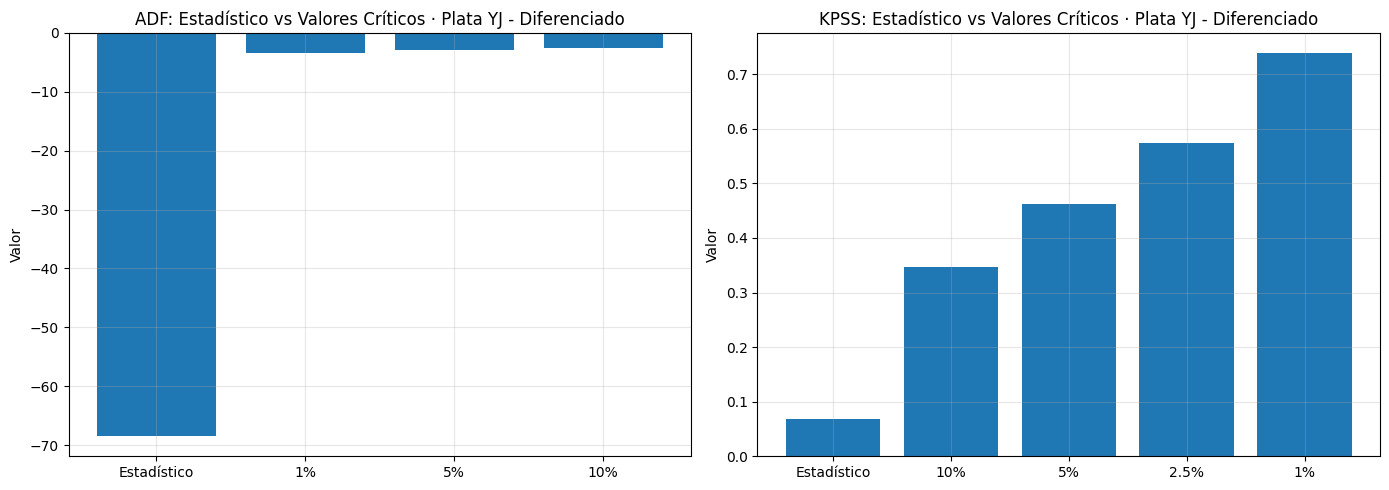

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ADF
axes[0].bar(['Estadístico'] + list(adf_crit_dif.keys()),
            [adf_stat_dif] + list(adf_crit_dif.values()))
axes[0].set_title("ADF: Estadístico vs Valores Críticos · Plata YJ - Diferenciado")
axes[0].set_ylabel("Valor"); axes[0].grid(alpha=.3)

# KPSS
axes[1].bar(['Estadístico'] + list(kpss_crit_dif.keys()),
            [kpss_stat_dif] + [float(k) for k in kpss_crit_dif.values()])
axes[1].set_title("KPSS: Estadístico vs Valores Críticos · Plata YJ - Diferenciado")
axes[1].set_ylabel("Valor"); axes[1].grid(alpha=.3)

plt.tight_layout(); plt.show()

In [39]:
df_cierre_mensual_dif_plata = df_plata.dropna(subset="plata_yj_dif")

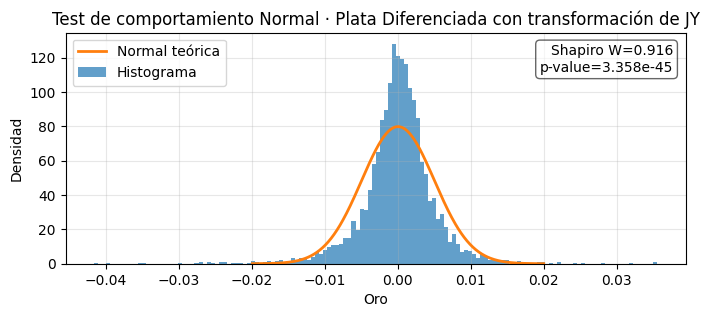

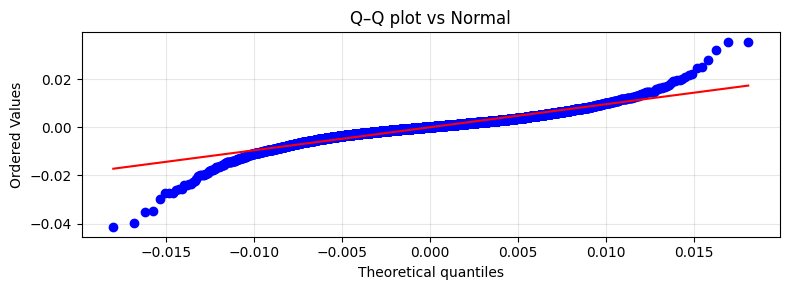

In [40]:
y = df_cierre_mensual_dif_plata["plata_yj_dif"]
sh_stat, sh_p = stats.shapiro(y)

mu, sigma = np.mean(y), np.std(y, ddof=1)
xs = np.linspace(mu - 4*sigma, mu + 4*sigma, 400)

#hist + curva teorica
plt.figure(figsize=(8,3))
plt.hist(y, bins='auto', density=True, alpha=0.7)
plt.plot(xs, stats.norm.pdf(xs, mu, sigma), linewidth=2)
plt.title("Test de comportamiento Normal · Plata Diferenciada con transformación de JY")
plt.xlabel("Oro")
plt.ylabel("Densidad")
plt.grid(alpha=.3)
plt.legend(["Normal teórica", "Histograma"], loc="best")
plt.annotate(f"Shapiro W={sh_stat:.3f}\np-value={sh_p:.4g}",
             xy=(0.98, 0.95), xycoords="axes fraction",
             ha="right", va="top",
             bbox=dict(boxstyle="round", fc="white", alpha=0.6))

# --- Q–Q plot ---
plt.figure(figsize=(8,3))
# Usamos la normal con media y sigma estimados
stats.probplot(y, dist="norm", sparams=(mu, sigma), plot=plt)
plt.title("Q–Q plot vs Normal")
plt.grid(alpha=.3)

plt.tight_layout()
plt.show()

## ACF - PACF

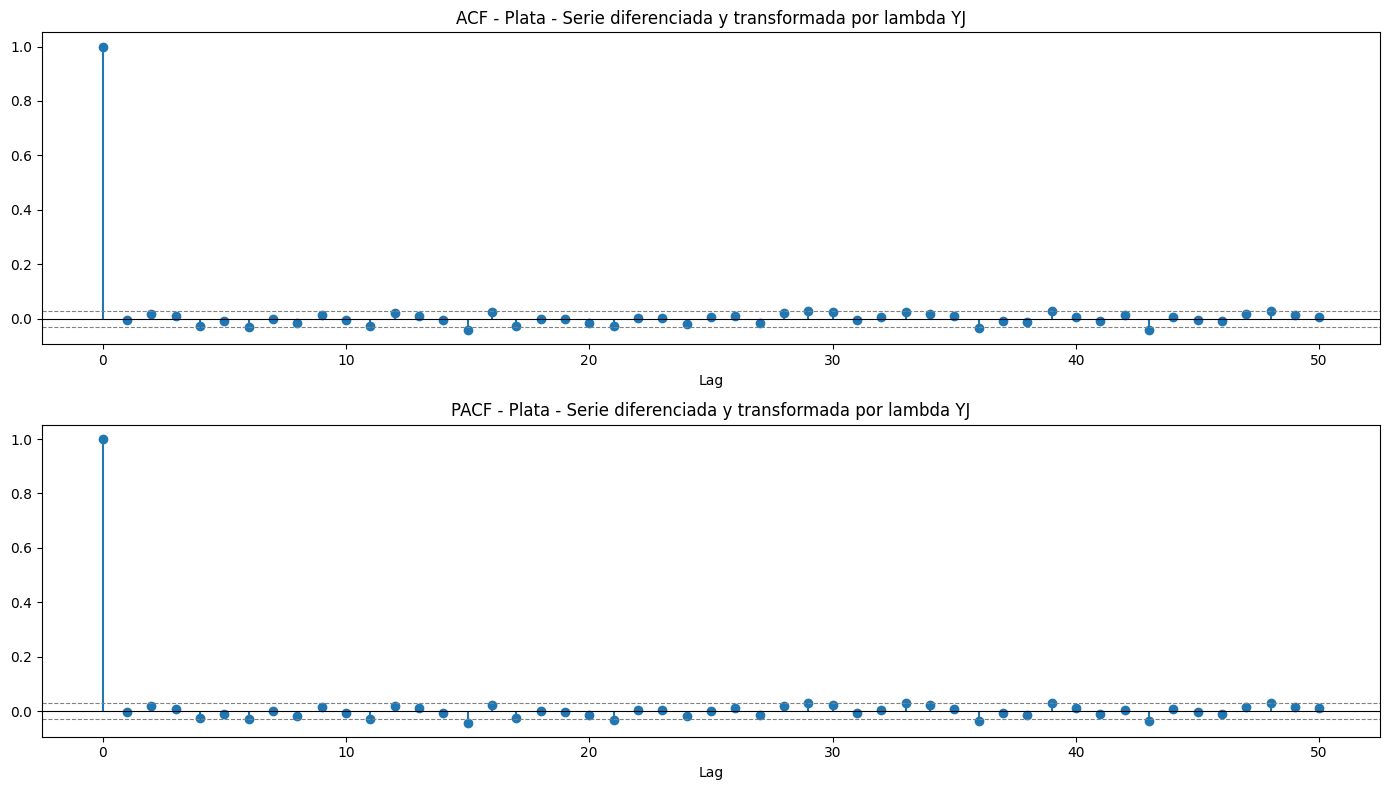

In [41]:
n = len(df_cierre_mensual_dif_plata)
nlags_acf  = min(50, n-1)
nlags_pacf = min(50, n-1)

pacf_monthly = pacf(df_cierre_mensual_dif_plata["plata_yj_dif"], nlags=nlags_pacf, method='ywmle')
acf_monthly = acf(df_cierre_mensual_dif_plata["plata_yj_dif"], nlags=nlags_acf)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
conf = 1.96 / np.sqrt(n)

axes[0].stem(range(len(acf_monthly)), acf_monthly, basefmt=' ')
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].axhline(conf, linestyle='--', color='gray', linewidth=0.8)
axes[0].axhline(-conf, linestyle='--', color='gray', linewidth=0.8)
axes[0].set_title('ACF - Plata - Serie diferenciada y transformada por lambda YJ')
axes[0].set_xlabel('Lag')

axes[1].stem(range(len(pacf_monthly)), pacf_monthly, basefmt=' ')
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].axhline(conf, linestyle='--', color='gray', linewidth=0.8)
axes[1].axhline(-conf, linestyle='--', color='gray', linewidth=0.8)
axes[1].set_title('PACF - Plata - Serie diferenciada y transformada por lambda YJ')
axes[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

- p = AR = 0 No hay corte abrupto en el PACF que indique un componente autorregresivo claro
- d = 1 
- q = 0 o 1
- Poca claridad para definir componentes MA no estacionales → probar entre 0 y 1
- s (estacionalidad):se recomienda probar una lista (probablemente entre 5,se repite la onda semanal)
- P (AR estacional):No se aprecian con claridad componentes autoregresivos estacionales en el PACF → probar P = [0,1] o buscar en base a lista
- Q (MA estacional)--> No claro, probar con [0,1]

## Análisis de Colinealidad y TEST de Granger

In [42]:
df_cierre_mensual_dif_plata.head(5)

petroleo_brent        oro    cobre  gas_natural     plata  \
FECHA                                                                   
2007-07-31       77.050003 666.900024 3.653500     6.191000 12.950000   
2007-08-01       75.349998 663.599976 3.595000     6.352000 12.888000   
2007-08-02       75.760002 664.599976 3.575000     6.106000 12.935000   
2007-08-03       74.750000 672.500000 3.484500     6.090000 13.100000   
2007-08-06       71.169998 671.500000 3.478500     6.208000 12.977000   

              shanghai   dxy_fut  emergentes        ftse         dax  \
FECHA                                                                  
2007-07-31 4471.032227 80.660004   30.161293 6360.100098 7584.140137   
2007-08-01 4300.562988 80.750000   30.042988 6250.600098 7473.930176   
2007-08-02 4407.729980 80.605003   30.375154 6300.299805 7534.129883   
2007-08-03 4560.773926 80.059998   29.064692 6224.299805 7435.669922   
2007-08-06 4628.107910 80.139999   29.583418 6189.100098 7444.450195   

                 sp500       nikkei       vix     aapl       amd     amzn  \
FECHA                                                                       
2007-07-31 1455.270020 17248.890625 23.520000 3.955451 13.540000 3.927000   
2007-08-01 1465.810059 16870.980469 23.670000 4.052715 13.410000 3.865500   
2007-08-02 1472.199951 16984.109375 21.219999 4.097445 13.400000 3.985500   
2007-08-03 1433.060059 16979.859375 25.160000 3.958153 12.850000 3.840000   
2007-08-06 1467.670044 16914.460938 22.940001 4.060220 12.770000 3.950000   

                brkb       dia     googl       jpm      msft     nvda  \
FECHA                                                                   
2007-07-31 72.080002 87.783852 12.675341 27.574377 20.683052 0.699278   
2007-08-01 71.989998 88.607460 12.748410 27.806208 20.904226 0.694082   
2007-08-02 71.760002 89.517319 12.700442 27.937784 21.061186 0.691027   
2007-08-03 71.980003 87.797180 12.501364 27.348841 20.661659 0.650072   
2007-08-06 73.400002 89.132179 12.675341 28.263584 21.075455 0.655573   

                 qqq        spy      tsm       unh       aem       ag  \
FECHA                                                                   
2007-07-31 40.920063 103.608269 5.743544 37.946964 32.626858 4.245691   
2007-08-01 41.238602 104.113113 5.624711 37.602203 32.028625 4.443165   
2007-08-02 41.617428 104.944954 5.715251 37.892117 32.427448 4.403671   
2007-08-03 40.825371 102.243141 5.488904 37.218266 32.887638 4.176576   
2007-08-06 41.298885 103.956657 5.669982 38.001789 31.798540 4.176576   

                 bhp     ctra       cvx       eqt       fcx       kgc  \
FECHA                                                                   
2007-07-31 22.847242 6.124954 41.891644 21.234945 32.836269 11.177741   
2007-08-01 22.381550 6.182264 41.847416 21.987703 31.361826 10.884951   
2007-08-02 22.542746 6.185846 41.218510 22.456480 31.641344 10.850503   
2007-08-03 21.754663 5.945861 39.808342 21.897556 30.096992 10.928005   
2007-08-06 22.037655 5.877806 40.299683 22.235619 29.862906 10.824667   

                 lng       nem      paas      scco      shel       wpm  \
FECHA                                                                    
2007-07-31 36.143723 28.910706 21.549908 17.108156 30.477816 11.346232   
2007-08-01 34.750614 28.799919 21.255020 16.435724 30.684004 11.155883   
2007-08-02 35.000412 28.896852 21.681824 16.239923 30.343010 11.230366   
2007-08-03 34.875511 28.322113 22.100878 15.385344 29.506428 10.965541   
2007-08-06 33.280655 28.155912 21.899113 15.083283 30.105116 10.750366   

                 xom  dolar_index  tasa_10y  tasa_2y  tasa_5y      pib_usa  \
FECHA                                                                        
2007-07-31 44.734661    93.426400  4.780000 4.560000 4.600000 14215.651000   
2007-08-01 45.107727    93.401100  4.760000 4.560000 4.600000 14215.651000   
2007-08-02 44.760944    93.303800  4.770000 4.590000 4.620000 14215.651000   
2007-08-03

In [43]:
target = "plata_yj_dif"
num_cols = df_cierre_mensual_dif_plata.select_dtypes(include=[np.number]).columns.drop(target, errors="ignore")

#Calcular Granger F para todas
granger_scores = []
for col in num_cols:
    data = df_cierre_mensual_dif_plata[[target, col]].dropna()
    if len(data) < 10:
        continue
    try:
        results = grangercausalitytests(data, maxlag=3, verbose=False)
        #Máximo F-stat entre todos los lags
        max_f = max([results[lag][0]['ssr_ftest'][0] for lag in results.keys()])
        granger_scores.append({'variable': col, 'Granger_F': max_f})
    except:
        continue

granger_df = pd.DataFrame(granger_scores).sort_values('Granger_F', ascending=False)

#Eliminar multicolinealidad (corr > 0.85)
vars_list = granger_df['variable'].tolist()
corr_matrix = df_cierre_mensual_dif_plata[vars_list].corr()

variables_a_eliminar = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
            f1 = granger_df[granger_df['variable'] == var1]['Granger_F'].values[0]
            f2 = granger_df[granger_df['variable'] == var2]['Granger_F'].values[0]
            
            #Eliminar la de MENOR Granger F (peor causalidad)
            variables_a_eliminar.add(var2 if f1 > f2 else var1)

top = granger_df[~granger_df['variable'].isin(variables_a_eliminar)] 
lista_variables_plata=top['variable'].tolist()+list([target])
lista_variables_plata_test=top['variable'].tolist()
lista_variables_plata_test.remove("plata_yj")             
top

variable  Granger_F
33             kgc 105.092102
26             aem  83.259084
36            paas  76.277370
35             nem  75.172922
39             wpm  44.503036
7       emergentes  39.774252
32             fcx  37.895430
12             vix  34.780651
27              ag  33.245088
38            shel  31.613642
28             bhp  30.196610
10           sp500  15.922528
0   petroleo_brent  11.519361
29            ctra   9.629027
31             eqt   9.109690
6          dxy_fut   8.852601
57   desempleo_can   8.707335
52   desempleo_usa   7.223793
69        plata_yj   5.027983
58   desempleo_ita   2.741071
44         tasa_5y   2.596614
56   desempleo_jpn   1.874226
3      gas_natural   1.857718
48         pib_gbr   1.741727
54   desempleo_fra   1.127138
5         shanghai   1.100110
50         pib_ita   0.231302

In [44]:
df_plata_final=df_cierre_mensual_dif_plata[lista_variables_plata] 

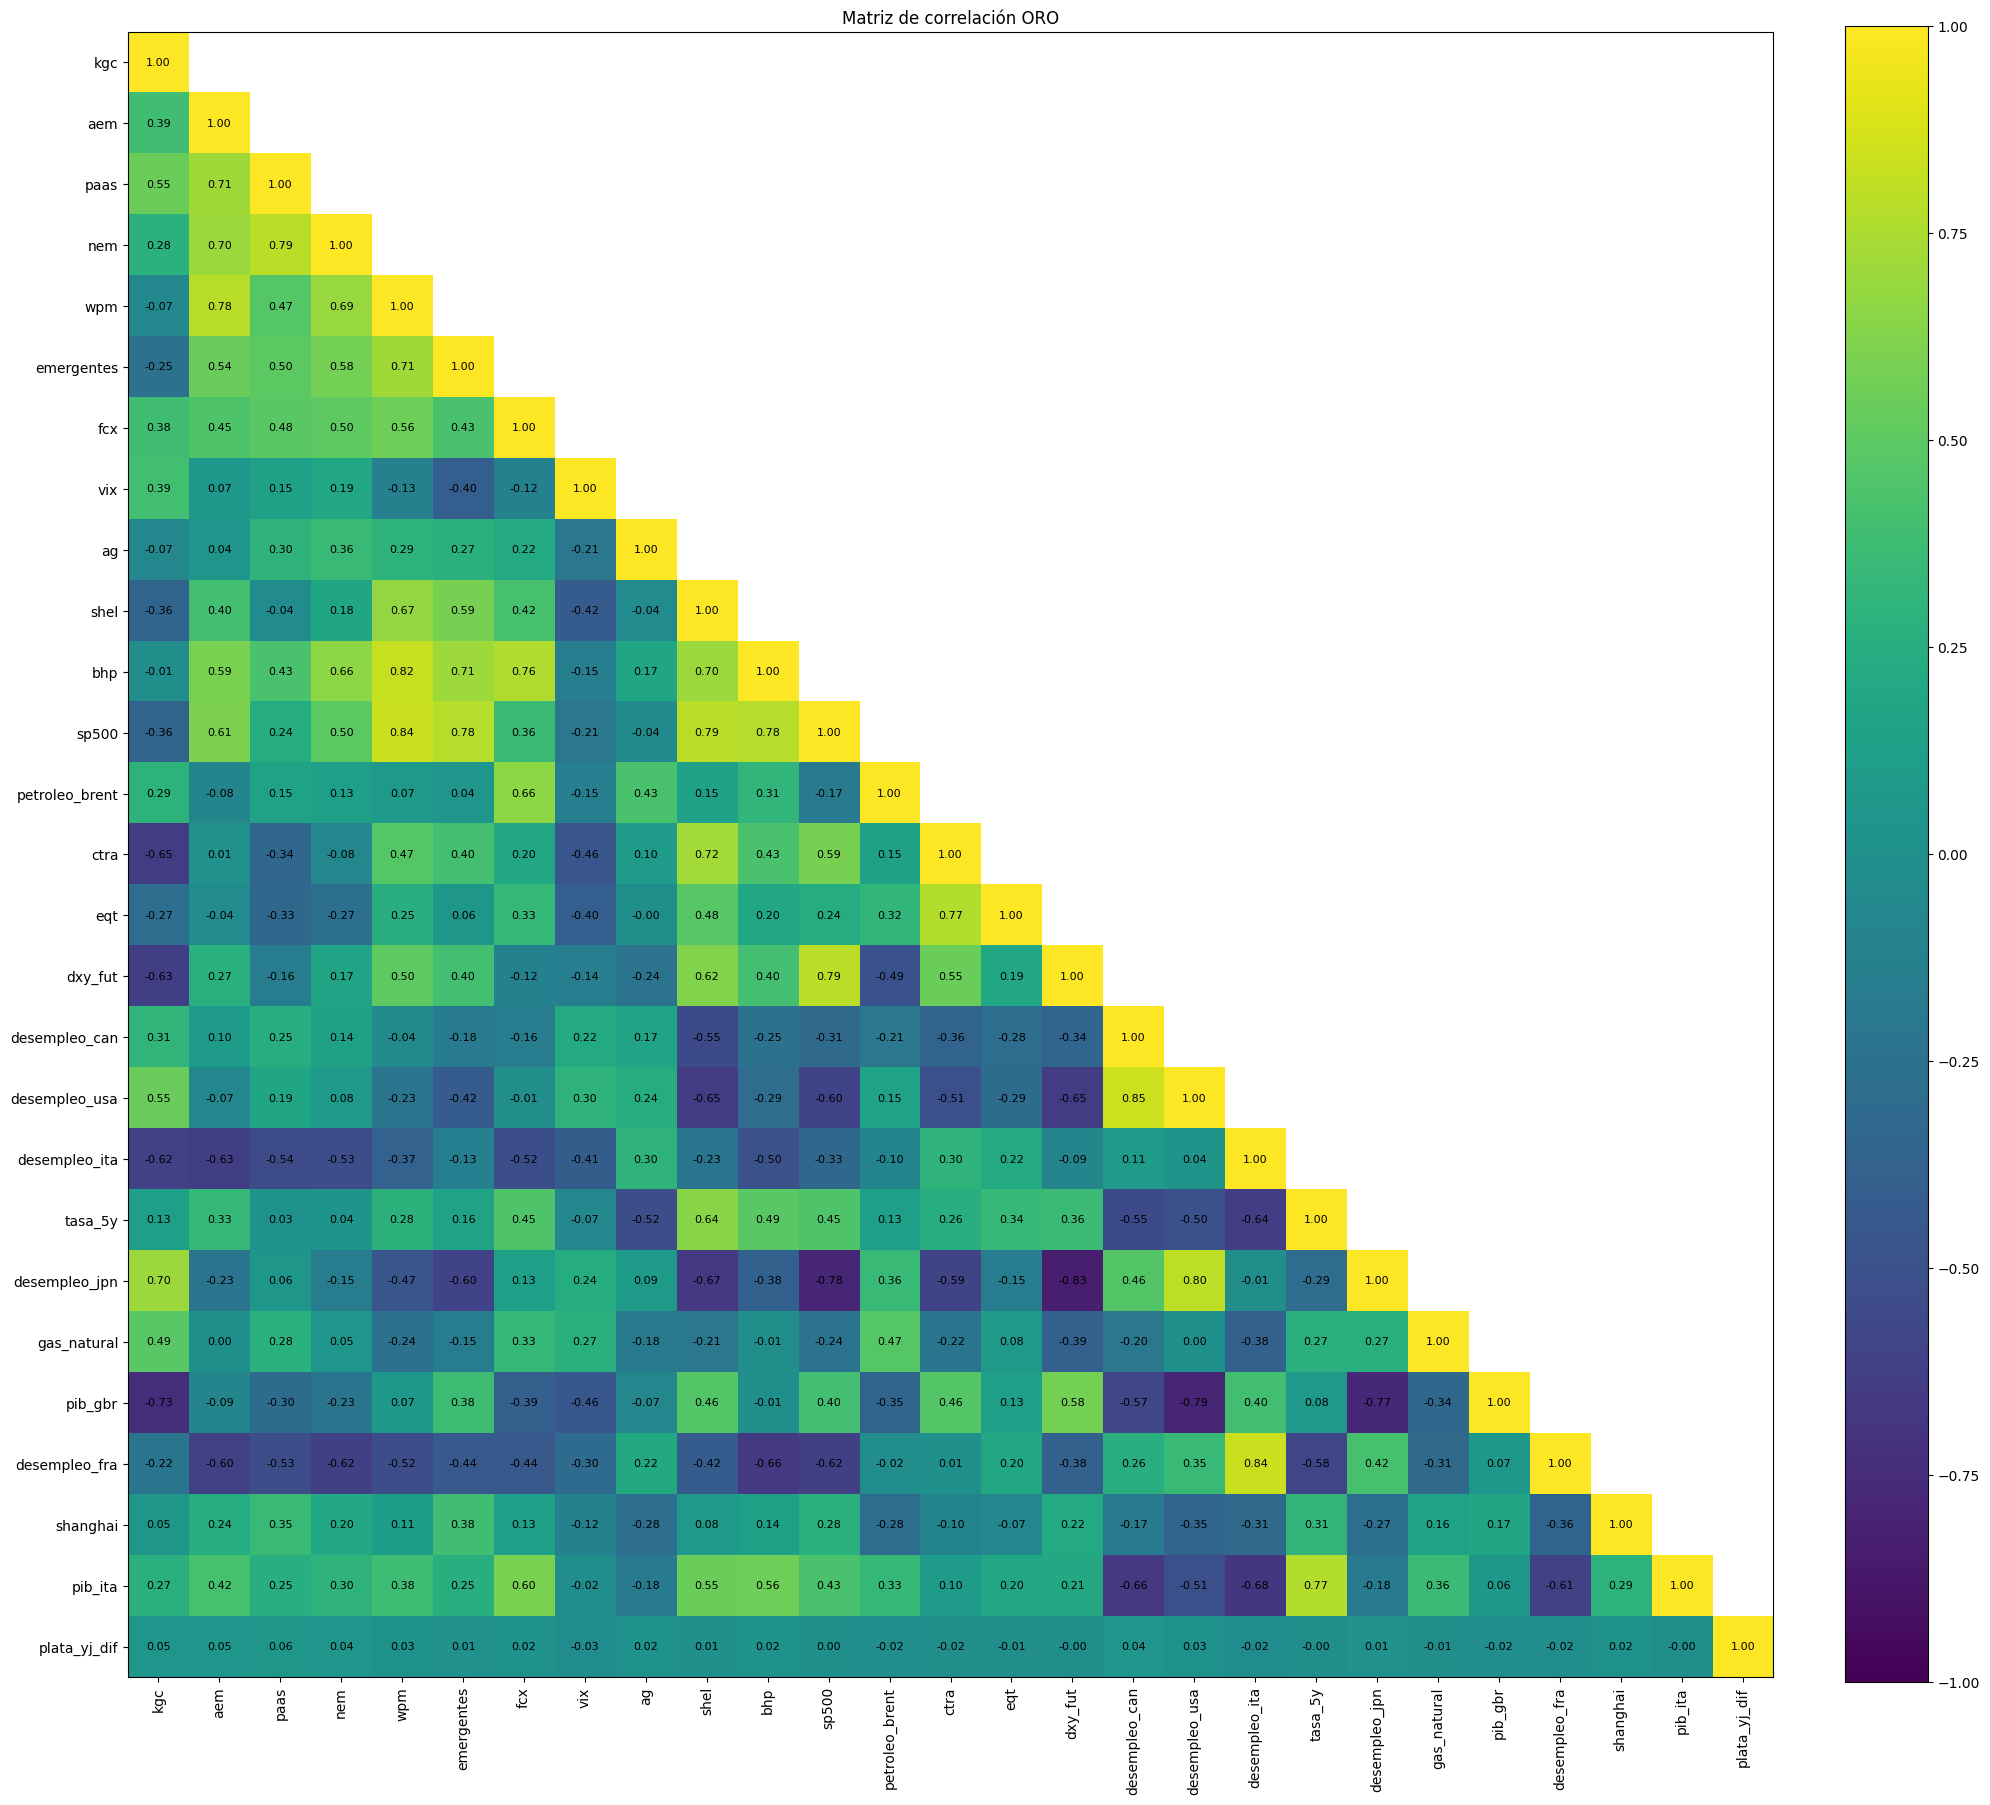

In [45]:
num_cols = (
    df_plata_final.drop(columns="plata_yj")
    .select_dtypes(include="number")
    .drop(columns=["fecha"], errors="ignore")
)

corr = num_cols.corr()

M = corr.values.copy()
mask = np.triu(np.ones_like(M, dtype=bool), k=1)
M_masked = M.copy()
M_masked[mask] = np.nan

plt.figure(figsize=(20, 20))
im = plt.imshow(M_masked, vmin=-1, vmax=1)  # sin cmap explícito
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        if not mask[i, j] and not np.isnan(M_masked[i, j]):
            plt.text(j, i, f"{M[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.title("Matriz de correlación ORO")
plt.tight_layout()
plt.show()

## Test de Causalidad de Granger

In [46]:
exclude_cols = ["plata","plata_yj"]
features = df_oro_final.drop(columns=exclude_cols, errors="ignore").select_dtypes(include=['float64', 'int64']).columns

max_lag = 7
results = []

for col in features:
    try:
        data = df_plata_final[[col, "plata_yj_dif"]].dropna()
        
        if len(data) > max_lag + 1:
            test = grangercausalitytests(data[["plata_yj_dif", col]], max_lag, verbose=False)
            row = {'Feature': col}
            for lag in range(1, max_lag + 1):
                p_val = test[lag][0]['ssr_ftest'][1]
                row[f'P_Value_Lag{lag}'] = p_val
                row[f'Significant_Lag{lag}'] = p_val < 0.05
            
            results.append(row)
    except:
        continue
granger_df = pd.DataFrame(results)
granger_df['Min_P_Value'] = granger_df[['P_Value_Lag1', 'P_Value_Lag2', 'P_Value_Lag3']].min(axis=1)
granger_df_plata = granger_df.sort_values('Min_P_Value').reset_index(drop=True)

granger_df_plata.head(40)

Feature  P_Value_Lag1  Significant_Lag1  P_Value_Lag2  \
0              kgc      0.204014             False      0.000000   
1              aem      0.236048             False      0.000000   
2             paas      0.664755             False      0.000000   
3              nem      0.646004             False      0.000000   
4              wpm      0.810828             False      0.000000   
5       emergentes      0.685513             False      0.000000   
6              fcx      0.795681             False      0.000000   
7              vix      0.937305             False      0.000000   
8               ag      0.262735             False      0.000000   
9             shel      0.682766             False      0.000000   
10             bhp      0.995823             False      0.000000   
11  petroleo_brent      0.010112              True      0.000010   
12            ctra      0.126049             False      0.000067   
13             eqt      0.149048             False      0.000113   
14         dxy_fut      0.386056             False      0.000145   
15   desempleo_can      0.004347              True      0.000168   
16   desempleo_usa      0.040662              True      0.000737   
17         tasa_5y      0.936765             False      0.268709   
18   desempleo_ita      0.097867             False      0.125126   
19   desempleo_jpn      0.395889             False      0.435507   
20         pib_gbr      0.186985             False      0.181601   
21   desempleo_fra      0.288442             False      0.348976   

    Significant_Lag2  P_Value_Lag3  Significant_Lag3  P_Value_Lag4  \
0               True      0.000000              True      0.000000   
1               True      0.000000              True      0.000000   
2               True      0.000000              True      0.000000   
3               True      0.000000              True      0.000000   
4               True      0.000000              True      0.000000   
5               True      0.000000              True      0.000000   
6               True      0.000000              True      0.000000   
7               True      0.000000              True      0.000000   
8               True      0.000000              True      0.000000   
9               True      0.000000              True      0.000000   
10              True      0.000000              True      0.000000   
11              True      0.000001              True      0.000003   
12              True      0.000009              True      0.000027   
13              True      0.000062              True      0.000208   
14              True      0.000509              True      0.000579   
15              True      0.000479              True      0.000251   
16              True      0.001824              True      0.000496   
17             False      0.050689             False      0.111292   
18             False      0.163914             False      0.071650   
19             False      0.131641             False      0.027305   
20             False      0.239744             False      0.139346   
21             False      0.445227             False      0.407131   

    Significant_Lag4  P_Value_Lag5  Significant_Lag5  P_Value_Lag6  \
0               True      0.000000              True      0.000000   
1               True      0.000000              True      0.000000   
2               True      0.000000              True      0.000000   
3               True      0.000000              True      0.000000   
4               True      0.000000              True      0.000000   
5               True      0.000000              True      0.000000   
6               True      0.000000              True      0.000000   
7               True      0.000000              True      0.000000   
8               True      0.000000              True      0.000000   
9               True      0.000000              True      0.000000   
10              True      0.000000              True      0.00000

In [47]:
sig_cols = [c for c in granger_df_plata.columns if c.lower().startswith('significant_lag')]
granger_df_plata["granger_test"] = granger_df_plata[sig_cols].any(axis=1).astype(int) 

granger_df_plata=list(granger_df_plata[granger_df_plata["granger_test"]==1]["Feature"])+["plata_yj"]
df_plata_final=df_plata_final[granger_df_plata]

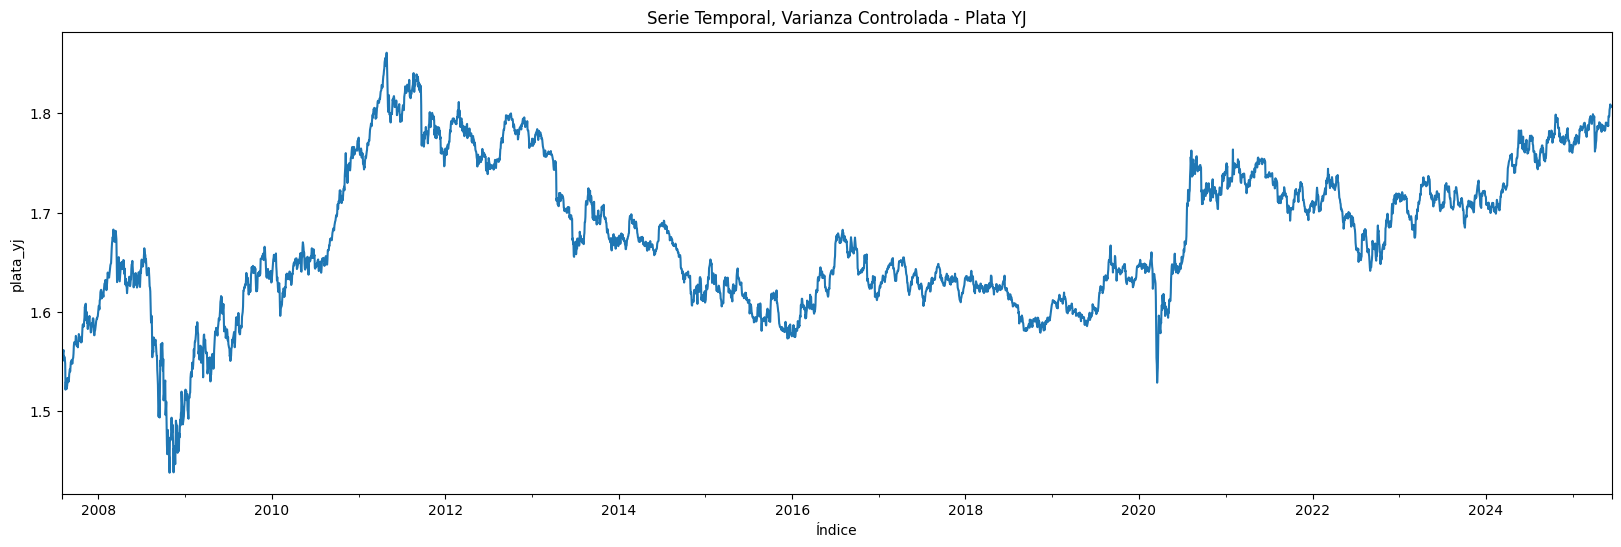

In [48]:
df_plata_final['plata_yj'].plot(figsize=(20,6))
plt.xlabel('Índice')
plt.ylabel('plata_yj')
plt.title('Serie Temporal, Varianza Controlada - Plata YJ')
plt.show()

* Claramente tiene componentes estacionales, la gráfica se tiende a repetir --> parece ser que tiene un comportamiento similar durante 2 años cada 10 años

## Análisis del Cobre

### Test de Shapiro - Wilk

In [49]:
df_cobre=df_train.copy()
# === TEST DE SHAPIRO-WILK ===
print("=" * 70)
print("TEST DE SHAPIRO-WILK (Normalidad)")
print("=" * 70)
shapiro_stat, shapiro_p = stats.shapiro(df_cobre['cobre'].dropna())
print(f"Shapiro Statistic: {shapiro_stat:.4f}")
print(f"p-value: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("H0: No se rechaza - distribución normal")
    
else:
    print("H0: Se rechaza hipotesis nula - datos no presentan distribución normal")

TEST DE SHAPIRO-WILK (Normalidad)
Shapiro Statistic: 0.9923
p-value: 0.0000
H0: Se rechaza hipotesis nula - datos no presentan distribución normal


## Trnasformación de Boxcox

In [50]:
transformacion, lambda_opt_cobre = boxcox(df_cobre['cobre'])
print(f"Lambda óptimo: {lambda_opt_cobre:.4f}") 

Lambda óptimo: 0.9855


In [51]:
df_cobre['cobre_yj'] = yeojohnson(df_cobre['cobre'], lmbda=lambda_opt_cobre)

## Análisis de Descomposición

El modelo multiplicativo es más adecuado (CV menor).


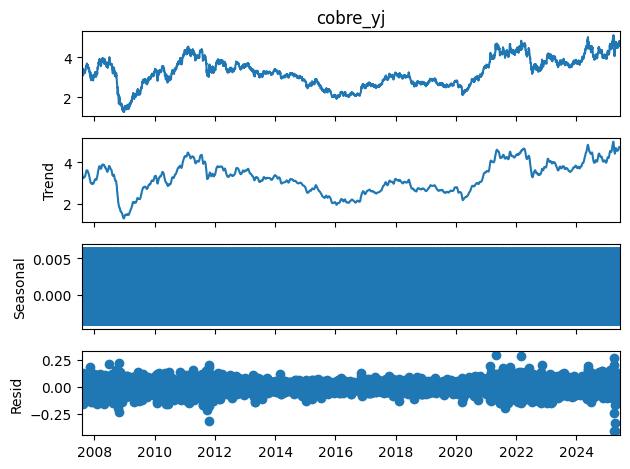

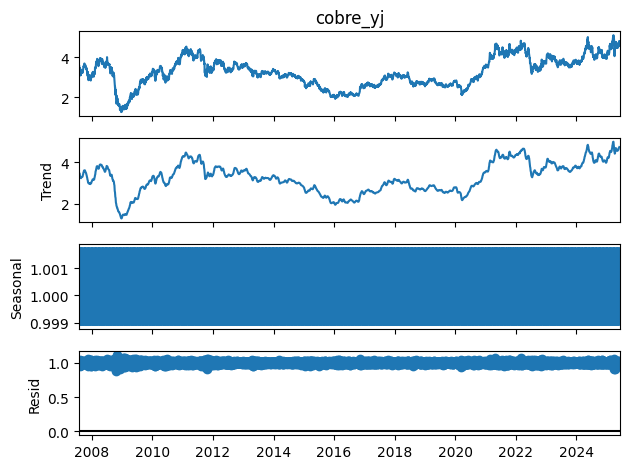

In [52]:
decompose_add = seasonal_decompose(df_cobre['cobre_yj'] , model='additive', period=12)
decompose_mult = seasonal_decompose(df_cobre['cobre_yj'] , model='multiplicative', period=12)

decompose_add.plot()
decompose_mult.plot()


seasonal_add = decompose_add.seasonal
seasonal_mult = decompose_mult.seasonal

cv_add = variation(seasonal_add.dropna())
cv_mult = variation(seasonal_mult.dropna()) 
if cv_add < cv_mult:
    print("El modelo aditivo es más adecuado (CV menor).")
elif cv_add > cv_mult:
    print("El modelo multiplicativo es más adecuado (CV menor).")
else:
    print("Ambos modelos tienen el mismo CV.")

### Analisis de ADF - KPSS

In [53]:
series_to_test = df_cobre['cobre_yj'].dropna()

#ADF
adf_stat, adf_pval, adf_lags, adf_nobs, adf_crit, _ = adfuller(series_to_test)
print(f"ADF Statistic : {adf_stat:.4f}")
print(f"ADF p-value   : {adf_pval:.4g}")
print("»", "Estacionaria" if adf_pval < 0.05 else "NO estacionaria", "según ADF")

#KPSS
kpss_stat, kpss_pval, kpss_lags, kpss_crit = kpss(series_to_test, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat:.4f}")
print(f"KPSS p-value  : {kpss_pval:.4g}")
print("»", "Estacionaria" if kpss_pval > 0.05 else "NO estacionaria", "según KPSS")

tests_df = pd.DataFrame([
    {
        "serie": "cobre_yj",
        "test": "ADF",
        "stat": adf_stat,
        "p_value": adf_pval,
        "lags_usados": adf_lags,
        "n_observaciones": adf_nobs,
        "crit_1%": adf_crit.get("1%"),
        "crit_5%": adf_crit.get("5%"),
        "crit_10%": adf_crit.get("10%"),
        "estacionaria": adf_pval < 0.05  # criterio ADF
    },
    {
        "serie": "cobre_yj",
        "test": "KPSS (c)",
        "stat": kpss_stat,
        "p_value": kpss_pval,
        "lags_usados": kpss_lags,
        "n_observaciones": series_to_test.shape[0],
        "crit_1%": float(kpss_crit.get("1%")),
        "crit_5%": float(kpss_crit.get("5%")),
        "crit_10%": float(kpss_crit.get("10%")),
        "estacionaria": kpss_pval > 0.05  # criterio KPSS
    }
])

ts_tests_mensual = tests_df

print(ts_tests_mensual)

ADF Statistic : -1.9682
ADF p-value   : 0.3007
» NO estacionaria según ADF
KPSS Statistic: 2.1257
KPSS p-value  : 0.01
» NO estacionaria según KPSS
      serie      test      stat  p_value  lags_usados  n_observaciones  \
0  cobre_yj       ADF -1.968216 0.300681            0             4664   
1  cobre_yj  KPSS (c)  2.125691 0.010000           41             4665   

    crit_1%   crit_5%  crit_10%  estacionaria  
0 -3.431753 -2.862160 -2.567100         False  
1  0.739000  0.463000  0.347000         False  


* Producto de no representar comportamiento estacionario en ADF ni KPSS, Se opta por diferenciar

In [54]:
df_cobre['cobre_yj_dif']=df_cobre['cobre_yj'].diff() 
df_cobre=df_cobre.dropna(subset="cobre_yj_dif")

In [55]:
series_to_test_dif = df_cobre['cobre_yj_dif'].dropna()

#ADF
adf_stat_dif, adf_pval_dif, adf_lags_dif, adf_nobs_dif, adf_crit_dif, _ = adfuller(series_to_test_dif)
print(f"ADF Statistic : {adf_stat_dif:.4f}")
print(f"ADF p-value   : {adf_pval_dif:.4g}")
print("»", "Estacionaria" if adf_pval_dif < 0.05 else "NO estacionaria", "según ADF")

#KPSS
kpss_stat_dif, kpss_pval_dif, kpss_lags_dif, kpss_crit_dif = kpss(series_to_test_dif, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat_dif:.4f}")
print(f"KPSS p-value  : {kpss_pval_dif:.4g}")
print("»", "Estacionaria" if kpss_pval_dif > 0.05 else "NO estacionaria", "según KPSS")

tests_df_dif = pd.DataFrame([
    {
        "serie": "Cobre YJ diferenciado",
        "test": "ADF",
        "stat": adf_stat_dif,
        "p_value": adf_pval_dif,
        "lags_usados": adf_lags_dif,
        "n_observaciones": adf_nobs_dif,
        "crit_1%": adf_crit_dif.get("1%"),
        "crit_5%": adf_crit_dif.get("5%"),
        "crit_10%": adf_crit_dif.get("10%"),
        "estacionaria": adf_pval_dif < 0.05  # criterio ADF
    },
    {
        "serie": "Cobre YJ diferenciado",
        "test": "KPSS (c)",
        "stat": kpss_stat_dif,
        "p_value": kpss_pval_dif,
        "lags_usados": kpss_lags_dif,
        "n_observaciones": series_to_test_dif.shape[0],
        "crit_1%": float(kpss_crit_dif.get("1%")),
        "crit_5%": float(kpss_crit_dif.get("5%")),
        "crit_10%": float(kpss_crit_dif.get("10%")),
        "estacionaria": kpss_pval_dif > 0.05  # criterio KPSS
    }
])

ts_tests_mensual_dif = tests_df_dif

print(ts_tests_mensual_dif)

ADF Statistic : -69.5695
ADF p-value   : 0
» Estacionaria según ADF
KPSS Statistic: 0.1087
KPSS p-value  : 0.1
» Estacionaria según KPSS
                   serie      test       stat  p_value  lags_usados  \
0  Cobre YJ diferenciado       ADF -69.569492 0.000000            0   
1  Cobre YJ diferenciado  KPSS (c)   0.108728 0.100000            8   

   n_observaciones   crit_1%   crit_5%  crit_10%  estacionaria  
0             4663 -3.431753 -2.862160 -2.567100          True  
1             4664  0.739000  0.463000  0.347000          True  


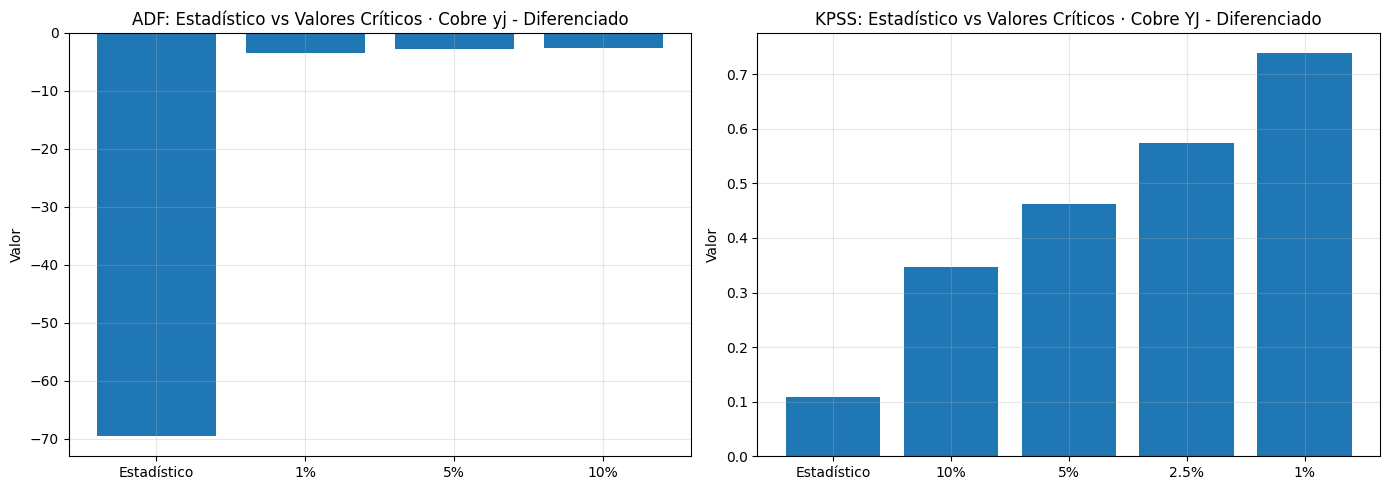

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ADF
axes[0].bar(['Estadístico'] + list(adf_crit_dif.keys()),
            [adf_stat_dif] + list(adf_crit_dif.values()))
axes[0].set_title("ADF: Estadístico vs Valores Críticos · Cobre yj - Diferenciado")
axes[0].set_ylabel("Valor"); axes[0].grid(alpha=.3)

# KPSS
axes[1].bar(['Estadístico'] + list(kpss_crit_dif.keys()),
            [kpss_stat_dif] + [float(k) for k in kpss_crit_dif.values()])
axes[1].set_title("KPSS: Estadístico vs Valores Críticos · Cobre YJ - Diferenciado")
axes[1].set_ylabel("Valor"); axes[1].grid(alpha=.3)

plt.tight_layout(); plt.show()

## Gráfica de Normalidad - Cobre diferenciado

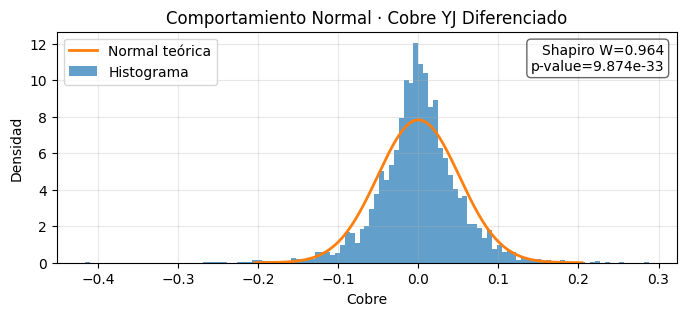

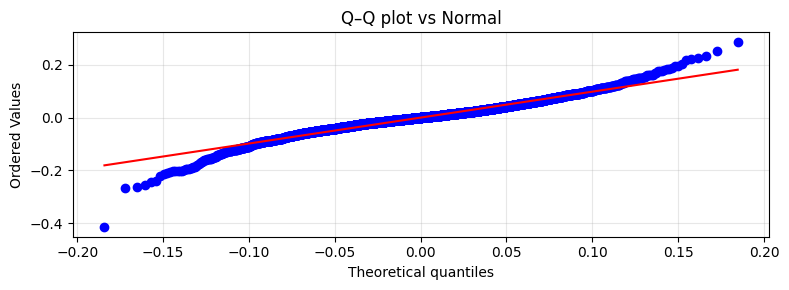

In [57]:
y = df_cobre['cobre_yj_dif']
sh_stat, sh_p = stats.shapiro(y)

mu, sigma = np.mean(y), np.std(y, ddof=1)
xs = np.linspace(mu - 4*sigma, mu + 4*sigma, 400)

#hist + curva teorica
plt.figure(figsize=(8,3))
plt.hist(y, bins='auto', density=True, alpha=0.7)
plt.plot(xs, stats.norm.pdf(xs, mu, sigma), linewidth=2)
plt.title("Comportamiento Normal · Cobre YJ Diferenciado")
plt.xlabel("Cobre")
plt.ylabel("Densidad")
plt.grid(alpha=.3)
plt.legend(["Normal teórica", "Histograma"], loc="best")
plt.annotate(f"Shapiro W={sh_stat:.3f}\np-value={sh_p:.4g}",
             xy=(0.98, 0.95), xycoords="axes fraction",
             ha="right", va="top",
             bbox=dict(boxstyle="round", fc="white", alpha=0.6))

# --- Q–Q plot ---
plt.figure(figsize=(8,3))
# Usamos la normal con media y sigma estimados
stats.probplot(y, dist="norm", sparams=(mu, sigma), plot=plt)
plt.title("Q–Q plot vs Normal")
plt.grid(alpha=.3)

plt.tight_layout()
plt.show()

## ADF Y PACF - Cobre Diferenciado

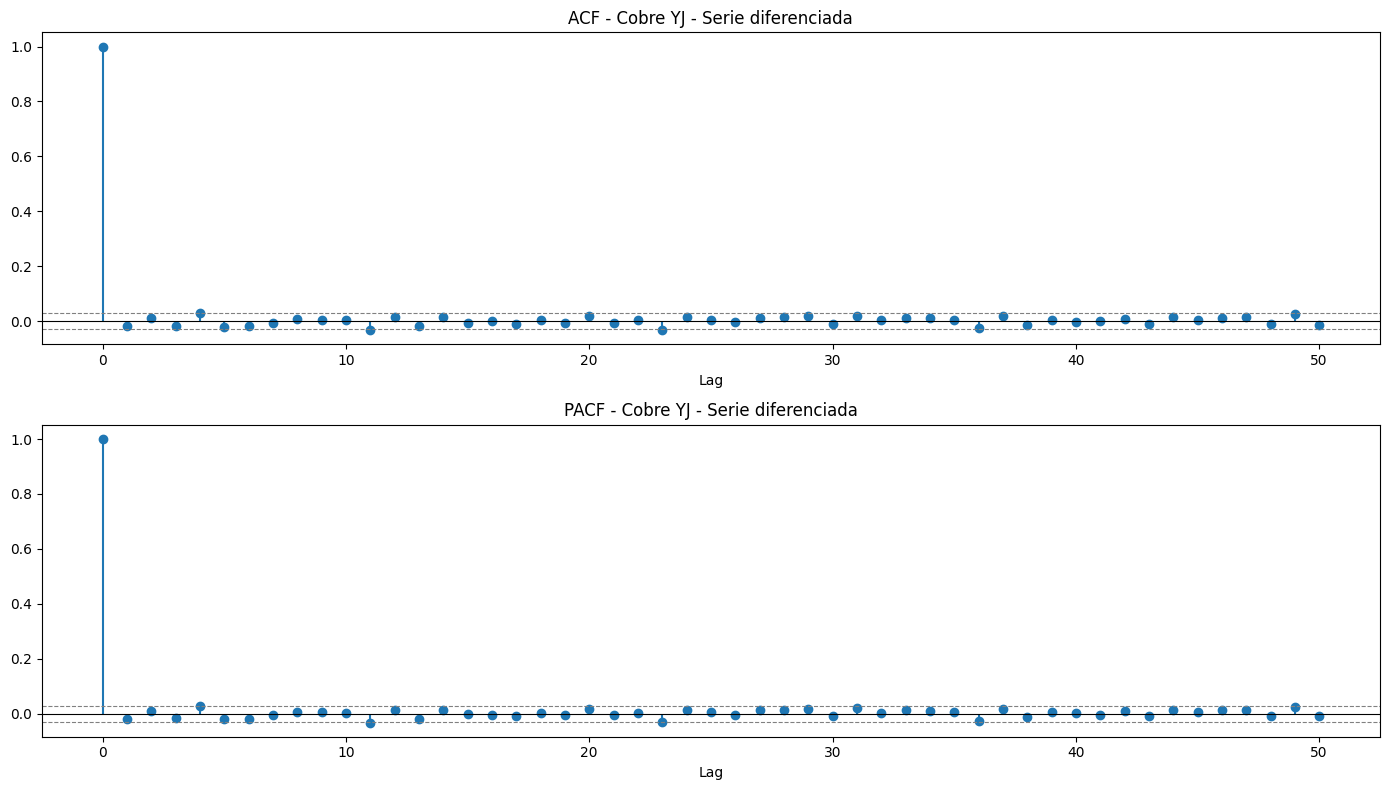

In [58]:
n = len(df_cobre)
nlags_acf  = min(50, n-1)
nlags_pacf = min(50, n-1)

pacf_monthly = pacf(df_cobre["cobre_yj_dif"], nlags=nlags_pacf, method='ywmle')
acf_monthly = acf(df_cobre["cobre_yj_dif"], nlags=nlags_acf)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
conf = 1.96 / np.sqrt(n)

axes[0].stem(range(len(acf_monthly)), acf_monthly, basefmt=' ')
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].axhline(conf, linestyle='--', color='gray', linewidth=0.8)
axes[0].axhline(-conf, linestyle='--', color='gray', linewidth=0.8)
axes[0].set_title('ACF - Cobre YJ - Serie diferenciada')
axes[0].set_xlabel('Lag')

axes[1].stem(range(len(pacf_monthly)), pacf_monthly, basefmt=' ')
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].axhline(conf, linestyle='--', color='gray', linewidth=0.8)
axes[1].axhline(-conf, linestyle='--', color='gray', linewidth=0.8)
axes[1].set_title('PACF - Cobre YJ - Serie diferenciada')
axes[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

- p = AR = [0,1] --> Podria presentar un Componente Autoregresivo
- d = [1] 
- q = [0]
- Poca claridad para definir componentes MA no estacionales → probar entre 0 y 1
- s (estacionalidad):No se ve comportamiento definido, probar con s=0 o s=5
- P (AR estacional):No se aprecian con claridad componentes autoregresivos estacionales en el PACF → probar P = [0] o máximo 1
- D=[0] --> ya logramos estacionalidad
- Q (MA estacional) --> no se ve ningun shock importante en pacf, por lo que se dejara entre [0] máximo 1. 

* Tiene más parecido a un de un arimax-arima que un sarima/sarimax

## Análisis de Colinealidad basado en Granger

In [59]:
target = "cobre_yj_dif"
num_cols = df_cobre.select_dtypes(include=[np.number]).columns.drop(target, errors="ignore")

#Calcular Granger F para todas
granger_scores = []
for col in num_cols:
    data = df_cobre[[target, col]].dropna()
    if len(data) < 10:
        continue
    try:
        results = grangercausalitytests(data, maxlag=3, verbose=False)
        #Máximo F-stat entre todos los lags
        max_f = max([results[lag][0]['ssr_ftest'][0] for lag in results.keys()])
        granger_scores.append({'variable': col, 'Granger_F': max_f})
    except:
        continue

granger_df = pd.DataFrame(granger_scores).sort_values('Granger_F', ascending=False)

#Eliminar multicolinealidad (corr > 0.85)
vars_list = granger_df['variable'].tolist()
corr_matrix = df_cobre[vars_list].corr()

variables_a_eliminar = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
            f1 = granger_df[granger_df['variable'] == var1]['Granger_F'].values[0]
            f2 = granger_df[granger_df['variable'] == var2]['Granger_F'].values[0]
            
            #Eliminar la de MENOR Granger F (peor causalidad)
            variables_a_eliminar.add(var2 if f1 > f2 else var1)

top = granger_df[~granger_df['variable'].isin(variables_a_eliminar)] 
lista_variables_cobre=top['variable'].tolist()+list([target]+['cobre_yj'])
lista_variables_cobre_test=top['variable'].tolist()+['cobre_yj']
         
top

variable  Granger_F
32             fcx  64.797759
28             bhp  34.564283
10           sp500  30.381041
7       emergentes  30.180314
12             vix  20.481036
35             nem  19.889284
31             eqt  14.548859
26             aem  13.552718
38            shel  12.755812
36            paas  12.277695
33             kgc  10.735479
27              ag   9.089805
0   petroleo_brent   8.324527
29            ctra   7.839308
57   desempleo_can   7.708562
3      gas_natural   4.711449
58   desempleo_ita   2.167231
52   desempleo_usa   2.098449
4            plata   1.703966
42        tasa_10y   1.489859
43         tasa_2y   1.305411
50         pib_ita   0.602630
48         pib_gbr   0.532365
5         shanghai   0.470168
54   desempleo_fra   0.361243

In [60]:
df_cobre_final=df_cobre[lista_variables_cobre]

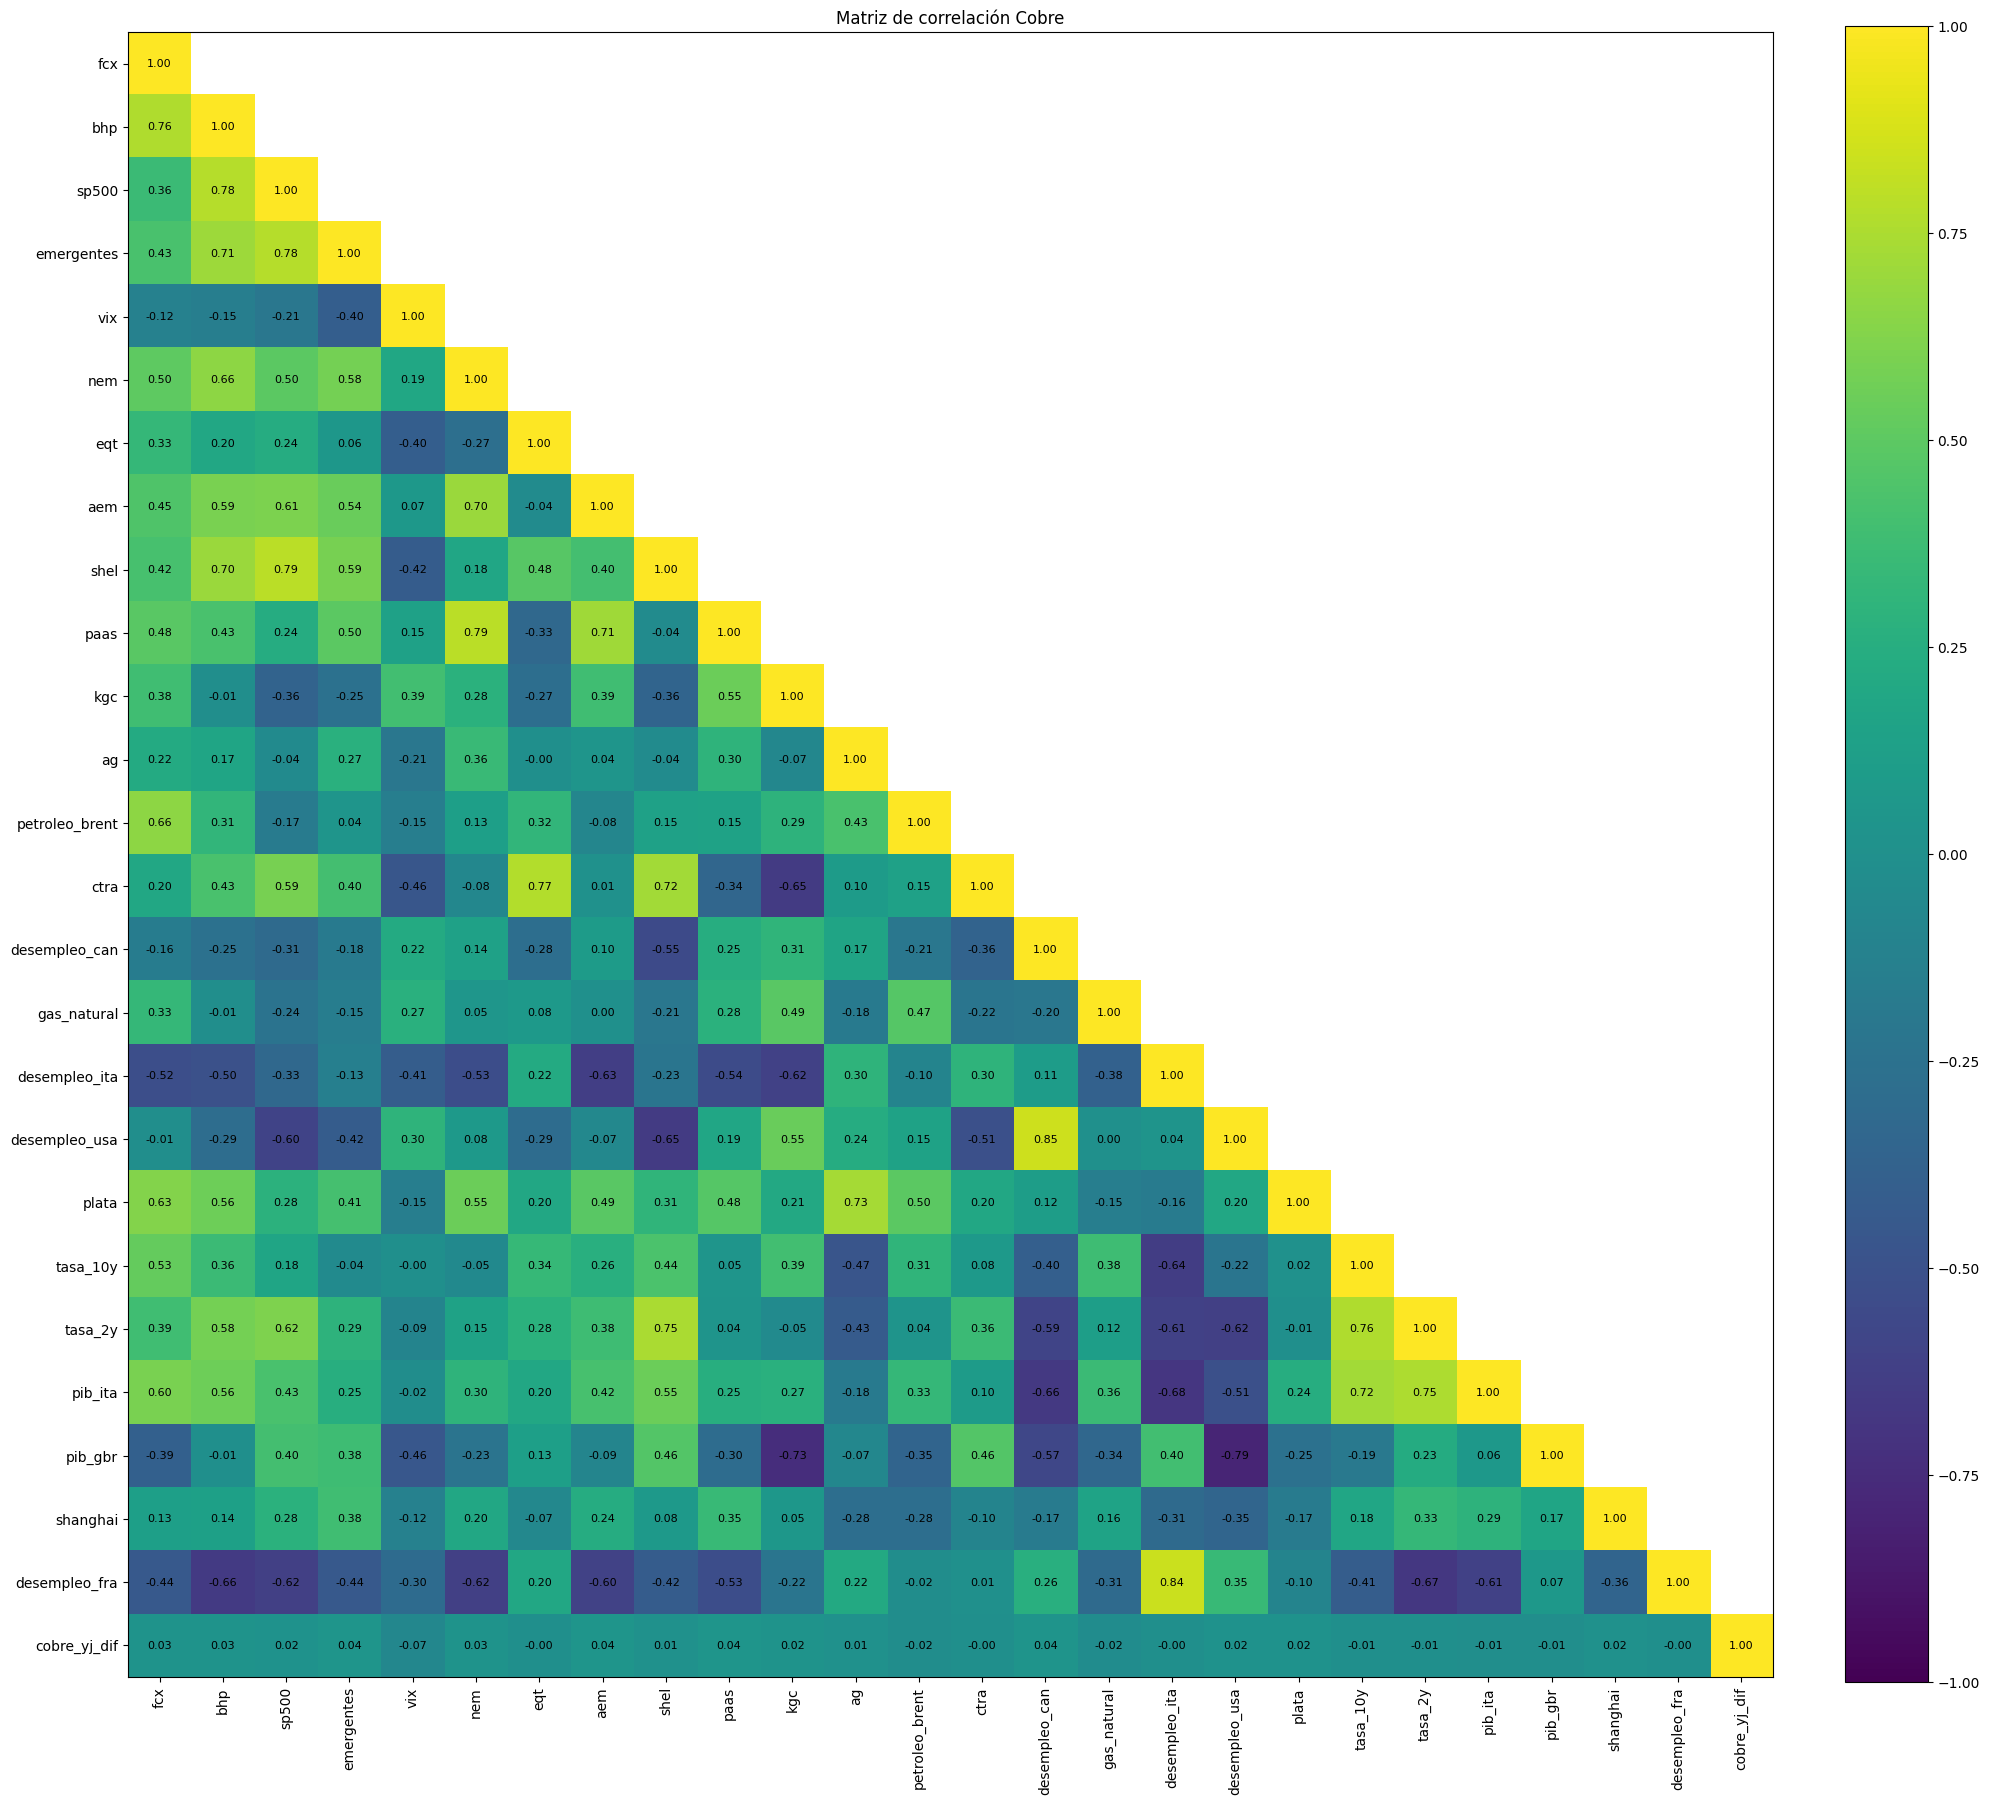

In [61]:
num_cols = (
    df_cobre_final.drop(columns=["cobre_yj"])
    .select_dtypes(include="number")
    .drop(columns=["fecha"], errors="ignore")
)

corr = num_cols.corr()

M = corr.values.copy()
mask = np.triu(np.ones_like(M, dtype=bool), k=1)
M_masked = M.copy()
M_masked[mask] = np.nan

plt.figure(figsize=(20, 20))
im = plt.imshow(M_masked, vmin=-1, vmax=1)  # sin cmap explícito
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        if not mask[i, j] and not np.isnan(M_masked[i, j]):
            plt.text(j, i, f"{M[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.title("Matriz de correlación Cobre")
plt.tight_layout()
plt.show()

## Test de Causalidad de Granger

In [62]:
exclude_cols = ["cobre_yj"]
features = df_cobre_final.drop(columns=exclude_cols, errors="ignore").select_dtypes(include=['float64', 'int64']).columns

max_lag = 7
results = []

for col in features:
    try:
        data = df_cobre_final[[col, "cobre_yj_dif"]].dropna()
        
        if len(data) > max_lag + 1:
            test = grangercausalitytests(data[["cobre_yj_dif", col]], max_lag, verbose=False)
            row = {'Feature': col}
            for lag in range(1, max_lag + 1):
                p_val = test[lag][0]['ssr_ftest'][1]
                row[f'P_Value_Lag{lag}'] = p_val
                row[f'Significant_Lag{lag}'] = p_val < 0.05
            
            results.append(row)
    except:
        continue
granger_df = pd.DataFrame(results)
granger_df['Min_P_Value'] = granger_df[['P_Value_Lag1', 'P_Value_Lag2', 'P_Value_Lag3']].min(axis=1)
granger_df_cobre = granger_df.sort_values('Min_P_Value').reset_index(drop=True)

granger_df_cobre.head(40)

Feature  P_Value_Lag1  Significant_Lag1  P_Value_Lag2  \
0              fcx      0.627216             False      0.000000   
1              bhp      0.928702             False      0.000000   
2       emergentes      0.423953             False      0.000000   
3            sp500      0.407422             False      0.000000   
4              vix      0.189705             False      0.000000   
5              nem      0.418992             False      0.000000   
6              eqt      0.264446             False      0.000001   
7              aem      0.115779             False      0.000001   
8             shel      0.529626             False      0.000003   
9             paas      0.425994             False      0.000005   
10             kgc      0.584491             False      0.000022   
11              ag      0.680138             False      0.000115   
12            ctra      0.373152             False      0.000399   
13  petroleo_brent      0.003929              True      0.015868   
14   desempleo_can      0.005518              True      0.023783   
15     gas_natural      0.030013              True      0.103062   
16   desempleo_ita      0.805879             False      0.959286   
17   desempleo_usa      0.147516             False      0.332021   
18           plata      0.546782             False      0.182074   
19        tasa_10y      0.319412             False      0.225512   
20         tasa_2y      0.522209             False      0.304444   
21         pib_ita      0.459264             False      0.771156   
22         pib_gbr      0.465651             False      0.711176   
23        shanghai      0.892447             False      0.909094   
24   desempleo_fra      0.824521             False      0.926734   

    Significant_Lag2  P_Value_Lag3  Significant_Lag3  P_Value_Lag4  \
0               True      0.000000              True      0.000000   
1               True      0.000000              True      0.000000   
2               True      0.000000              True      0.000000   
3               True      0.000000              True      0.000000   
4               True      0.000000              True      0.000000   
5               True      0.000000              True      0.000000   
6               True      0.000001              True      0.000001   
7               True      0.000004              True      0.000005   
8               True      0.000011              True      0.000023   
9               True      0.000013              True      0.000037   
10              True      0.000094              True      0.000218   
11              True      0.000123              True      0.000299   
12              True      0.001227              True      0.002275   
13              True      0.031510              True      0.038026   
14              True      0.051094             False      0.116663   
15             False      0.097005             False      0.011887   
16             False      0.089747             False      0.138538   
17             False      0.519771             False      0.710060   
18             False      0.189635             False      0.275830   
19             False      0.276052             False      0.410137   
20             False      0.270789             False      0.409464   
21             False      0.613254             False      0.789707   
22             False      0.761202             False      0.885795   
23             False      0.703089             False      0.823322   
24             False      0.781006             False      0.887506   

    Significant_Lag4  P_Value_Lag5  Significant_Lag5  P_Value_Lag6  \
0               True      0.000000              True      0.000000   
1               True      0.000000              True      0.000000   
2               True      0.000000              True      0.000000   
3               True      0.000000              True      0.000000   
4               True      0.000000              True      0.000000   
5

In [63]:
sig_cols = [c for c in granger_df.columns if c.lower().startswith('significant_lag')]
granger_df_cobre["granger_test"] = granger_df_cobre[sig_cols].any(axis=1).astype(int) 

granger_df_cobre=list(granger_df_cobre[granger_df_cobre["granger_test"]==1]["Feature"])+["cobre_yj"]
df_cobre_final=df_cobre_final[granger_df_cobre]

# Comportamiento Historico

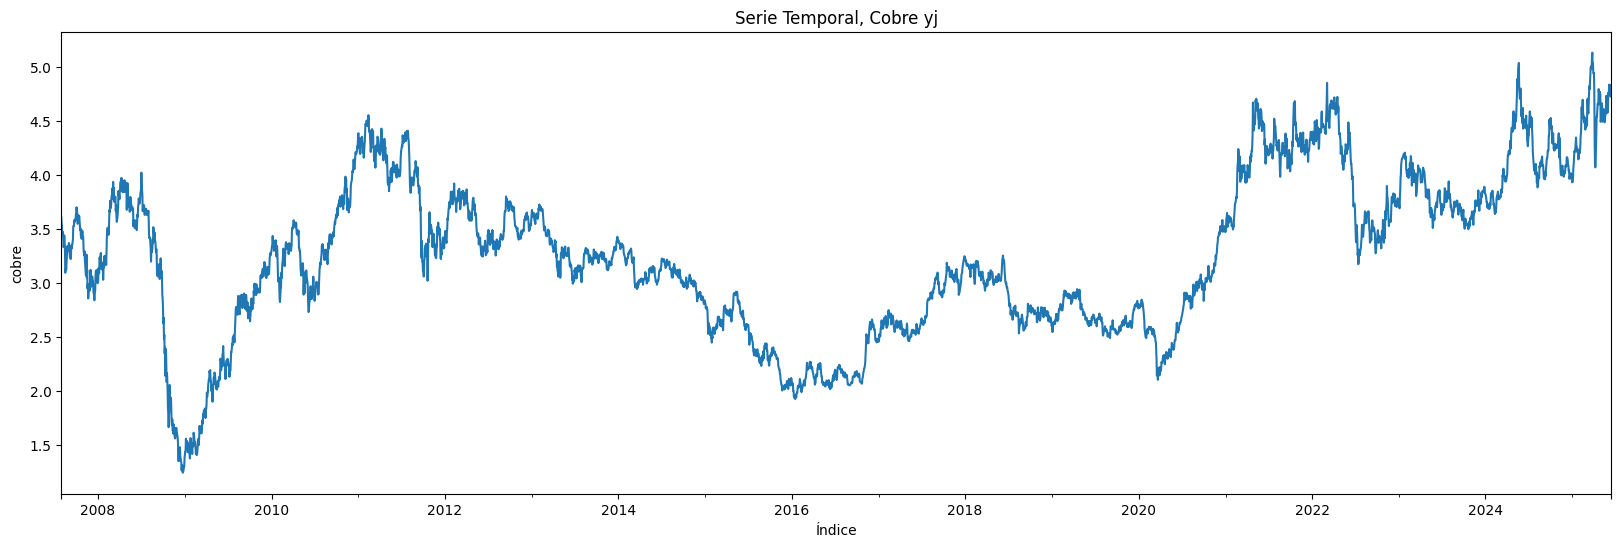

In [64]:
df_cobre_final['cobre_yj'].plot(figsize=(20,6))
plt.xlabel('Índice')
plt.ylabel('cobre')
plt.title('Serie Temporal, Cobre yj')
plt.show()

* Podríamos ver en la gráfica que tiene una cierta simetria entre los periodos, por lo que podría indicar una serie diferenciada estacional

## Análisis de Gas Natural

In [65]:
df_gas_natural=df_train.copy()
# === TEST DE SHAPIRO-WILK ===
print("=" * 70)
print("TEST DE SHAPIRO-WILK (Normalidad)")
print("=" * 70)
shapiro_stat, shapiro_p = stats.shapiro(df_gas_natural['gas_natural'].dropna())
print(f"Shapiro Statistic: {shapiro_stat:.4f}")
print(f"p-value: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("H0: No se rechaza - distribución normal")
    
else:
    print("H0: Se rechaza hipotesis nula - datos no presentan distribución normal")

TEST DE SHAPIRO-WILK (Normalidad)
Shapiro Statistic: 0.7984
p-value: 0.0000
H0: Se rechaza hipotesis nula - datos no presentan distribución normal


Los datos del gas no presentan una distribución normal, por lo que se opta a realizar una transformación y así que funcionen en modelos de la familia SARIMA

### Test de BOXOCOX

In [66]:
transformacion, lambda_opt = boxcox(df_gas_natural['gas_natural'])
print(f"Lambda óptimo: {lambda_opt:.4f}")

Lambda óptimo: -0.6623


El lambda al ser negativo, se procede a testear con YEO-JOHNSON

In [67]:
transformacion, lambda_opt_gas_natural = yeojohnson(df_gas_natural['gas_natural'])
print(f"Lambda óptimo: {lambda_opt_gas_natural:.4f}")  

Lambda óptimo: -1.1014


#### Se transforma a escala de YJ para disminuir la varianza y ajustar la seria a un comportamiento normal 

In [68]:
df_gas_natural['gas_natural_yj'] = yeojohnson(df_gas_natural['gas_natural'], lmbda=lambda_opt_gas_natural)

### Análisis de Descomposición

El modelo aditivo es más adecuado (CV menor).


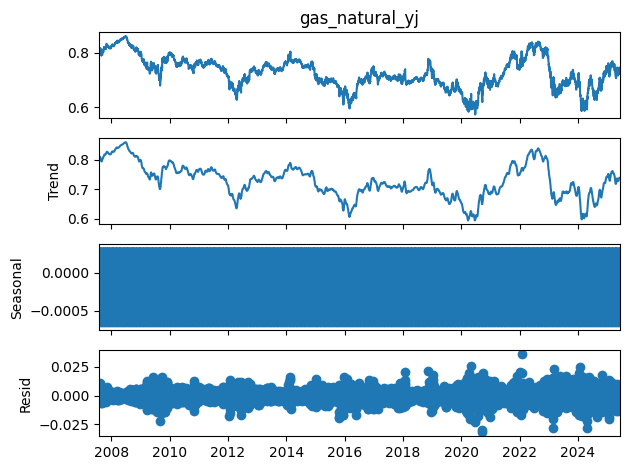

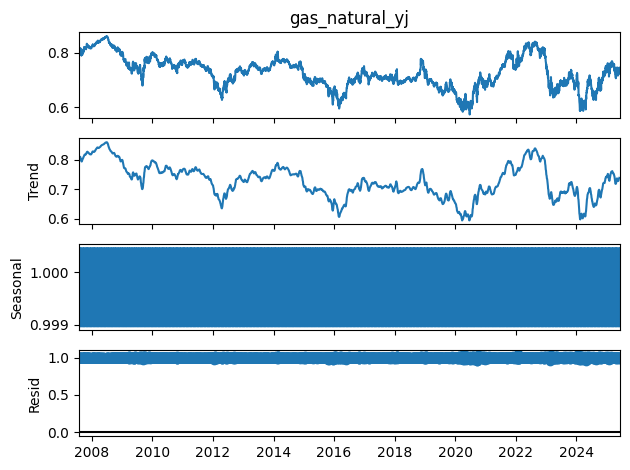

In [69]:
decompose_add = seasonal_decompose(df_gas_natural['gas_natural_yj']  , model='additive', period=12)
decompose_mult = seasonal_decompose(df_gas_natural['gas_natural_yj']  , model='multiplicative', period=12)

decompose_add.plot()
decompose_mult.plot()


seasonal_add = decompose_add.seasonal
seasonal_mult = decompose_mult.seasonal

cv_add = variation(seasonal_add.dropna())
cv_mult = variation(seasonal_mult.dropna()) 
if cv_add < cv_mult:
    print("El modelo aditivo es más adecuado (CV menor).")
elif cv_add > cv_mult:
    print("El modelo multiplicativo es más adecuado (CV menor).")
else:
    print("Ambos modelos tienen el mismo CV.")

In [70]:
series_to_test = df_gas_natural['gas_natural_yj'].dropna()

#ADF
adf_stat, adf_pval, adf_lags, adf_nobs, adf_crit, _ = adfuller(series_to_test)
print(f"ADF Statistic : {adf_stat:.4f}")
print(f"ADF p-value   : {adf_pval:.4g}")
print("»", "Estacionaria" if adf_pval < 0.05 else "NO estacionaria", "según ADF")

#KPSS
kpss_stat, kpss_pval, kpss_lags, kpss_crit = kpss(series_to_test, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat:.4f}")
print(f"KPSS p-value  : {kpss_pval:.4g}")
print("»", "Estacionaria" if kpss_pval > 0.05 else "NO estacionaria", "según KPSS")

tests_df = pd.DataFrame([
    {
        "serie": "GAS_NARUTAL_YJ",
        "test": "ADF",
        "stat": adf_stat,
        "p_value": adf_pval,
        "lags_usados": adf_lags,
        "n_observaciones": adf_nobs,
        "crit_1%": adf_crit.get("1%"),
        "crit_5%": adf_crit.get("5%"),
        "crit_10%": adf_crit.get("10%"),
        "estacionaria": adf_pval < 0.05  # criterio ADF
    },
    {
        "serie": "GAS_NARUTAL_YJ",
        "test": "KPSS (c)",
        "stat": kpss_stat,
        "p_value": kpss_pval,
        "lags_usados": kpss_lags,
        "n_observaciones": series_to_test.shape[0],
        "crit_1%": float(kpss_crit.get("1%")),
        "crit_5%": float(kpss_crit.get("5%")),
        "crit_10%": float(kpss_crit.get("10%")),
        "estacionaria": kpss_pval > 0.05  # criterio KPSS
    }
])

ts_tests_mensual = tests_df

print(ts_tests_mensual)

ADF Statistic : -3.1508
ADF p-value   : 0.02301
» Estacionaria según ADF
KPSS Statistic: 2.8511
KPSS p-value  : 0.01
» NO estacionaria según KPSS
            serie      test      stat  p_value  lags_usados  n_observaciones  \
0  GAS_NARUTAL_YJ       ADF -3.150817 0.023014           13             4651   
1  GAS_NARUTAL_YJ  KPSS (c)  2.851063 0.010000           41             4665   

    crit_1%   crit_5%  crit_10%  estacionaria  
0 -3.431757 -2.862162 -2.567101          True  
1  0.739000  0.463000  0.347000         False  


In [71]:
df_gas_natural['gas_natural_yj_dif']=df_gas_natural['gas_natural_yj'].diff()
df_gas_natural=df_gas_natural.dropna(subset="gas_natural_yj_dif")

Según nuestro test, en ADF no tiene comportamiento estacionario, por lo que se procede a diferenciar

In [72]:
series_to_test_dif = df_gas_natural['gas_natural_yj_dif']

#ADF
adf_stat_dif, adf_pval_dif, adf_lags_dif, adf_nobs_dif, adf_crit_dif, _ = adfuller(series_to_test)
print(f"ADF Statistic : {adf_stat_dif:.4f}")
print(f"ADF p-value   : {adf_pval_dif:.4g}")
print("»", "Estacionaria" if adf_pval_dif < 0.05 else "NO estacionaria", "según ADF")

#KPSS
kpss_stat_dif, kpss_pval_dif, kpss_lags_dif, kpss_crit_dif = kpss(series_to_test_dif, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat_dif:.4f}")
print(f"KPSS p-value  : {kpss_pval_dif:.4g}")
print("»", "Estacionaria" if kpss_pval_dif > 0.05 else "NO estacionaria", "según KPSS")

tests_df_dif = pd.DataFrame([
    {
        "serie": "GAS_NARUTAL_YJ_DIF",
        "test": "ADF",
        "stat": adf_stat_dif,
        "p_value": adf_pval_dif,
        "lags_usados": adf_lags_dif,
        "n_observaciones": adf_nobs_dif,
        "crit_1%": adf_crit_dif.get("1%"),
        "crit_5%": adf_crit_dif.get("5%"),
        "crit_10%": adf_crit_dif.get("10%"),
        "estacionaria": adf_pval_dif < 0.05  # criterio ADF
    },
    {
        "serie": "GAS_NARUTAL_YJ_DIF",
        "test": "KPSS (c)",
        "stat": kpss_stat_dif,
        "p_value": kpss_pval_dif,
        "lags_usados": kpss_lags_dif,
        "n_observaciones": series_to_test_dif.shape[0],
        "crit_1%": float(kpss_crit_dif.get("1%")),
        "crit_5%": float(kpss_crit_dif.get("5%")),
        "crit_10%": float(kpss_crit_dif.get("10%")),
        "estacionaria": kpss_pval_dif > 0.05  # criterio KPSS
    }
])

ts_tests_mensual_dif = tests_df_dif

print(ts_tests_mensual_dif)

ADF Statistic : -3.1508
ADF p-value   : 0.02301
» Estacionaria según ADF
KPSS Statistic: 0.0441
KPSS p-value  : 0.1
» Estacionaria según KPSS
                serie      test      stat  p_value  lags_usados  \
0  GAS_NARUTAL_YJ_DIF       ADF -3.150817 0.023014           13   
1  GAS_NARUTAL_YJ_DIF  KPSS (c)  0.044067 0.100000           17   

   n_observaciones   crit_1%   crit_5%  crit_10%  estacionaria  
0             4651 -3.431757 -2.862162 -2.567101          True  
1             4664  0.739000  0.463000  0.347000          True  


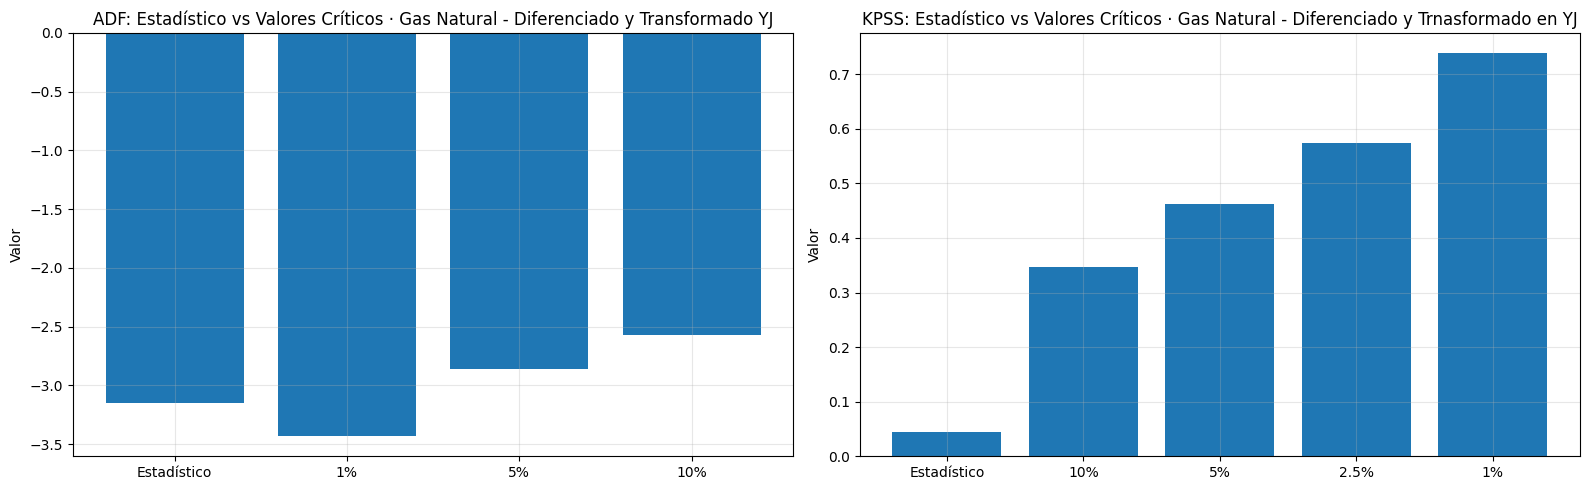

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ADF
axes[0].bar(['Estadístico'] + list(adf_crit_dif.keys()),
            [adf_stat_dif] + list(adf_crit_dif.values()))
axes[0].set_title("ADF: Estadístico vs Valores Críticos · Gas Natural - Diferenciado y Transformado YJ")
axes[0].set_ylabel("Valor"); axes[0].grid(alpha=.3)

# KPSS
axes[1].bar(['Estadístico'] + list(kpss_crit_dif.keys()),
            [kpss_stat_dif] + [float(k) for k in kpss_crit_dif.values()])
axes[1].set_title("KPSS: Estadístico vs Valores Críticos · Gas Natural - Diferenciado y Trnasformado en YJ")
axes[1].set_ylabel("Valor"); axes[1].grid(alpha=.3)

plt.tight_layout(); plt.show()

### Gráfica Shapiro WILK

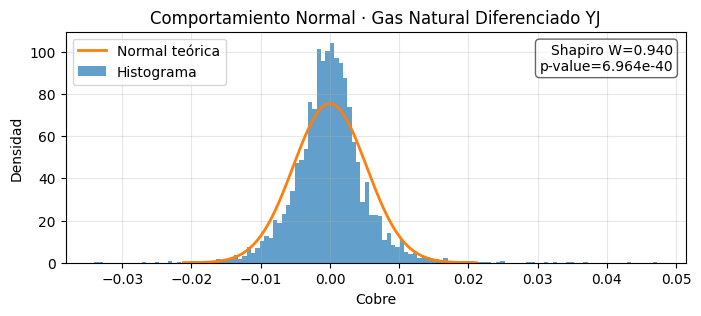

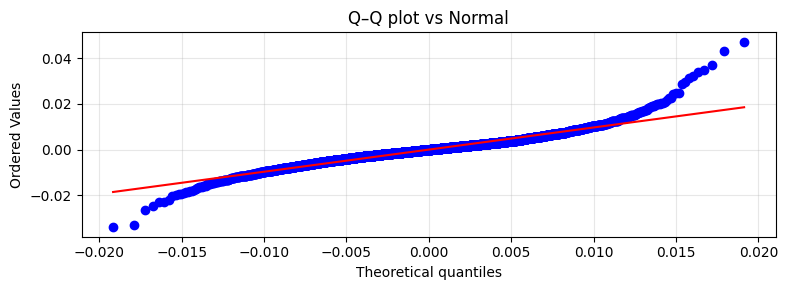

In [74]:
y = df_gas_natural['gas_natural_yj_dif']
sh_stat, sh_p = stats.shapiro(y)

mu, sigma = np.mean(y), np.std(y, ddof=1)
xs = np.linspace(mu - 4*sigma, mu + 4*sigma, 400)

#hist + curva teorica
plt.figure(figsize=(8,3))
plt.hist(y, bins='auto', density=True, alpha=0.7)
plt.plot(xs, stats.norm.pdf(xs, mu, sigma), linewidth=2)
plt.title("Comportamiento Normal · Gas Natural Diferenciado YJ")
plt.xlabel("Cobre")
plt.ylabel("Densidad")
plt.grid(alpha=.3)
plt.legend(["Normal teórica", "Histograma"], loc="best")
plt.annotate(f"Shapiro W={sh_stat:.3f}\np-value={sh_p:.4g}",
             xy=(0.98, 0.95), xycoords="axes fraction",
             ha="right", va="top",
             bbox=dict(boxstyle="round", fc="white", alpha=0.6))

# --- Q–Q plot ---
plt.figure(figsize=(8,3))
# Usamos la normal con media y sigma estimados
stats.probplot(y, dist="norm", sparams=(mu, sigma), plot=plt)
plt.title("Q–Q plot vs Normal")
plt.grid(alpha=.3)

plt.tight_layout()
plt.show()

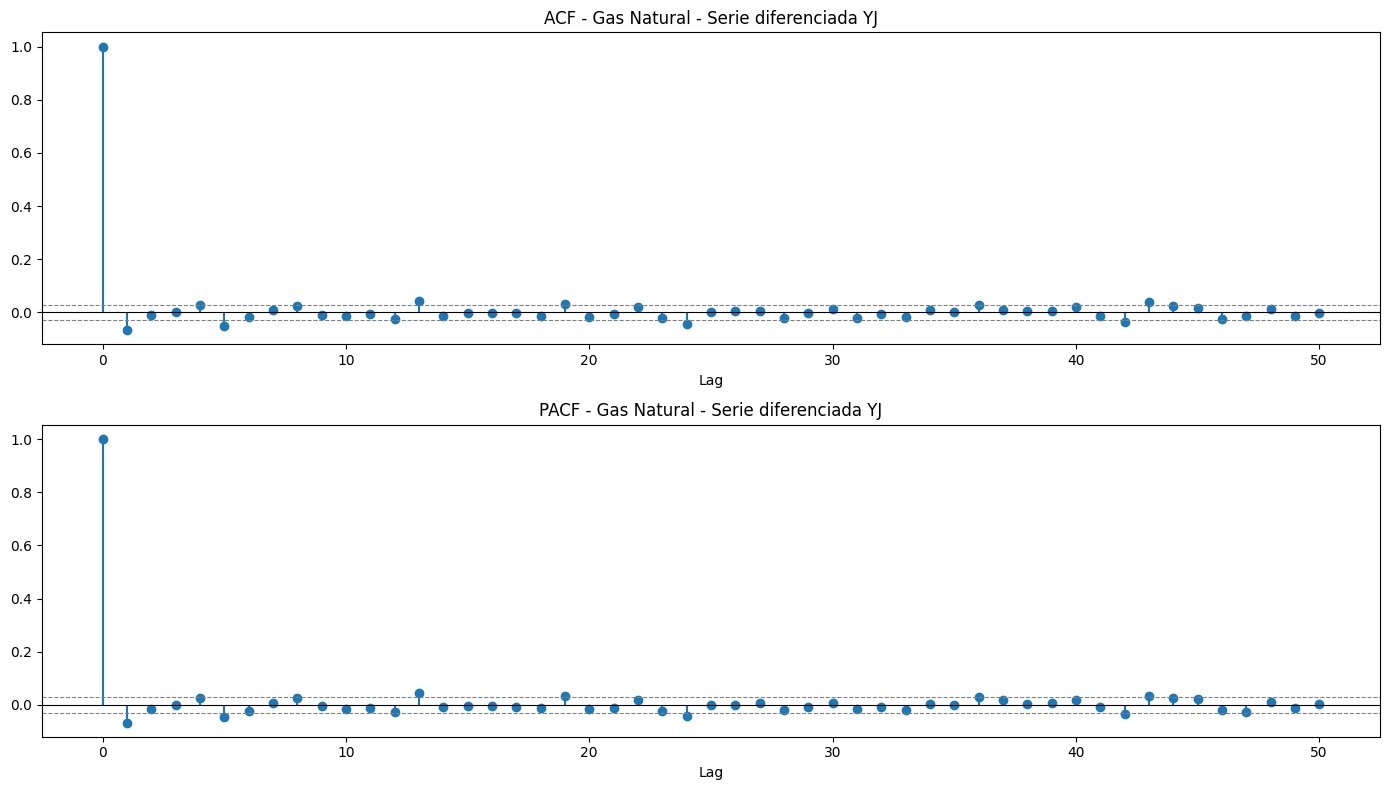

In [75]:
n = len(df_gas_natural)
nlags_acf  = min(50, n-1)
nlags_pacf = min(50, n-1)
pacf_monthly = pacf(df_gas_natural["gas_natural_yj_dif"], nlags=nlags_pacf, method='ywmle')
acf_monthly = acf(df_gas_natural["gas_natural_yj_dif"], nlags=nlags_acf)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
conf = 1.96 / np.sqrt(n)

axes[0].stem(range(len(acf_monthly)), acf_monthly, basefmt=' ')
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].axhline(conf, linestyle='--', color='gray', linewidth=0.8)
axes[0].axhline(-conf, linestyle='--', color='gray', linewidth=0.8)
axes[0].set_title('ACF - Gas Natural - Serie diferenciada YJ')
axes[0].set_xlabel('Lag')

axes[1].stem(range(len(pacf_monthly)), pacf_monthly, basefmt=' ')
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].axhline(conf, linestyle='--', color='gray', linewidth=0.8)
axes[1].axhline(-conf, linestyle='--', color='gray', linewidth=0.8)
axes[1].set_title('PACF - Gas Natural - Serie diferenciada YJ')
axes[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

- p = AR = 1 por lo menos
- d = 1 
- q = [1,4]--> podría inclusive, contener 4 componentes de rezago antes del shock
- Poca claridad para definir componentes MA no estacionales → probar entre [1,2]
- s (estacionalidad):5 --> semanal
- P (AR estacional):No se aprecian con claridad componentes autoregresivos estacionales en el PACF → probar P = [0,1].
- Q (MA estacional) ≥ 1 Claramente hay componente Q, ya que los shocks aparecen en múltiplos estacionales  
- Podria tener un componente ESTACIONAL en D=[0,1] 

* Tiene más parecido a un de un arimax-arima que un sarima/sarimax

### Test de Multicolinealidad con Granger

In [76]:
target = "gas_natural_yj_dif"
num_cols = df_gas_natural.select_dtypes(include=[np.number]).columns.drop(target, errors="ignore")

#Calcular Granger F para todas
granger_scores = []
for col in num_cols:
    data = df_gas_natural[[target, col]].dropna()
    if len(data) < 10:
        continue
    try:
        results = grangercausalitytests(data, maxlag=3, verbose=False)
        #Máximo F-stat entre todos los lags
        max_f = max([results[lag][0]['ssr_ftest'][0] for lag in results.keys()])
        granger_scores.append({'variable': col, 'Granger_F': max_f})
    except:
        continue

granger_df = pd.DataFrame(granger_scores).sort_values('Granger_F', ascending=False)

#Eliminar multicolinealidad (corr > 0.85)
vars_list = granger_df['variable'].tolist()
corr_matrix = df_gas_natural[vars_list].corr()

variables_a_eliminar = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
            f1 = granger_df[granger_df['variable'] == var1]['Granger_F'].values[0]
            f2 = granger_df[granger_df['variable'] == var2]['Granger_F'].values[0]
            
            #Eliminar la de MENOR Granger F (peor causalidad)
            variables_a_eliminar.add(var2 if f1 > f2 else var1)

top = granger_df[~granger_df['variable'].isin(variables_a_eliminar)] 
lista_variables_gas_natural=top['variable'].tolist()+list([target])
lista_variables_gas_natural_test=top['variable'].tolist()
         
top

variable  Granger_F
69  gas_natural_yj  10.195643
57   desempleo_can   3.915685
36            paas   3.895619
18           googl   3.298339
4            plata   3.220583
26             aem   2.920036
7       emergentes   2.472541
31             eqt   2.394728
35             nem   2.336896
29            ctra   2.143447
53   desempleo_ale   2.108000
27              ag   2.098052
12             vix   1.927840
32             fcx   1.905853
48         pib_gbr   1.838444
5         shanghai   1.543532
40             xom   1.489731
50         pib_ita   1.389578
52   desempleo_usa   1.219382
58   desempleo_ita   0.829961
0   petroleo_brent   0.652406
33             kgc   0.438313
44         tasa_5y   0.431930
54   desempleo_fra   0.213895

In [77]:
df_gas_natural_final=df_gas_natural[lista_variables_gas_natural]

In [78]:
df_gas_natural_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4664 entries, 2007-07-31 to 2025-06-13
Freq: B
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gas_natural_yj      4664 non-null   float64
 1   desempleo_can       4664 non-null   float64
 2   paas                4664 non-null   float64
 3   googl               4664 non-null   float64
 4   plata               4664 non-null   float64
 5   aem                 4664 non-null   float64
 6   emergentes          4664 non-null   float64
 7   eqt                 4664 non-null   float64
 8   nem                 4664 non-null   float64
 9   ctra                4664 non-null   float64
 10  desempleo_ale       4664 non-null   float64
 11  ag                  4664 non-null   float64
 12  vix                 4664 non-null   float64
 13  fcx                 4664 non-null   float64
 14  pib_gbr             4664 non-null   float64
 15  shanghai            4664 non-

### Matrix de Corr() - Gas Natural

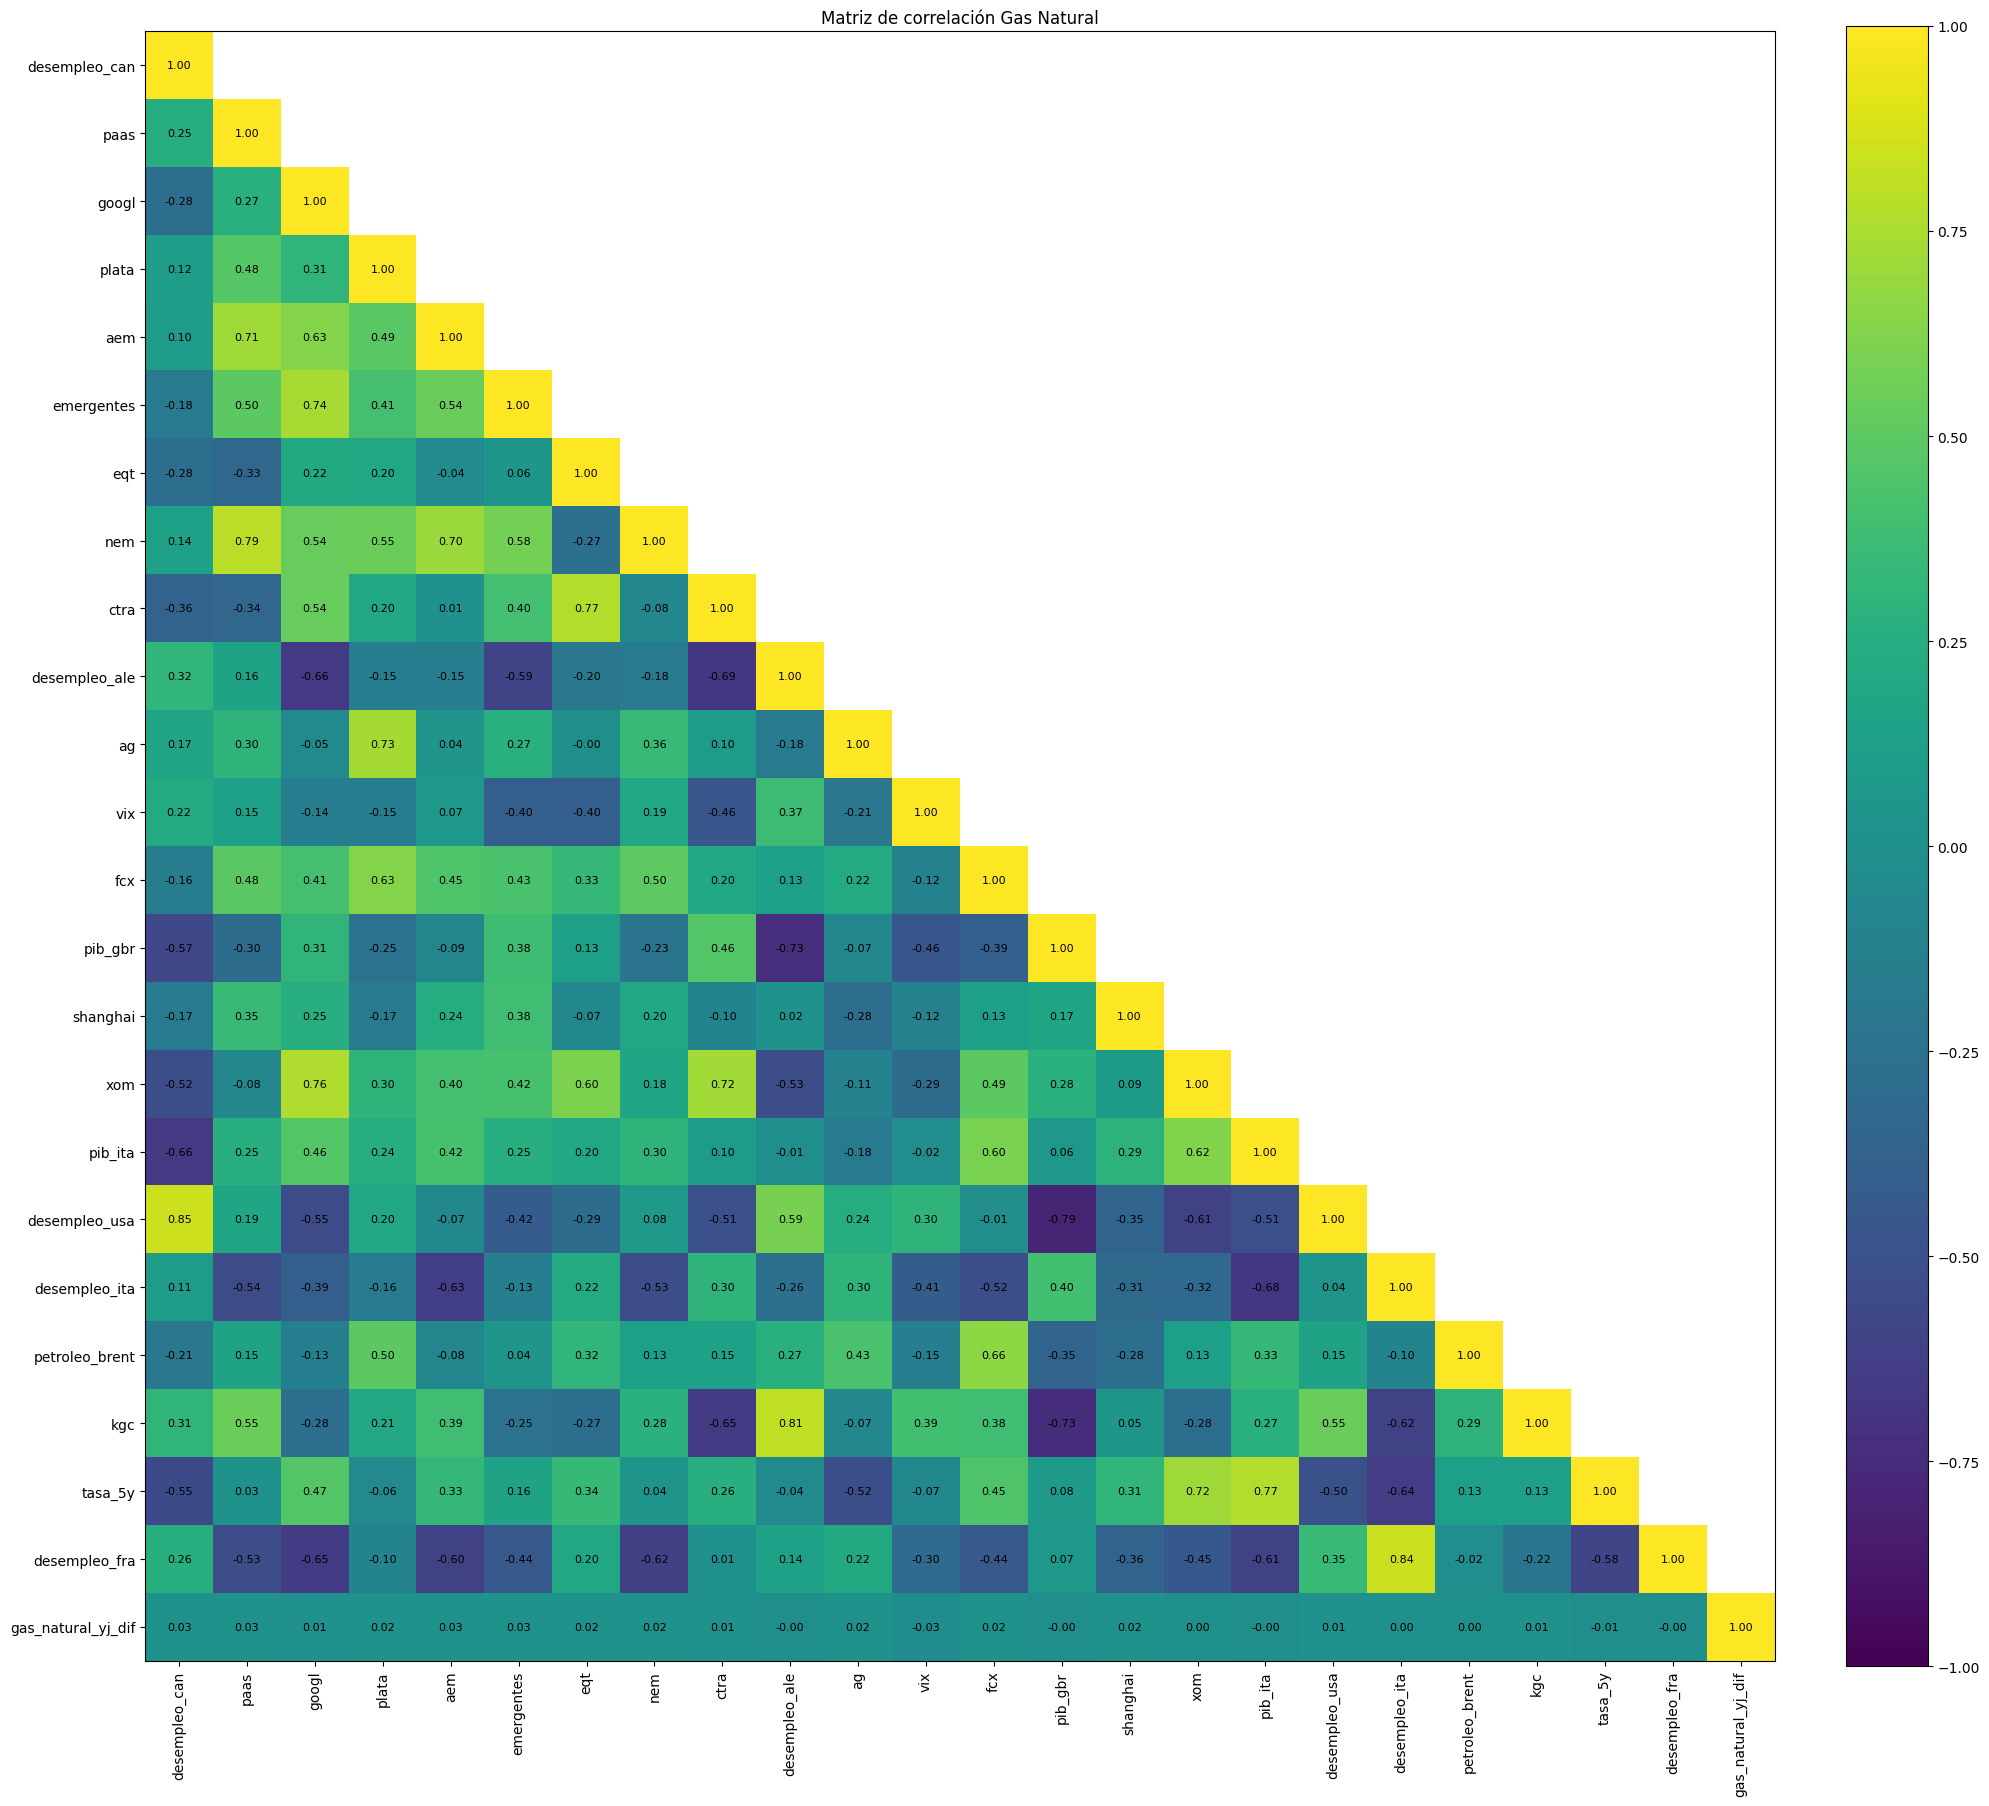

In [79]:
num_cols = (
    df_gas_natural_final.drop(columns=["gas_natural_yj"])
    .select_dtypes(include="number")
    .drop(columns=["fecha"], errors="ignore")
)

corr = num_cols.corr()

M = corr.values.copy()
mask = np.triu(np.ones_like(M, dtype=bool), k=1)
M_masked = M.copy()
M_masked[mask] = np.nan

plt.figure(figsize=(20, 20))
im = plt.imshow(M_masked, vmin=-1, vmax=1)  # sin cmap explícito
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        if not mask[i, j] and not np.isnan(M_masked[i, j]):
            plt.text(j, i, f"{M[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.title("Matriz de correlación Gas Natural")
plt.tight_layout()
plt.show()

### Test de Causalidad de Granger

In [80]:
exclude_cols = ["gas_natural","gas_natural_yj"]
features = df_gas_natural_final.drop(columns=exclude_cols, errors="ignore").select_dtypes(include=['float64', 'int64']).columns

max_lag = 7
results = []

for col in features:
    try:
        data = df_gas_natural_final[[col, "gas_natural_yj_dif"]].dropna()
        
        if len(data) > max_lag + 1:
            test = grangercausalitytests(data[["gas_natural_yj_dif", col]], max_lag, verbose=False)
            row = {'Feature': col}
            for lag in range(1, max_lag + 1):
                p_val = test[lag][0]['ssr_ftest'][1]
                row[f'P_Value_Lag{lag}'] = p_val
                row[f'Significant_Lag{lag}'] = p_val < 0.05
            
            results.append(row)
    except:
        continue
granger_df = pd.DataFrame(results)
granger_df['Min_P_Value'] = granger_df[['P_Value_Lag1', 'P_Value_Lag2', 'P_Value_Lag3']].min(axis=1)
granger_df_gas_natural = granger_df.sort_values('Min_P_Value').reset_index(drop=True)

granger_df_gas_natural.head(40)

Feature  P_Value_Lag1  Significant_Lag1  P_Value_Lag2  \
0            googl      0.338598             False      0.087323   
1            plata      0.208081             False      0.040021   
2    desempleo_can      0.047896              True      0.069781   
3             paas      0.048471              True      0.085453   
4              aem      0.087552             False      0.204129   
5              eqt      0.774310             False      0.091310   
6    desempleo_ale      0.972717             False      0.996341   
7       emergentes      0.115918             False      0.207160   
8             ctra      0.822474             False      0.117366   
9               ag      0.231678             False      0.122811   
10             fcx      0.325289             False      0.193368   
11             nem      0.126409             False      0.298103   
12         pib_gbr      0.772393             False      0.159180   
13             vix      0.165061             False      0.324003   
14        shanghai      0.214155             False      0.239110   
15             xom      0.834058             False      0.977219   
16         pib_ita      0.837297             False      0.249284   
17   desempleo_usa      0.301368             False      0.295507   
18   desempleo_ita      0.983913             False      0.436131   
19         tasa_5y      0.556373             False      0.649281   
20  petroleo_brent      0.891470             False      0.991148   
21             kgc      0.662279             False      0.645151   
22   desempleo_fra      0.986914             False      0.807441   

    Significant_Lag2  P_Value_Lag3  Significant_Lag3  P_Value_Lag4  \
0              False      0.019564              True      0.004237   
1               True      0.082795             False      0.154710   
2              False      0.054548             False      0.051207   
3              False      0.145172             False      0.177973   
4              False      0.259260             False      0.173353   
5              False      0.177495             False      0.245113   
6              False      0.097022             False      0.157974   
7              False      0.206343             False      0.346243   
8              False      0.167931             False      0.196417   
9              False      0.219294             False      0.327894   
10             False      0.126348             False      0.223391   
11             False      0.315445             False      0.179354   
12             False      0.220406             False      0.132941   
13             False      0.424792             False      0.525524   
14             False      0.271831             False      0.411379   
15             False      0.215205             False      0.344965   
16             False      0.425253             False      0.403162   
17             False      0.409795             False      0.042290   
18             False      0.539775             False      0.249356   
19             False      0.833791             False      0.529057   
20             False      0.581376             False      0.718927   
21             False      0.831381             False      0.914464   
22             False      0.920050             False      0.887435   

    Significant_Lag4  P_Value_Lag5  Significant_Lag5  P_Value_Lag6  \
0               True      0.001716              True      0.001683   
1              False      0.146017             False      0.175472   
2              False      0.004463              True      0.005598   
3              False      0.120977             False      0.165384   
4              False      0.200641             False      0.177241   
5              False      0.309481             False      0.366705   
6              False      0.284609             False      0.386467   
7              False      0.448208             False      0.445746   
8              False      0.237179             False      0.325034 

In [81]:
sig_cols = [c for c in granger_df_gas_natural.columns if c.lower().startswith('significant_lag')]
granger_df_gas_natural["granger_test"] = granger_df_gas_natural[sig_cols].any(axis=1).astype(int) 

granger_df_gas_natural=list(granger_df_gas_natural[granger_df_gas_natural["granger_test"]==1]["Feature"])+["gas_natural_yj"]
df_gas_natural_final=df_gas_natural_final[granger_df_gas_natural]

### Gráfica - Serie Temporal GAS NATURAL YJ

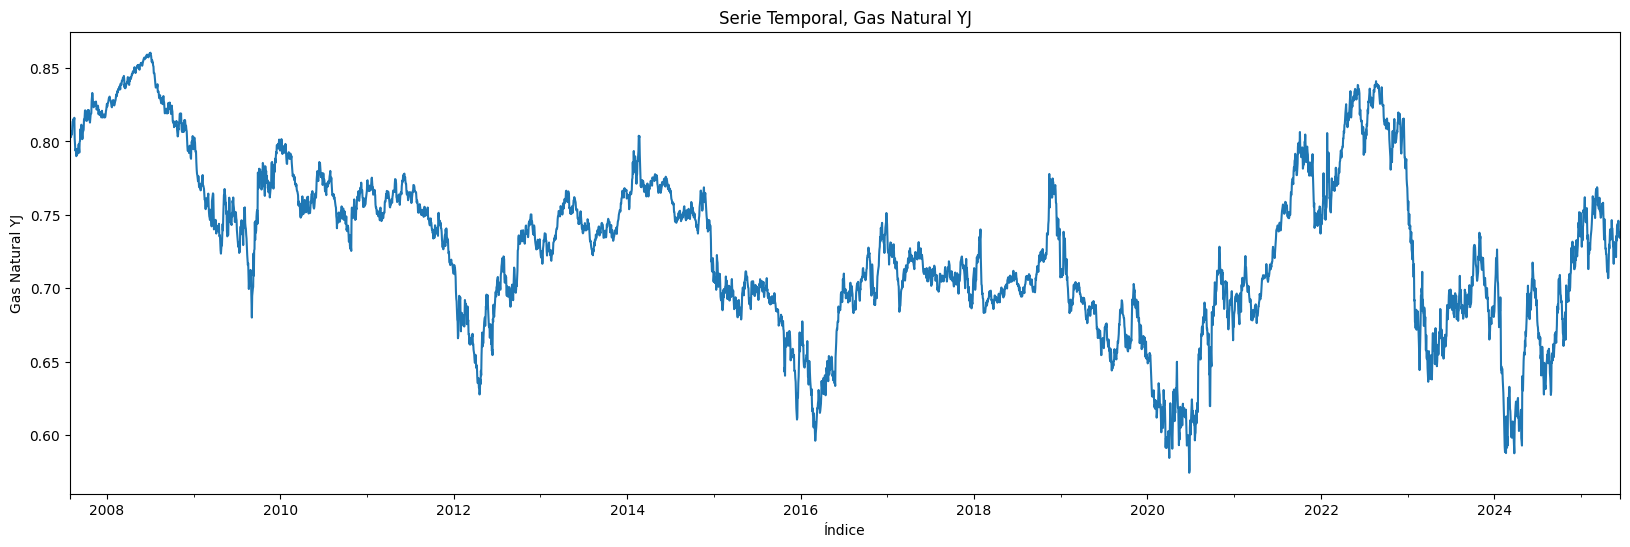

In [82]:
df_gas_natural_final['gas_natural_yj'].plot(figsize=(20,6))
plt.xlabel('Índice')
plt.ylabel('Gas Natural YJ')
plt.title('Serie Temporal, Gas Natural YJ')
plt.show()

* Se Puede apreciar claramente un comportamiento estacional y podría ser que inclusive, mantenga un comportamiento ciclico, por lo que evaluaremos la gráfica de la variable diferenciada

## Comportamiento estacional claro --> indica una diferenciación D=1

## Análisis del Petroleo Brent

In [83]:
df_petroleo_brent=df_train.copy()
# === TEST DE SHAPIRO-WILK ===
print("=" * 70)
print("TEST DE SHAPIRO-WILK (Normalidad)")
print("=" * 70)
shapiro_stat, shapiro_p = stats.shapiro(df_petroleo_brent['petroleo_brent'].dropna())
print(f"Shapiro Statistic: {shapiro_stat:.4f}")
print(f"p-value: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("H0: No se rechaza - distribución normal")
    
else:
    print("H0: Se rechaza hipotesis nula - datos no presentan distribución normal")

TEST DE SHAPIRO-WILK (Normalidad)
Shapiro Statistic: 0.9769
p-value: 0.0000
H0: Se rechaza hipotesis nula - datos no presentan distribución normal


## Test de BoxCox para normalizar la serie y controlar la varianza

In [84]:
transformacion, lambda_opt_petroleo = boxcox(df_petroleo_brent['petroleo_brent'])
print(f"Lambda óptimo: {lambda_opt:.4f}")

Lambda óptimo: -0.6623


YJ Ya que BoxCox es negativo

In [85]:
transformacion, lambda_opt_petroleo = yeojohnson(df_petroleo_brent['petroleo_brent'])
print(f"Lambda óptimo: {lambda_opt:.4f}")

Lambda óptimo: -0.6623


In [86]:
df_petroleo_brent['petroleo_brent_yj'] = yeojohnson(df_petroleo_brent['petroleo_brent'], lmbda=lambda_opt_petroleo)

### Análisis de Descomposición

El modelo aditivo es más adecuado (CV menor).


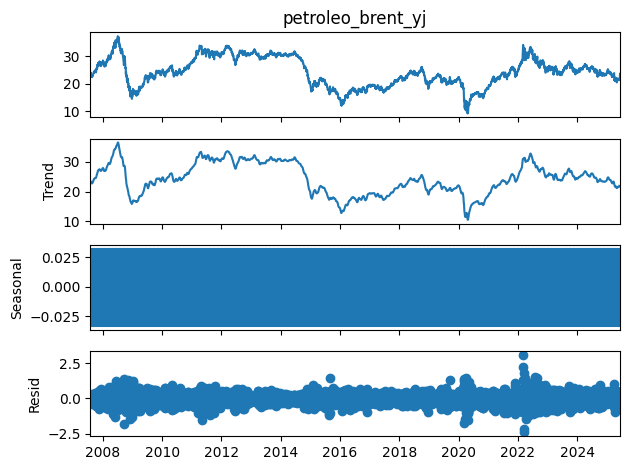

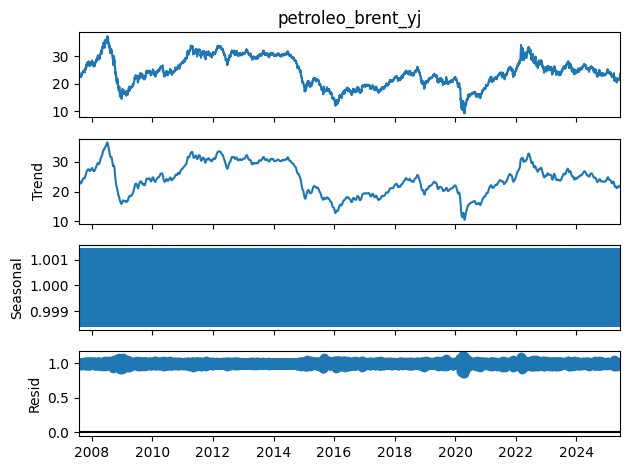

In [87]:
decompose_add = seasonal_decompose(df_petroleo_brent['petroleo_brent_yj'] , model='additive', period=12)
decompose_mult = seasonal_decompose(df_petroleo_brent['petroleo_brent_yj'], model='multiplicative', period=12)

decompose_add.plot()
decompose_mult.plot()


seasonal_add = decompose_add.seasonal
seasonal_mult = decompose_mult.seasonal

cv_add = variation(seasonal_add.dropna())
cv_mult = variation(seasonal_mult.dropna()) 
if cv_add < cv_mult:
    print("El modelo aditivo es más adecuado (CV menor).")
elif cv_add > cv_mult:
    print("El modelo multiplicativo es más adecuado (CV menor).")
else:
    print("Ambos modelos tienen el mismo CV.")

El componente multiplicativo en la descomposición suma más, por lo que nos podría indicar de antemano, que tiene componentes estacionales

### Test ADF-KPSS

In [88]:
series_to_test = df_petroleo_brent['petroleo_brent_yj'].dropna()

#ADF
adf_stat, adf_pval, adf_lags, adf_nobs, adf_crit, _ = adfuller(series_to_test)
print(f"ADF Statistic : {adf_stat:.4f}")
print(f"ADF p-value   : {adf_pval:.4g}")
print("»", "Estacionaria" if adf_pval < 0.05 else "NO estacionaria", "según ADF")

#KPSS
kpss_stat, kpss_pval, kpss_lags, kpss_crit = kpss(series_to_test, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat:.4f}")
print(f"KPSS p-value  : {kpss_pval:.4g}")
print("»", "Estacionaria" if kpss_pval > 0.05 else "NO estacionaria", "según KPSS")

tests_df = pd.DataFrame([
    {
        "serie": "petroleo_brent_yj",
        "test": "ADF",
        "stat": adf_stat,
        "p_value": adf_pval,
        "lags_usados": adf_lags,
        "n_observaciones": adf_nobs,
        "crit_1%": adf_crit.get("1%"),
        "crit_5%": adf_crit.get("5%"),
        "crit_10%": adf_crit.get("10%"),
        "estacionaria": adf_pval < 0.05  # criterio ADF
    },
    {
        "serie": "petroleo_brent_yj",
        "test": "KPSS (c)",
        "stat": kpss_stat,
        "p_value": kpss_pval,
        "lags_usados": kpss_lags,
        "n_observaciones": series_to_test.shape[0],
        "crit_1%": float(kpss_crit.get("1%")),
        "crit_5%": float(kpss_crit.get("5%")),
        "crit_10%": float(kpss_crit.get("10%")),
        "estacionaria": kpss_pval > 0.05  # criterio KPSS
    }
])

ts_tests_mensual = tests_df

print(ts_tests_mensual)

ADF Statistic : -2.1776
ADF p-value   : 0.2145
» NO estacionaria según ADF
KPSS Statistic: 1.7006
KPSS p-value  : 0.01
» NO estacionaria según KPSS
               serie      test      stat  p_value  lags_usados  \
0  petroleo_brent_yj       ADF -2.177585 0.214481            5   
1  petroleo_brent_yj  KPSS (c)  1.700629 0.010000           41   

   n_observaciones   crit_1%   crit_5%  crit_10%  estacionaria  
0             4659 -3.431754 -2.862161 -2.567100         False  
1             4665  0.739000  0.463000  0.347000         False  


* Diferenciamos por precencia de componentes estacionales

In [89]:
df_petroleo_brent['petroleo_brent_yj_dif']=df_petroleo_brent['petroleo_brent_yj'].diff()

In [90]:
df_petroleo_brent=df_petroleo_brent.dropna(subset="petroleo_brent_yj_dif")

In [91]:
#ADF
adf_stat_dif, adf_pval_dif, adf_lags_dif, adf_nobs_dif, adf_crit_dif, _ = adfuller(df_petroleo_brent['petroleo_brent_yj_dif'])
print(f"ADF Statistic : {adf_stat_dif:.4f}")
print(f"ADF p-value   : {adf_pval_dif:.4g}")
print("»", "Estacionaria" if adf_pval_dif < 0.05 else "NO estacionaria", "según ADF")

#KPSS
kpss_stat_dif, kpss_pval_dif, kpss_lags_dif, kpss_crit_dif = kpss(df_petroleo_brent['petroleo_brent_yj_dif'], regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat_dif:.4f}")
print(f"KPSS p-value  : {kpss_pval_dif:.4g}")
print("»", "Estacionaria" if kpss_pval_dif > 0.05 else "NO estacionaria", "según KPSS")

tests_df_dif = pd.DataFrame([
    {
        "serie": "Petroleo_Brent_dif_YJ",
        "test": "ADF",
        "stat": adf_stat_dif,
        "p_value": adf_pval_dif,
        "lags_usados": adf_lags_dif,
        "n_observaciones": adf_nobs_dif,
        "crit_1%": adf_crit_dif.get("1%"),
        "crit_5%": adf_crit_dif.get("5%"),
        "crit_10%": adf_crit_dif.get("10%"),
        "estacionaria": adf_pval_dif < 0.05  # criterio ADF
    },
    {
        "serie": "Petróleo_Brent_dif_YJ",
        "test": "KPSS (c)",
        "stat": kpss_stat_dif,
        "p_value": kpss_pval_dif,
        "lags_usados": kpss_lags_dif,
        "n_observaciones": df_petroleo_brent['petroleo_brent_yj_dif'].shape[0],
        "crit_1%": float(kpss_crit_dif.get("1%")),
        "crit_5%": float(kpss_crit_dif.get("5%")),
        "crit_10%": float(kpss_crit_dif.get("10%")),
        "estacionaria": kpss_pval_dif > 0.05  # criterio KPSS
    }
])

ts_tests_mensual_dif = tests_df_dif

print(ts_tests_mensual_dif)

ADF Statistic : -31.1690
ADF p-value   : 0
» Estacionaria según ADF
KPSS Statistic: 0.0516
KPSS p-value  : 0.1
» Estacionaria según KPSS
                   serie      test       stat  p_value  lags_usados  \
0  Petroleo_Brent_dif_YJ       ADF -31.169047 0.000000            4   
1  Petróleo_Brent_dif_YJ  KPSS (c)   0.051554 0.100000            7   

   n_observaciones   crit_1%   crit_5%  crit_10%  estacionaria  
0             4659 -3.431754 -2.862161 -2.567100          True  
1             4664  0.739000  0.463000  0.347000          True  


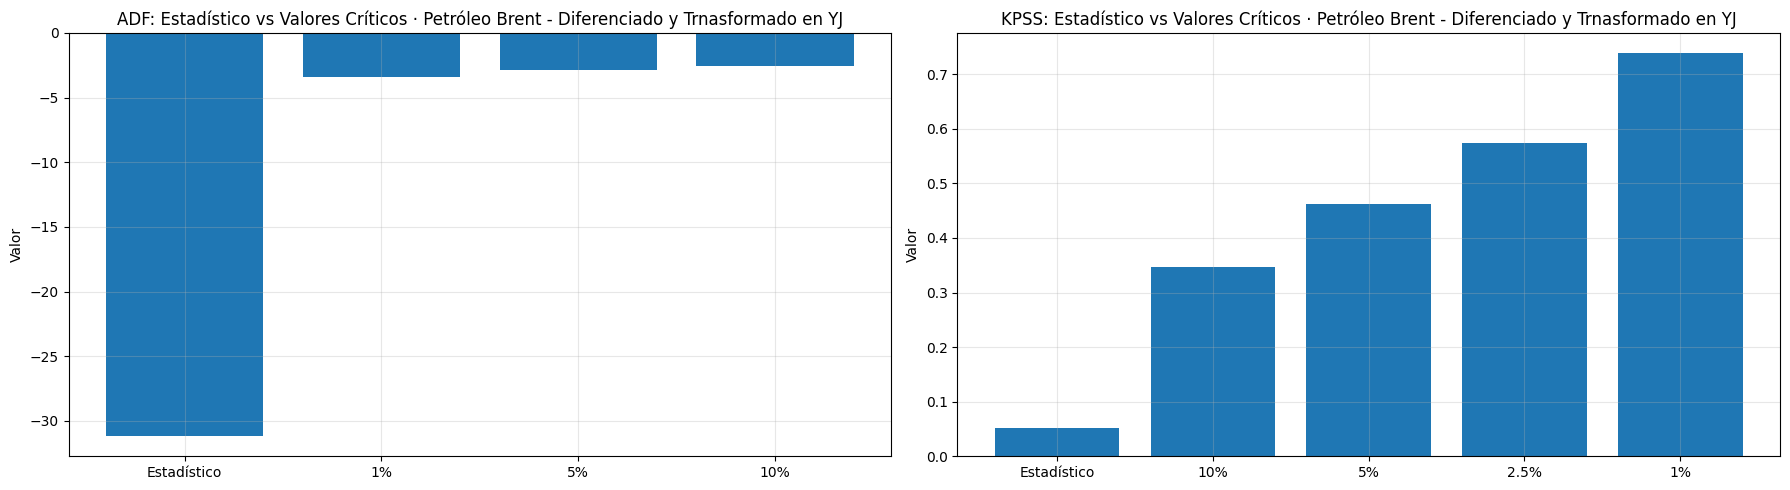

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# ADF
axes[0].bar(['Estadístico'] + list(adf_crit_dif.keys()),
            [adf_stat_dif] + list(adf_crit_dif.values()))
axes[0].set_title("ADF: Estadístico vs Valores Críticos · Petróleo Brent - Diferenciado y Trnasformado en YJ")
axes[0].set_ylabel("Valor"); axes[0].grid(alpha=.3)

# KPSS
axes[1].bar(['Estadístico'] + list(kpss_crit_dif.keys()),
            [kpss_stat_dif] + [float(k) for k in kpss_crit_dif.values()])
axes[1].set_title("KPSS: Estadístico vs Valores Críticos · Petróleo Brent - Diferenciado y Trnasformado en YJ")
axes[1].set_ylabel("Valor"); axes[1].grid(alpha=.3)

plt.tight_layout(); plt.show()

* La serie ya tiene un comportamiento estacionario

### Gráfica - Shapiro Wilk

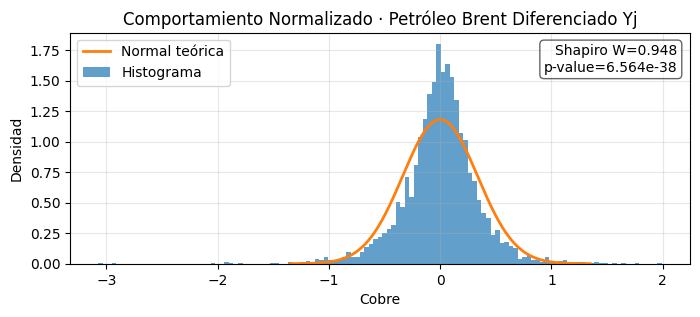

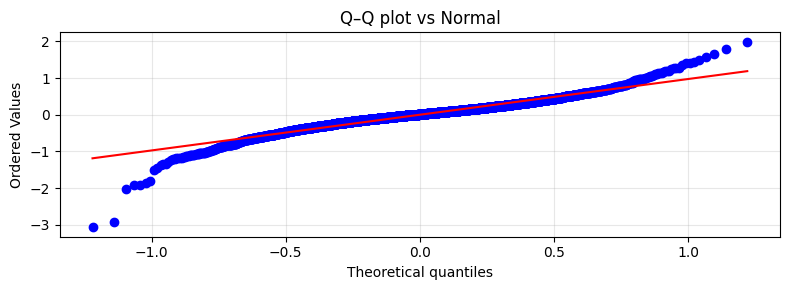

In [93]:
y = df_petroleo_brent['petroleo_brent_yj_dif']
sh_stat, sh_p = stats.shapiro(y)

mu, sigma = np.mean(y), np.std(y, ddof=1)
xs = np.linspace(mu - 4*sigma, mu + 4*sigma, 400)

#hist + curva teorica
plt.figure(figsize=(8,3))
plt.hist(y, bins='auto', density=True, alpha=0.7)
plt.plot(xs, stats.norm.pdf(xs, mu, sigma), linewidth=2)
plt.title("Comportamiento Normalizado · Petróleo Brent Diferenciado Yj")
plt.xlabel("Cobre")
plt.ylabel("Densidad")
plt.grid(alpha=.3)
plt.legend(["Normal teórica", "Histograma"], loc="best")
plt.annotate(f"Shapiro W={sh_stat:.3f}\np-value={sh_p:.4g}",
             xy=(0.98, 0.95), xycoords="axes fraction",
             ha="right", va="top",
             bbox=dict(boxstyle="round", fc="white", alpha=0.6))

# --- Q–Q plot ---
plt.figure(figsize=(8,3))
# Usamos la normal con media y sigma estimados
stats.probplot(y, dist="norm", sparams=(mu, sigma), plot=plt)
plt.title("Q–Q plot vs Normal")
plt.grid(alpha=.3)

plt.tight_layout()
plt.show()

### ADF- PACF

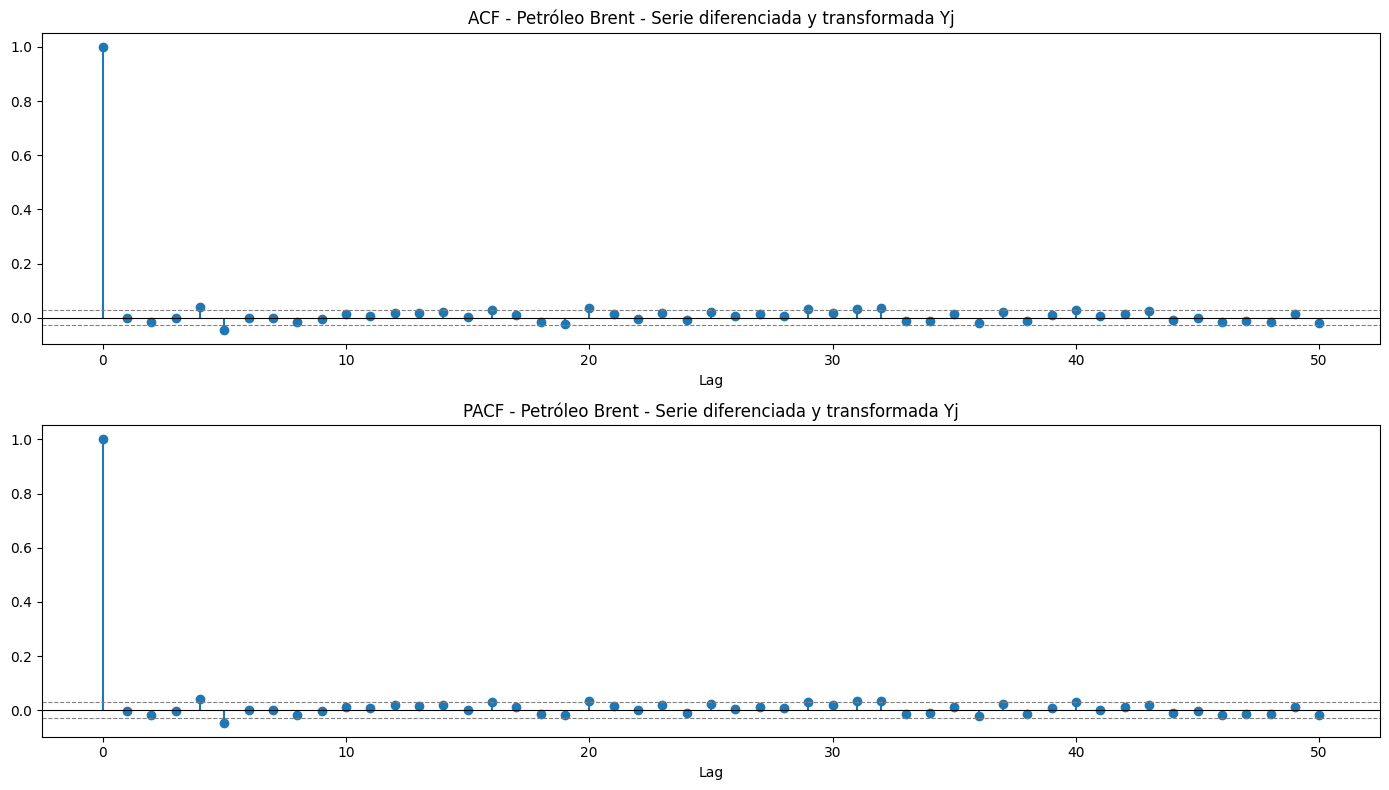

In [94]:
n = len(df_petroleo_brent)
nlags_acf  = min(50, n-1)
nlags_pacf = min(50, n-1)

pacf_monthly = pacf(df_petroleo_brent['petroleo_brent_yj_dif'], nlags=nlags_pacf, method='ywmle')
acf_monthly = acf(df_petroleo_brent['petroleo_brent_yj_dif'], nlags=nlags_acf)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
conf = 1.96 / np.sqrt(n)

axes[0].stem(range(len(acf_monthly)), acf_monthly, basefmt=' ')
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].axhline(conf, linestyle='--', color='gray', linewidth=0.8)
axes[0].axhline(-conf, linestyle='--', color='gray', linewidth=0.8)
axes[0].set_title('ACF - Petróleo Brent - Serie diferenciada y transformada Yj')
axes[0].set_xlabel('Lag')

axes[1].stem(range(len(pacf_monthly)), pacf_monthly, basefmt=' ')
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].axhline(conf, linestyle='--', color='gray', linewidth=0.8)
axes[1].axhline(-conf, linestyle='--', color='gray', linewidth=0.8)
axes[1].set_title('PACF - Petróleo Brent - Serie diferenciada y transformada Yj')
axes[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

- p = AR = [0,1] --> lo más probable es que los mejores resultados sean con 0 o a lo más 1
- d = [1] 
- q = [1,4]--> shock fuerte al lag 4 y 5
- Poca claridad para definir componentes MA no estacionales → probar entre [0.2]
- s (estacionalidad):semanal [5]
- P (AR estacional):No se aprecian con claridad componentes autoregresivos estacionales en el PACF → probar P = [0,1]
- Q (MA estacional): no se aprecia con claridad, probar con [0,1] 
- Podria tener un componente ESTACIONAL en D=1, producto de las ascilaciones que presenta de forma recurrente

### Test de Multicolinealidad de Granger

In [95]:
target = "petroleo_brent_yj_dif"
num_cols = df_petroleo_brent.select_dtypes(include=[np.number]).columns.drop(target, errors="ignore")

#Calcular Granger F para todas
granger_scores = []
for col in num_cols:
    data = df_petroleo_brent[[target, col]].dropna()
    if len(data) < 10:
        continue
    try:
        results = grangercausalitytests(data, maxlag=3, verbose=False)
        #Máximo F-stat entre todos los lags
        max_f = max([results[lag][0]['ssr_ftest'][0] for lag in results.keys()])
        granger_scores.append({'variable': col, 'Granger_F': max_f})
    except:
        continue

granger_df = pd.DataFrame(granger_scores).sort_values('Granger_F', ascending=False)

#Eliminar multicolinealidad (corr > 0.85)
vars_list = granger_df['variable'].tolist()
corr_matrix = df_petroleo_brent[vars_list].corr()

variables_a_eliminar = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
            f1 = granger_df[granger_df['variable'] == var1]['Granger_F'].values[0]
            f2 = granger_df[granger_df['variable'] == var2]['Granger_F'].values[0]
            
            #Eliminar la de MENOR Granger F (peor causalidad)
            variables_a_eliminar.add(var2 if f1 > f2 else var1)

top = granger_df[~granger_df['variable'].isin(variables_a_eliminar)] 
lista_variables_petroleo_brent=top['variable'].tolist()+list([target])+["petroleo_brent_yj"]
top

variable  Granger_F
32             fcx  25.342120
40             xom  23.175857
28             bhp  22.230368
7       emergentes  17.707267
29            ctra  14.150794
31             eqt  12.091947
52   desempleo_usa  11.265830
57   desempleo_can  11.162860
35             nem   8.700662
12             vix   8.199450
48         pib_gbr   7.828497
36            paas   6.698223
0   petroleo_brent   4.970527
5         shanghai   4.650960
26             aem   3.888725
33             kgc   3.887543
3      gas_natural   3.795108
27              ag   3.456609
50         pib_ita   3.299302
58   desempleo_ita   3.131659
4            plata   2.796382
54   desempleo_fra   1.699271
42        tasa_10y   1.609188
55  desempleo_ingl   1.508754
43         tasa_2y   1.314304

In [96]:
df_petroleo_brent_final=df_petroleo_brent[lista_variables_petroleo_brent]

In [97]:
df_petroleo_brent_final

fcx        xom       bhp  emergentes      ctra       eqt  \
FECHA                                                                       
2007-07-31 32.836269  44.734661 22.847242   30.161293  6.124954 21.234945   
2007-08-01 31.361826  45.107727 22.381550   30.042988  6.182264 21.987703   
2007-08-02 31.641344  44.760944 22.542746   30.375154  6.185846 22.456480   
2007-08-03 30.096992  43.131947 21.754663   29.064692  5.945861 21.897556   
2007-08-06 29.862906  43.899147 22.037655   29.583418  5.877806 22.235619   
...              ...        ...       ...         ...       ...       ...   
2025-06-09 42.049992 104.002220 50.180000   46.865986 25.714287 54.732189   
2025-06-10 41.901020 106.231476 50.880001   47.133396 25.635014 53.565762   
2025-06-11 40.729099 108.302208 50.610001   47.331478 25.545832 53.805031   
2025-06-12 40.897938 108.718338 49.810001   47.410706 25.902559 55.350292   
2025-06-13 40.659580 111.086304 48.549999   46.658001 26.457474 56.666256   

            desempleo_usa  desempleo_can       nem       vix       pib_gbr  \
FECHA                                                                        
2007-07-31       4.600000       6.100000 28.910706 23.520000 407553.300000   
2007-08-01       4.600000       6.000000 28.799919 23.670000 407553.300000   
2007-08-02       4.600000       6.000000 28.896852 21.219999 407553.300000   
2007-08-03       4.600000       6.000000 28.322113 25.160000 407553.300000   
2007-08-06       4.600000       6.000000 28.155912 22.940001 407553.300000   
...                   ...            ...       ...       ...           ...   
2025-06-09       4.200000       7.000000 53.103386 17.160000 432422.100000   
2025-06-10       4.200000       7.000000 52.385777 16.950001 432422.100000   
2025-06-11       4.200000       7.000000 53.133289 17.260000 432422.100000   
2025-06-12       4.200000       7.000000 55.734634 18.020000 432422.100000   
2025-06-13       4.200000       7.000000 57.708076 20.820000 432422.100000   

                paas  petroleo_brent    shanghai        aem       kgc  \
FECHA                                                                   
2007-07-31 21.549908       77.050003 4471.032227  32.626858 11.177741   
2007-08-01 21.255020       75.349998 4300.562988  32.028625 10.884951   
2007-08-02 21.681824       75.760002 4407.729980  32.427448 10.850503   
2007-08-03 22.100878       74.750000 4560.773926  32.887638 10.928005   
2007-08-06 21.899113       71.169998 4628.107910  31.798540 10.824667   
...              ...             ...         ...        ...       ...   
2025-06-09 29.209999       67.040001 3399.771973 118.171227 15.056290   
2025-06-10 28.490000       66.870003 3384.815918 116.725250 14.786715   
2025-06-11 28.660000       69.769997 3402.315918 118.580093 15.236007   
2025-06-12 28.959999       69.360001 3402.657959 121.751259 15.505582   
2025-06-13 29.010000       74.230003 3376.996094 124.114685 15.765173   

            gas_natural       ag       pib_ita  desempleo_ita     plata  \
FECHA                                                                     
2007-07-31     6.191000 4.245691 424785.500000       6.000000 12.950000   
2007-08-01     6.352000 4.443165 424785.500000       6.200000 12.888000   
2007-08-02     6.106000 4.403671 424785.500000       6.200000 12.935000   
2007-08-03     6.090000 4.176576 424785.500000       6.200000 13.100000   
2007-08-06     6.208000 4.176576 424785.500000       6.200000 12.977000   
...                 ...      ...           ...            ...       ...   
2025-06-09     3.635000 8.330000 431990.600000       6.500000 36.688000   
2025-06-10     3.533000 8.370000 431990.600000       6.500000 36.542000   
2025-06-11     3.507000 8.340000 431990.600000       6.500000 36.166000   
2025-06-12     3.492000 8.240000 431990.600000       6.500000 36.213001   
2025-06-13     3.581000 8.340000 431990.600000       6.500000 36.280998   

            desempleo_fra  tasa_10y  desempleo_ingl  tasa_2y  \
FECHA     

### Matrix de corr() - Petróleo Brent

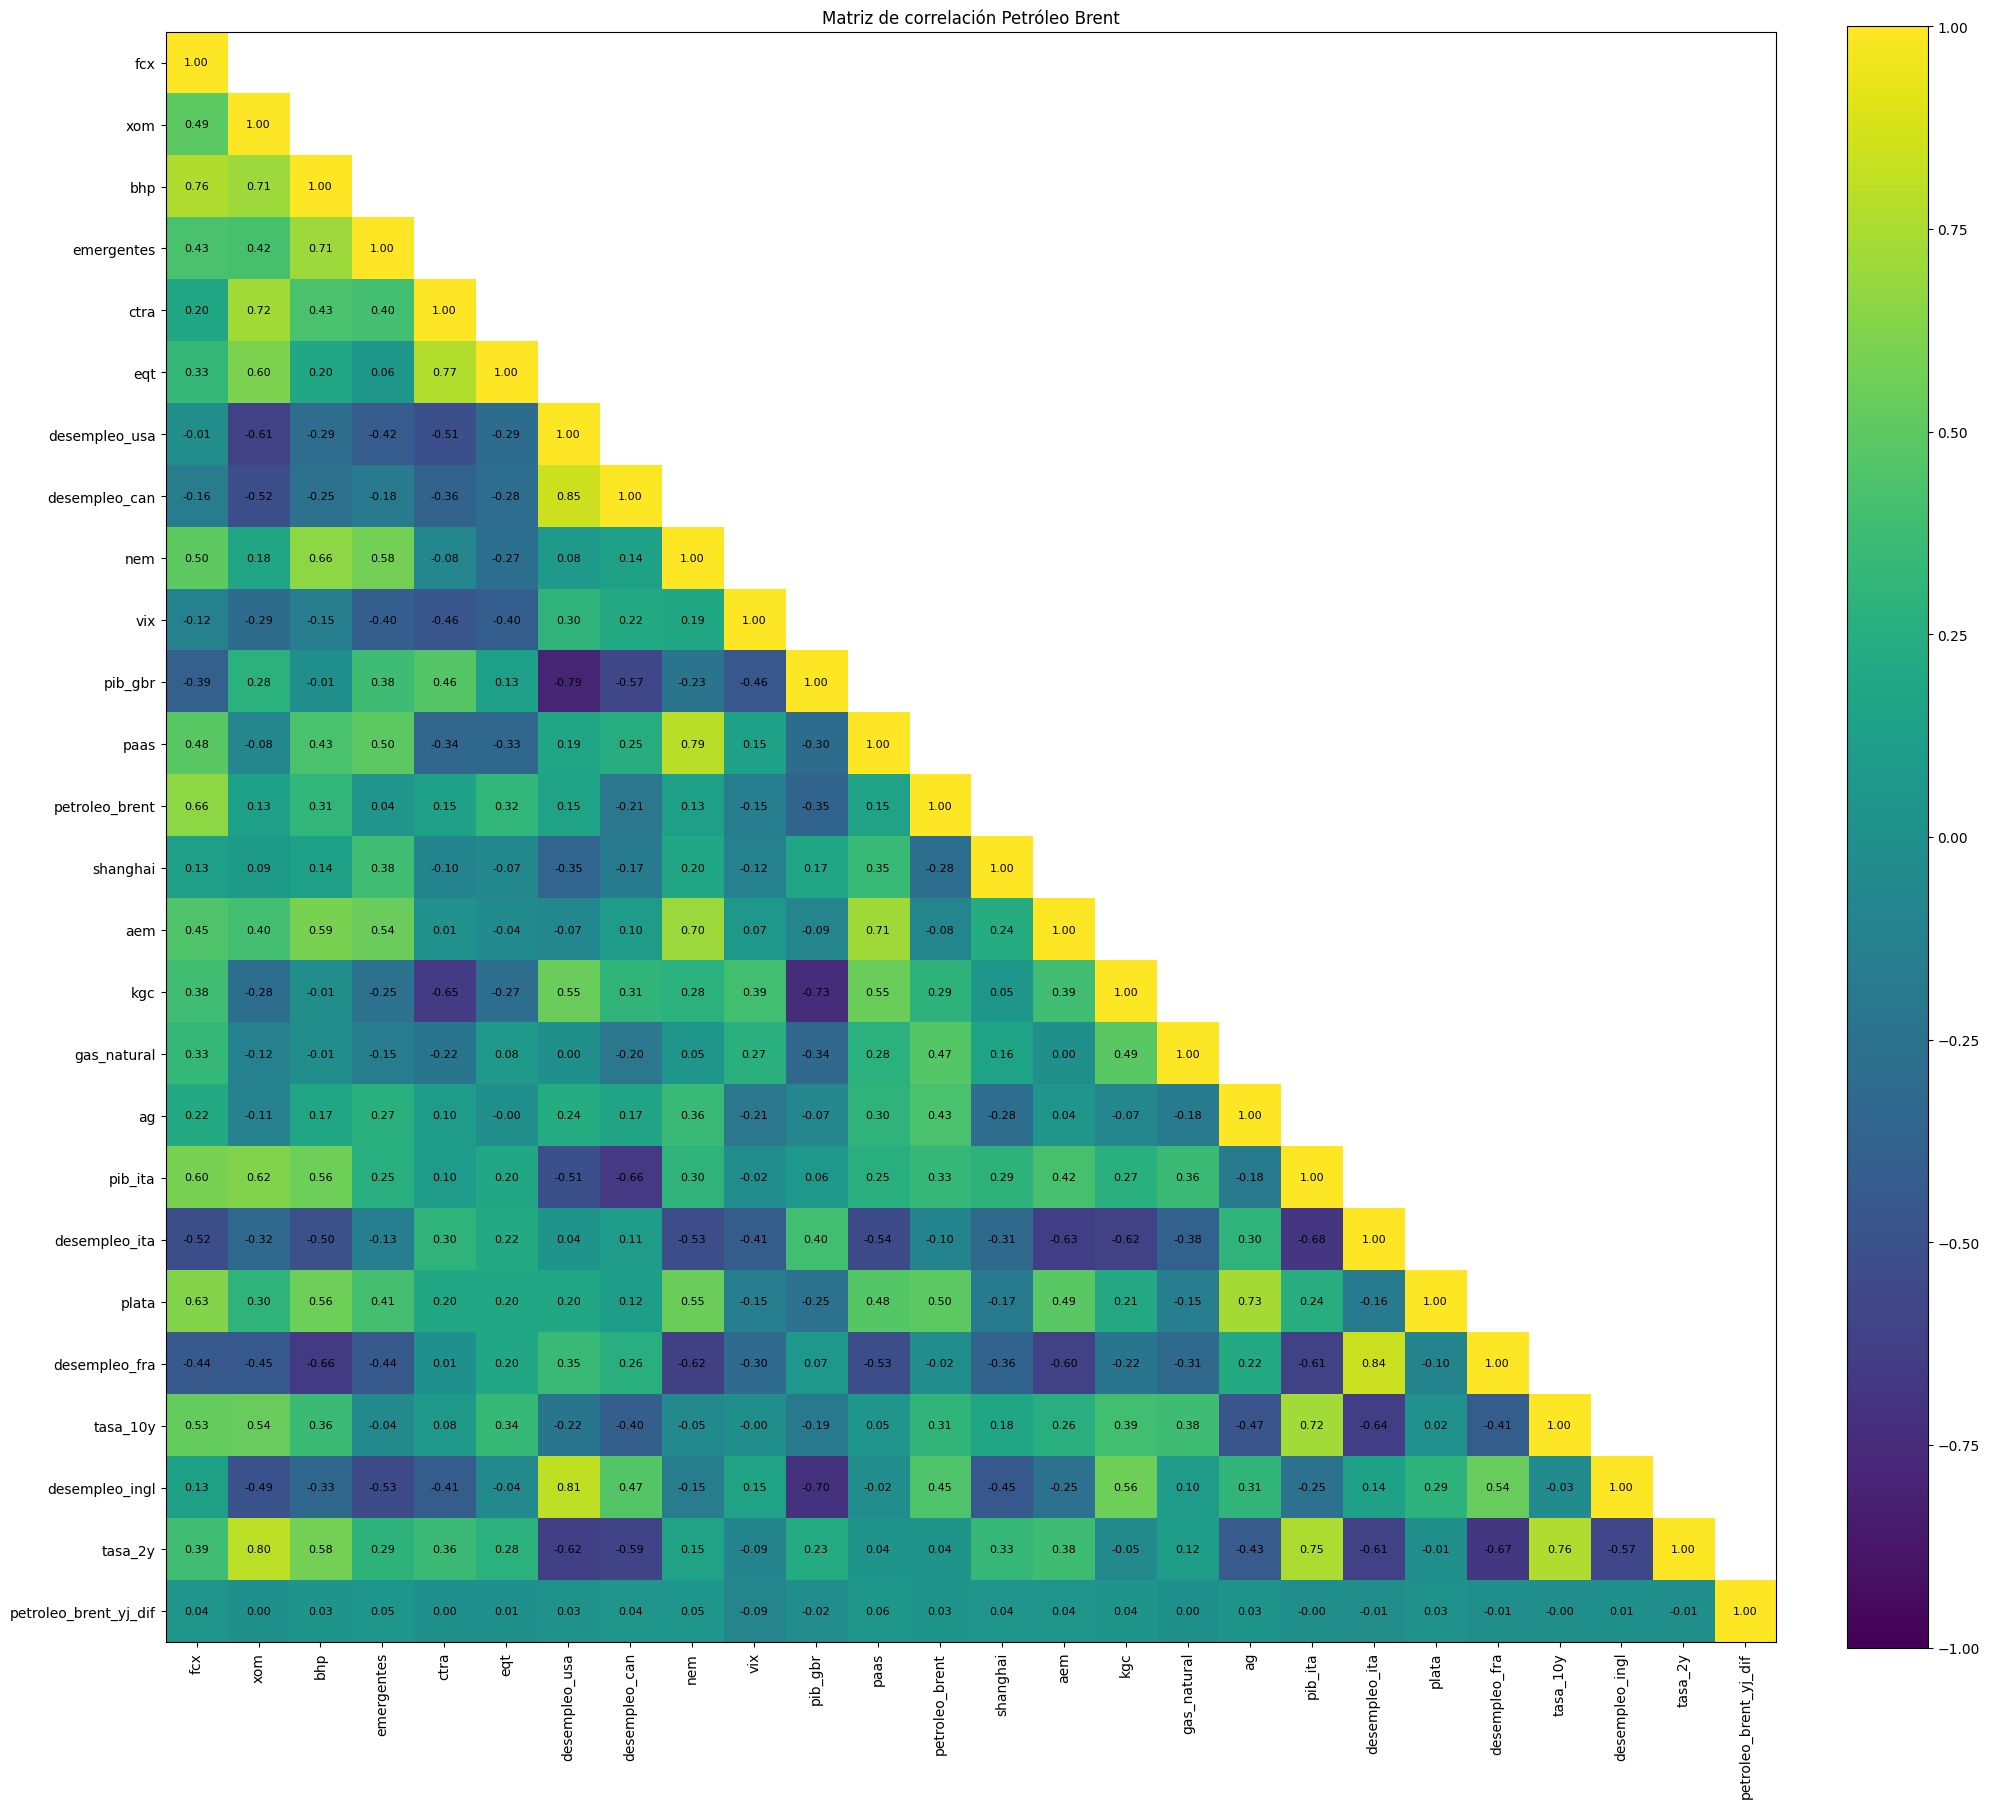

In [98]:
num_cols = (
    df_petroleo_brent_final.drop(columns=["petroleo_brent_yj"])
    .select_dtypes(include="number")
    .drop(columns=["fecha"], errors="ignore")
)

corr = num_cols.corr()

M = corr.values.copy()
mask = np.triu(np.ones_like(M, dtype=bool), k=1)
M_masked = M.copy()
M_masked[mask] = np.nan

plt.figure(figsize=(20, 20))
im = plt.imshow(M_masked, vmin=-1, vmax=1)  # sin cmap explícito
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        if not mask[i, j] and not np.isnan(M_masked[i, j]):
            plt.text(j, i, f"{M[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.title("Matriz de correlación Petróleo Brent")
plt.tight_layout()
plt.show()

In [99]:
df_petroleo_brent_final

fcx        xom       bhp  emergentes      ctra       eqt  \
FECHA                                                                       
2007-07-31 32.836269  44.734661 22.847242   30.161293  6.124954 21.234945   
2007-08-01 31.361826  45.107727 22.381550   30.042988  6.182264 21.987703   
2007-08-02 31.641344  44.760944 22.542746   30.375154  6.185846 22.456480   
2007-08-03 30.096992  43.131947 21.754663   29.064692  5.945861 21.897556   
2007-08-06 29.862906  43.899147 22.037655   29.583418  5.877806 22.235619   
...              ...        ...       ...         ...       ...       ...   
2025-06-09 42.049992 104.002220 50.180000   46.865986 25.714287 54.732189   
2025-06-10 41.901020 106.231476 50.880001   47.133396 25.635014 53.565762   
2025-06-11 40.729099 108.302208 50.610001   47.331478 25.545832 53.805031   
2025-06-12 40.897938 108.718338 49.810001   47.410706 25.902559 55.350292   
2025-06-13 40.659580 111.086304 48.549999   46.658001 26.457474 56.666256   

            desempleo_usa  desempleo_can       nem       vix       pib_gbr  \
FECHA                                                                        
2007-07-31       4.600000       6.100000 28.910706 23.520000 407553.300000   
2007-08-01       4.600000       6.000000 28.799919 23.670000 407553.300000   
2007-08-02       4.600000       6.000000 28.896852 21.219999 407553.300000   
2007-08-03       4.600000       6.000000 28.322113 25.160000 407553.300000   
2007-08-06       4.600000       6.000000 28.155912 22.940001 407553.300000   
...                   ...            ...       ...       ...           ...   
2025-06-09       4.200000       7.000000 53.103386 17.160000 432422.100000   
2025-06-10       4.200000       7.000000 52.385777 16.950001 432422.100000   
2025-06-11       4.200000       7.000000 53.133289 17.260000 432422.100000   
2025-06-12       4.200000       7.000000 55.734634 18.020000 432422.100000   
2025-06-13       4.200000       7.000000 57.708076 20.820000 432422.100000   

                paas  petroleo_brent    shanghai        aem       kgc  \
FECHA                                                                   
2007-07-31 21.549908       77.050003 4471.032227  32.626858 11.177741   
2007-08-01 21.255020       75.349998 4300.562988  32.028625 10.884951   
2007-08-02 21.681824       75.760002 4407.729980  32.427448 10.850503   
2007-08-03 22.100878       74.750000 4560.773926  32.887638 10.928005   
2007-08-06 21.899113       71.169998 4628.107910  31.798540 10.824667   
...              ...             ...         ...        ...       ...   
2025-06-09 29.209999       67.040001 3399.771973 118.171227 15.056290   
2025-06-10 28.490000       66.870003 3384.815918 116.725250 14.786715   
2025-06-11 28.660000       69.769997 3402.315918 118.580093 15.236007   
2025-06-12 28.959999       69.360001 3402.657959 121.751259 15.505582   
2025-06-13 29.010000       74.230003 3376.996094 124.114685 15.765173   

            gas_natural       ag       pib_ita  desempleo_ita     plata  \
FECHA                                                                     
2007-07-31     6.191000 4.245691 424785.500000       6.000000 12.950000   
2007-08-01     6.352000 4.443165 424785.500000       6.200000 12.888000   
2007-08-02     6.106000 4.403671 424785.500000       6.200000 12.935000   
2007-08-03     6.090000 4.176576 424785.500000       6.200000 13.100000   
2007-08-06     6.208000 4.176576 424785.500000       6.200000 12.977000   
...                 ...      ...           ...            ...       ...   
2025-06-09     3.635000 8.330000 431990.600000       6.500000 36.688000   
2025-06-10     3.533000 8.370000 431990.600000       6.500000 36.542000   
2025-06-11     3.507000 8.340000 431990.600000       6.500000 36.166000   
2025-06-12     3.492000 8.240000 431990.600000       6.500000 36.213001   
2025-06-13     3.581000 8.340000 431990.600000       6.500000 36.280998   

            desempleo_fra  tasa_10y  desempleo_ingl  tasa_2y  \
FECHA     

### Test de Causalidad de Granger

In [100]:
exclude_cols = ["petroleo_brent","petroleo_brent_yj"]
features = df_petroleo_brent_final.drop(columns=exclude_cols, errors="ignore").select_dtypes(include=['float64', 'int64']).columns

max_lag = 7
results = []

for col in features:
    try:
        data = df_petroleo_brent_final[[col, "petroleo_brent_yj_dif"]].dropna()
        
        if len(data) > max_lag + 1:
            test = grangercausalitytests(data[["petroleo_brent_yj_dif", col]], max_lag, verbose=False)
            row = {'Feature': col}
            for lag in range(1, max_lag + 1):
                p_val = test[lag][0]['ssr_ftest'][1]
                row[f'P_Value_Lag{lag}'] = p_val
                row[f'Significant_Lag{lag}'] = p_val < 0.05
            
            results.append(row)
    except:
        continue
granger_df = pd.DataFrame(results)
granger_df['Min_P_Value'] = granger_df[['P_Value_Lag1', 'P_Value_Lag2', 'P_Value_Lag3']].min(axis=1)
granger_df_petroleo = granger_df.sort_values('Min_P_Value').reset_index(drop=True)

granger_df_petroleo.head(40)

Feature  P_Value_Lag1  Significant_Lag1  P_Value_Lag2  \
0              bhp      0.399526             False      0.000000   
1              fcx      0.169847             False      0.000000   
2              xom      0.219576             False      0.000000   
3       emergentes      0.043927              True      0.000000   
4             ctra      0.238571             False      0.000001   
5    desempleo_can      0.003660              True      0.000015   
6    desempleo_usa      0.070937             False      0.000013   
7              eqt      0.410428             False      0.000006   
8          pib_gbr      0.166027             False      0.001369   
9              vix      0.054643             False      0.000279   
10             nem      0.028719              True      0.000169   
11            paas      0.009681              True      0.001482   
12     gas_natural      0.590392             False      0.245483   
13             kgc      0.144020             False      0.020562   
14              ag      0.215795             False      0.031617   
15         pib_ita      0.887336             False      0.101557   
16             aem      0.082238             False      0.020538   
17        shanghai      0.031087              True      0.030112   
18           plata      0.460957             False      0.714126   
19   desempleo_ita      0.475875             False      0.043737   
20   desempleo_fra      0.610934             False      0.752627   
21        tasa_10y      0.311206             False      0.200161   
22  desempleo_ingl      0.652157             False      0.221293   
23         tasa_2y      0.426977             False      0.268761   

    Significant_Lag2  P_Value_Lag3  Significant_Lag3  P_Value_Lag4  \
0               True      0.000000              True      0.000000   
1               True      0.000000              True      0.000000   
2               True      0.000000              True      0.000000   
3               True      0.000000              True      0.000000   
4               True      0.000002              True      0.000008   
5               True      0.000001              True      0.000002   
6               True      0.000002              True      0.000003   
7               True      0.000004              True      0.000013   
8               True      0.000033              True      0.000035   
9               True      0.000048              True      0.000249   
10              True      0.000212              True      0.000800   
11              True      0.002840              True      0.008604   
12             False      0.009872              True      0.019117   
13              True      0.014609              True      0.001413   
14              True      0.018541              True      0.033449   
15             False      0.019538              True      0.034891   
16              True      0.050385             False      0.065037   
17              True      0.060499             False      0.100104   
18             False      0.038734              True      0.057549   
19              True      0.097801             False      0.112981   
20             False      0.164931             False      0.248541   
21             False      0.342256             False      0.392991   
22             False      0.317503             False      0.092137   
23             False      0.328650             False      0.438586   

    Significant_Lag4  P_Value_Lag5  Significant_Lag5  P_Value_Lag6  \
0               True      0.000000              True      0.000000   
1               True      0.000000              True      0.000000   
2               True      0.000000              True      0.000000   
3               True      0.000000              True      0.000000   
4               True      0.000029              True      0.000044   
5               True      0.000001              True      0.000002   
6               True      0.000004              True      0.000008   

In [101]:
sig_cols = [c for c in granger_df_petroleo.columns if c.lower().startswith('significant_lag')]
granger_df_petroleo["granger_test"] = granger_df_petroleo[sig_cols].any(axis=1).astype(int) 

granger_df_petroleo=list(granger_df_petroleo[granger_df_petroleo["granger_test"]==1]["Feature"])+["petroleo_brent_yj"]
df_petroleo_brent_final=df_petroleo_brent_final[granger_df_petroleo]

### Gráfica Petróleo Brent - Box Cox

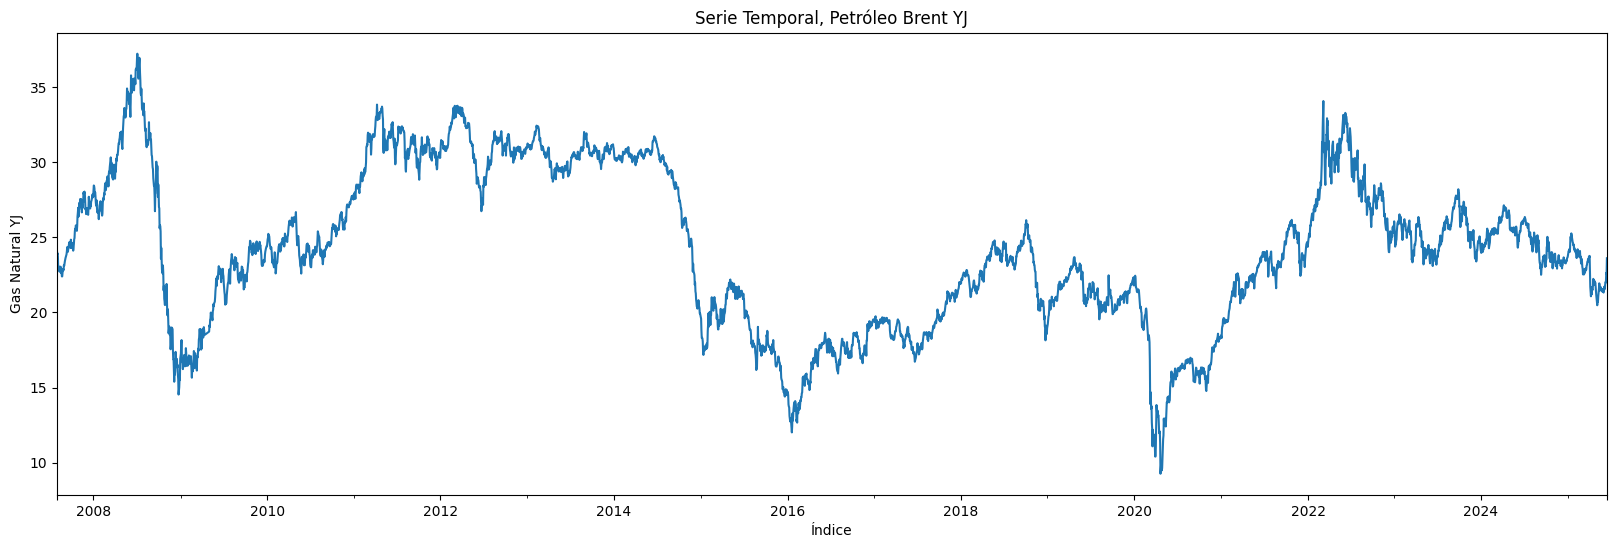

In [102]:
df_petroleo_brent_final['petroleo_brent_yj'].plot(figsize=(20,6))
plt.xlabel('Índice')
plt.ylabel('Gas Natural YJ')
plt.title('Serie Temporal, Petróleo Brent YJ')
plt.show()